In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import time
from torch.nn import init
from thop import profile

In [2]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
#%% Read FallAllD data
data=pd.read_hdf("D:/conda/FallAllD.h5") #
data = data.drop(columns = ['Gyr','Mag','Bar'])

#%% Read SisFull
data_Sis_pash="D:/conda/111_1117/SisFall_DL-master/SisFall_dataset/"
df=pd.read_csv(data_Sis_pash+"SisFall_DataNameList.csv",header=0)
df_r=df[1:]

df_v=df['DataName'].values[:]


PATH = "D:/conda/111_1117/SisFull_3LayerModel_CNN.pt"
#%% Label
testmin=[]
test_waist = []
data_waist = []
label_waist = []
subject_waist = []
# for i in range(len(data)):
for i in range (len(df_r)):

#     if(data['Device'][i] == 'Waist'):
#         a = data['Acc'][i]*0.000244        
        C_df = pd.read_csv(data_Sis_pash+df['DataName'][i])
        testmin.append(len(C_df))
        C_df = C_df[:].values[:2393].astype('float64')
        a= C_df
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a))
        data_waist.append(b)        
        subject_waist.append(df['Subject'][i])
        # Class: fall = 0 ,ADL = 1 
        if (df['FALL(1)_ADL(0)'][i]): 
                label_waist.append(1)
        else:
                label_waist.append(0)

#extend

# Change list to array
data_waist = np.array(data_waist, dtype=object)            
label_waist = np.array(label_waist, dtype=object)
subject_waist = np.array(subject_waist, dtype=object)
print(data_waist.shape)
# Downsampling 1/128
down_data = []
# (start:size:step)
# def down_data_SisADD(data_waist):
#down_data = data_waist[::1,::128,::1]
# data_waist = data_waist.reshape((len(data_waist), 1, 1))
down_data = data_waist[::1, ::62, ::1]
down_data = np.array(down_data, dtype=object)
print(down_data.shape)
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]  
# The signal of each second 
per_sec = 38/20
sec = 7

(3233, 2393, 3)
(3233, 39, 3)


In [3]:
# for num in range(len(down_data)):

#     if label_waist[num] ==1:
#         # Data[index][start:end,axis]
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
#         # Label each window with class and subject
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#     else:
#         #print(down_data[num])
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:]])
#         #print(sliding_waist_data)
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])
        
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:]])
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])
        
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:]])
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])
        
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:]])
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])


for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])

sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 
print(sliding_waist_data.shape)
np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

(12932, 14, 3)


In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out


class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out


class SeModule(nn.Module):
    def __init__(self, in_size, reduction=4):
        super(SeModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_size, in_size // reduction, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size // reduction),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_size // reduction, in_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size),
            hsigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, kernel_size, in_size, expand_size, out_size, nolinear, semodule, stride):
        super(Block, self).__init__()
        self.stride = stride
        self.se = semodule

        self.conv1 = nn.Conv2d(in_size, expand_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(expand_size)
        self.nolinear1 = nolinear
        self.conv2 = nn.Conv2d(expand_size, expand_size, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_size, bias=False)
        self.bn2 = nn.BatchNorm2d(expand_size)
        self.nolinear2 = nolinear
        self.conv3 = nn.Conv2d(expand_size, out_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_size)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_size != out_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_size),
            )

    def forward(self, x):
        out = self.nolinear1(self.bn1(self.conv1(x)))
        out = self.nolinear2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.se != None:
            out = self.se(out)
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

In [7]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [8]:
class MobileNetV3_Large(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Large, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), None, 1),
            Block(3, 16, 64, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 72, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 72, 40, nn.ReLU(inplace=True), SeModule(40), 2),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(3, 40, 240, 80, hswish(), None, 2),
            Block(3, 80, 200, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 480, 112, hswish(), SeModule(112), 1),
            Block(3, 112, 672, 112, hswish(), SeModule(112), 1),
            Block(5, 112, 672, 160, hswish(), SeModule(160), 1),
            Block(5, 160, 672, 160, hswish(), SeModule(160), 2),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
        )


        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(960, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [9]:
class MobileNetV3_Small_KD(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small_KD, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [10]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(64, self.nb_filters,(3,1))
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(64*4,256)  
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(64, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x    
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation

#%% Define student neural network
class Net_Teacher_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(64, self.nb_filters,(3,1))
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(64*4,256)  
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(64, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x   
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation

In [11]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    #save(config['epochs'], model, optimizer, loss)
    
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [12]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [13]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader,Layer,lis):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))   

    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
    
   
    
    
#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    if (Layer==False) and (lis == 23):
            save(config['epochs'], model_student, optimizer, loss)  
            #return teacher_student_train_preds, teacher_student_train_gt, teacher_student_model, teacher_student_optimizer, teacher_student_loss
    if (Layer==False) and (lis == 1):
            save(config['epochs'], model_student, optimizer, loss)
    return teacher_student_train_preds, teacher_student_train_gt

In [14]:
def training_distillation_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader,Layer,lis):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
    

#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        Distillation_student_train_preds.extend(test_preds)
        Distillation_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    return Distillation_student_train_preds, Distillation_student_train_gt

In [15]:
def save(epoch, student, optimizer, loss):
#     trial_id = self.config['trial_id']
#     if name is None:
        torch.save({
        'epoch': epoch,
        'model_state_dict': student.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        #'loss_state_dict': loss.state_dice()
        'loss_state_dict': loss.item()
        }, PATH)
#     else:
#         torch.save({
#         'model_state_dict': self.student.state_dict(),
#         'optimizer_state_dict': self.optimizer.state_dict(),
#         'epoch': epoch,
#         }, name)

        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")

In [16]:
def load_checkpoint(model, checkpoint_path):
        """
        Loads weights from checkpoint
        :param model: a pytorch nn student
        :param str checkpoint_path: address/path of a file
        :return: pytorch nn student with weights loaded from checkpoint
        """
        model_ckp = torch.load(checkpoint_path)
        model.load_state_dict(model_ckp['model_state_dict'])
        return model


Subject 1
| epoch   0 | 0.3614 s/epoch | train loss 0.3188
| epoch   1 | 0.2969 s/epoch | train loss 0.2395
| epoch   2 | 0.4150 s/epoch | train loss 0.2124
| epoch   3 | 0.4630 s/epoch | train loss 0.2044
| epoch   4 | 0.5422 s/epoch | train loss 0.1865
| epoch   5 | 0.3365 s/epoch | train loss 0.2029
| epoch   6 | 0.3373 s/epoch | train loss 0.1857
| epoch   7 | 0.3381 s/epoch | train loss 0.1817
| epoch   8 | 0.3365 s/epoch | train loss 0.1805
| epoch   9 | 0.3396 s/epoch | train loss 0.2505
| epoch  10 | 0.3356 s/epoch | train loss 0.2207
| epoch  11 | 0.3343 s/epoch | train loss 0.1996
| epoch  12 | 0.3359 s/epoch | train loss 0.1789
| epoch  13 | 0.3314 s/epoch | train loss 0.1694
| epoch  14 | 0.3311 s/epoch | train loss 0.1650
| epoch  15 | 0.3359 s/epoch | train loss 0.1612
| epoch  16 | 0.3353 s/epoch | train loss 0.1454
| epoch  17 | 0.3291 s/epoch | train loss 0.1418
| epoch  18 | 0.3366 s/epoch | train loss 0.1381
| epoch  19 | 0.3363 s/epoch | train loss 0.1393
| epoch  

| epoch 167 | 0.3368 s/epoch | train loss 0.0247
| epoch 168 | 0.3421 s/epoch | train loss 0.0238
| epoch 169 | 0.3428 s/epoch | train loss 0.0396
| epoch 170 | 0.3362 s/epoch | train loss 0.0252
| epoch 171 | 0.3356 s/epoch | train loss 0.0205
| epoch 172 | 0.3374 s/epoch | train loss 0.0246
| epoch 173 | 0.3386 s/epoch | train loss 0.0223
| epoch 174 | 0.3339 s/epoch | train loss 0.0189
| epoch 175 | 0.3393 s/epoch | train loss 0.0226
| epoch 176 | 0.3407 s/epoch | train loss 0.0217
| epoch 177 | 0.3391 s/epoch | train loss 0.0238
| epoch 178 | 0.3372 s/epoch | train loss 0.0228
| epoch 179 | 0.3380 s/epoch | train loss 0.0163
| epoch 180 | 0.3394 s/epoch | train loss 0.0197
| epoch 181 | 0.3401 s/epoch | train loss 0.0255
| epoch 182 | 0.3374 s/epoch | train loss 0.0176
| epoch 183 | 0.3363 s/epoch | train loss 0.0175
| epoch 184 | 0.3387 s/epoch | train loss 0.0192
| epoch 185 | 0.3382 s/epoch | train loss 0.0179
| epoch 186 | 0.3403 s/epoch | train loss 0.0253
| epoch 187 | 0.3368

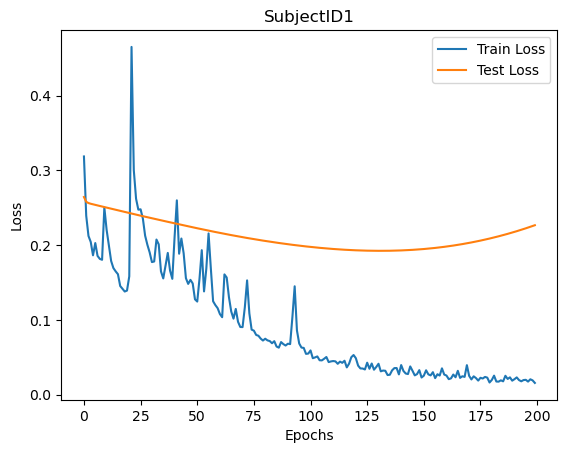

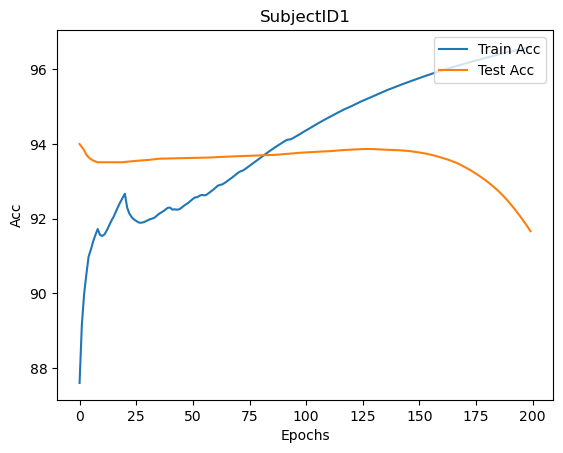

| epoch   0 | 0.0236 s/epoch | train loss 0.4097
| epoch   1 | 0.0228 s/epoch | train loss 0.2898
| epoch   2 | 0.0241 s/epoch | train loss 0.2641
| epoch   3 | 0.0226 s/epoch | train loss 0.2489
| epoch   4 | 0.0217 s/epoch | train loss 0.2380
| epoch   5 | 0.0229 s/epoch | train loss 0.2327
| epoch   6 | 0.0213 s/epoch | train loss 0.2317
| epoch   7 | 0.0218 s/epoch | train loss 0.2126
| epoch   8 | 0.0235 s/epoch | train loss 0.2052
| epoch   9 | 0.0208 s/epoch | train loss 0.1955
| epoch  10 | 0.0228 s/epoch | train loss 0.1930
| epoch  11 | 0.0235 s/epoch | train loss 0.1901
| epoch  12 | 0.0233 s/epoch | train loss 0.1825
| epoch  13 | 0.0216 s/epoch | train loss 0.1810
| epoch  14 | 0.0223 s/epoch | train loss 0.1752
| epoch  15 | 0.0220 s/epoch | train loss 0.1678
| epoch  16 | 0.0221 s/epoch | train loss 0.1698
| epoch  17 | 0.0227 s/epoch | train loss 0.1662
| epoch  18 | 0.0217 s/epoch | train loss 0.1627
| epoch  19 | 0.0219 s/epoch | train loss 0.1533
| epoch  20 | 0.0222

| epoch 168 | 0.0212 s/epoch | train loss 0.0177
| epoch 169 | 0.0211 s/epoch | train loss 0.0271
| epoch 170 | 0.0220 s/epoch | train loss 0.0321
| epoch 171 | 0.0209 s/epoch | train loss 0.0190
| epoch 172 | 0.0211 s/epoch | train loss 0.0238
| epoch 173 | 0.0210 s/epoch | train loss 0.0208
| epoch 174 | 0.0219 s/epoch | train loss 0.0178
| epoch 175 | 0.0220 s/epoch | train loss 0.0175
| epoch 176 | 0.0210 s/epoch | train loss 0.0367
| epoch 177 | 0.0229 s/epoch | train loss 0.0195
| epoch 178 | 0.0210 s/epoch | train loss 0.0205
| epoch 179 | 0.0224 s/epoch | train loss 0.0226
| epoch 180 | 0.0214 s/epoch | train loss 0.0226
| epoch 181 | 0.0216 s/epoch | train loss 0.0167
| epoch 182 | 0.0223 s/epoch | train loss 0.0313
| epoch 183 | 0.0217 s/epoch | train loss 0.0134
| epoch 184 | 0.0202 s/epoch | train loss 0.0268
| epoch 185 | 0.0220 s/epoch | train loss 0.0193
| epoch 186 | 0.0210 s/epoch | train loss 0.0214
| epoch 187 | 0.0208 s/epoch | train loss 0.0163
| epoch 188 | 0.0209

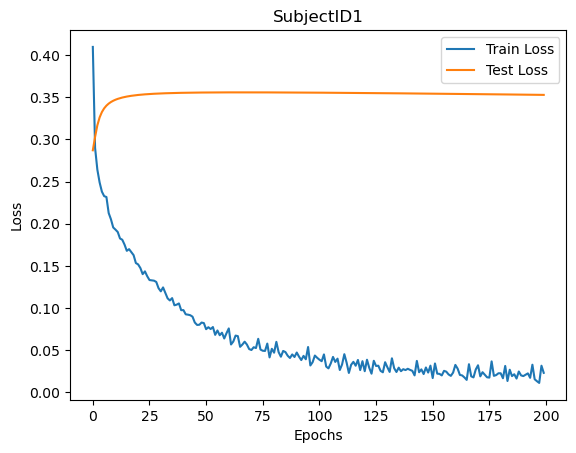

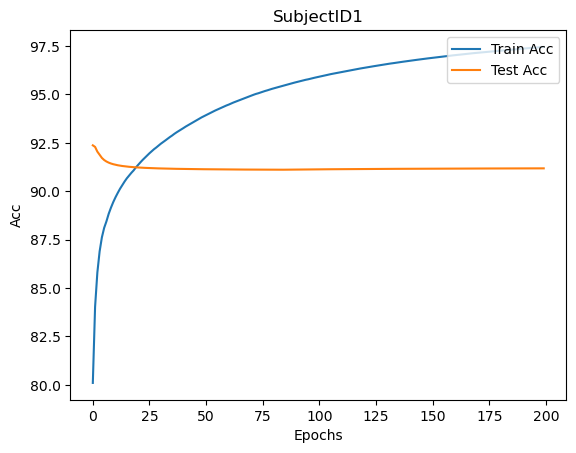


Subject 2
| epoch   0 | 0.3337 s/epoch | train loss 0.3792
| epoch   1 | 0.3328 s/epoch | train loss 0.2991
| epoch   2 | 0.3374 s/epoch | train loss 0.2457
| epoch   3 | 0.3375 s/epoch | train loss 0.2825
| epoch   4 | 0.3382 s/epoch | train loss 0.2765
| epoch   5 | 0.3374 s/epoch | train loss 0.2467
| epoch   6 | 0.3348 s/epoch | train loss 0.2274
| epoch   7 | 0.3325 s/epoch | train loss 0.2127
| epoch   8 | 0.3380 s/epoch | train loss 0.2319
| epoch   9 | 0.3348 s/epoch | train loss 0.2086
| epoch  10 | 0.3356 s/epoch | train loss 0.2182
| epoch  11 | 0.3369 s/epoch | train loss 0.1825
| epoch  12 | 0.3386 s/epoch | train loss 0.1788
| epoch  13 | 0.3309 s/epoch | train loss 0.1693
| epoch  14 | 0.3363 s/epoch | train loss 0.1903
| epoch  15 | 0.3326 s/epoch | train loss 0.1881
| epoch  16 | 0.3334 s/epoch | train loss 0.1726
| epoch  17 | 0.3343 s/epoch | train loss 0.1575
| epoch  18 | 0.3347 s/epoch | train loss 0.1677
| epoch  19 | 0.3340 s/epoch | train loss 0.1874
| epoch  

| epoch 167 | 0.3799 s/epoch | train loss 0.0224
| epoch 168 | 0.3929 s/epoch | train loss 0.0224
| epoch 169 | 0.4092 s/epoch | train loss 0.0199
| epoch 170 | 0.4361 s/epoch | train loss 0.0275
| epoch 171 | 0.4099 s/epoch | train loss 0.0273
| epoch 172 | 0.3779 s/epoch | train loss 0.0219
| epoch 173 | 0.3984 s/epoch | train loss 0.0222
| epoch 174 | 0.4007 s/epoch | train loss 0.0206
| epoch 175 | 0.4161 s/epoch | train loss 0.0160
| epoch 176 | 0.4265 s/epoch | train loss 0.0231
| epoch 177 | 0.3903 s/epoch | train loss 0.0151
| epoch 178 | 0.3908 s/epoch | train loss 0.0236
| epoch 179 | 0.4131 s/epoch | train loss 0.0208
| epoch 180 | 0.4101 s/epoch | train loss 0.0217
| epoch 181 | 0.4211 s/epoch | train loss 0.0198
| epoch 182 | 0.4024 s/epoch | train loss 0.0199
| epoch 183 | 0.4047 s/epoch | train loss 0.0201
| epoch 184 | 0.4005 s/epoch | train loss 0.0224
| epoch 185 | 0.4378 s/epoch | train loss 0.0142
| epoch 186 | 0.4304 s/epoch | train loss 0.0166
| epoch 187 | 0.4219

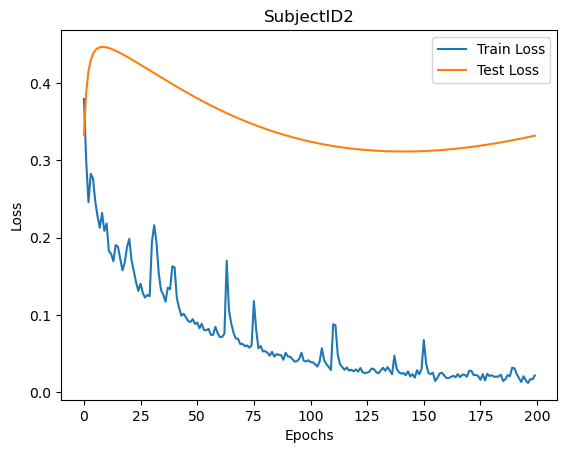

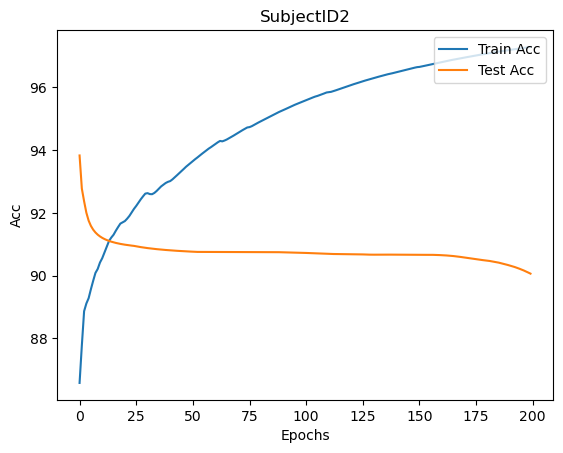

| epoch   0 | 0.0197 s/epoch | train loss 0.4189
| epoch   1 | 0.0402 s/epoch | train loss 0.3092
| epoch   2 | 0.0185 s/epoch | train loss 0.2736
| epoch   3 | 0.0287 s/epoch | train loss 0.2525
| epoch   4 | 0.0305 s/epoch | train loss 0.2389
| epoch   5 | 0.0313 s/epoch | train loss 0.2339
| epoch   6 | 0.0308 s/epoch | train loss 0.2281
| epoch   7 | 0.0297 s/epoch | train loss 0.2199
| epoch   8 | 0.0291 s/epoch | train loss 0.2153
| epoch   9 | 0.0341 s/epoch | train loss 0.2049
| epoch  10 | 0.0292 s/epoch | train loss 0.1921
| epoch  11 | 0.0265 s/epoch | train loss 0.1884
| epoch  12 | 0.0282 s/epoch | train loss 0.1875
| epoch  13 | 0.0293 s/epoch | train loss 0.1813
| epoch  14 | 0.0273 s/epoch | train loss 0.1700
| epoch  15 | 0.0287 s/epoch | train loss 0.1673
| epoch  16 | 0.0281 s/epoch | train loss 0.1640
| epoch  17 | 0.0284 s/epoch | train loss 0.1688
| epoch  18 | 0.0279 s/epoch | train loss 0.1570
| epoch  19 | 0.0274 s/epoch | train loss 0.1537
| epoch  20 | 0.0198

| epoch 168 | 0.0311 s/epoch | train loss 0.0178
| epoch 169 | 0.0295 s/epoch | train loss 0.0254
| epoch 170 | 0.0299 s/epoch | train loss 0.0204
| epoch 171 | 0.0316 s/epoch | train loss 0.0197
| epoch 172 | 0.0305 s/epoch | train loss 0.0216
| epoch 173 | 0.0301 s/epoch | train loss 0.0267
| epoch 174 | 0.0324 s/epoch | train loss 0.0229
| epoch 175 | 0.0316 s/epoch | train loss 0.0175
| epoch 176 | 0.0287 s/epoch | train loss 0.0234
| epoch 177 | 0.0316 s/epoch | train loss 0.0231
| epoch 178 | 0.0312 s/epoch | train loss 0.0267
| epoch 179 | 0.0306 s/epoch | train loss 0.0119
| epoch 180 | 0.0397 s/epoch | train loss 0.0243
| epoch 181 | 0.0309 s/epoch | train loss 0.0175
| epoch 182 | 0.0301 s/epoch | train loss 0.0168
| epoch 183 | 0.0309 s/epoch | train loss 0.0310
| epoch 184 | 0.0282 s/epoch | train loss 0.0160
| epoch 185 | 0.0291 s/epoch | train loss 0.0157
| epoch 186 | 0.0291 s/epoch | train loss 0.0283
| epoch 187 | 0.0304 s/epoch | train loss 0.0227
| epoch 188 | 0.0296

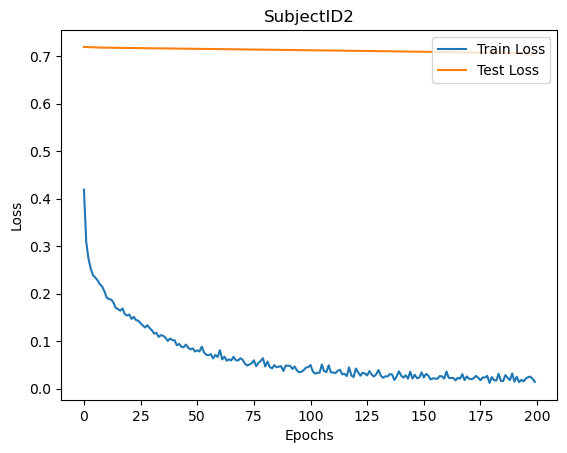

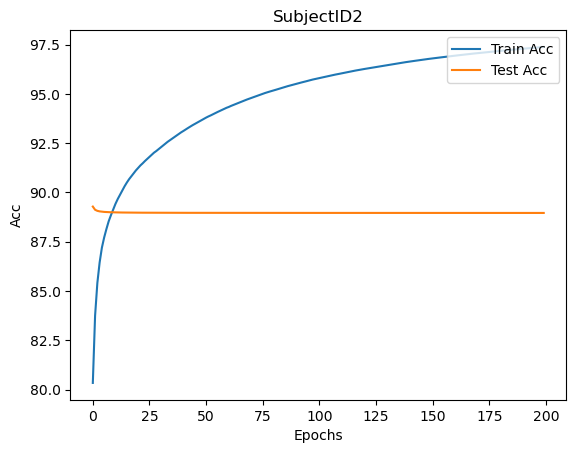


Subject 3
| epoch   0 | 0.4301 s/epoch | train loss 0.3243
| epoch   1 | 0.4140 s/epoch | train loss 0.2385
| epoch   2 | 0.4224 s/epoch | train loss 0.2327
| epoch   3 | 0.3784 s/epoch | train loss 0.2153
| epoch   4 | 0.4061 s/epoch | train loss 0.2017
| epoch   5 | 0.3932 s/epoch | train loss 0.1907
| epoch   6 | 0.4132 s/epoch | train loss 0.1839
| epoch   7 | 0.4149 s/epoch | train loss 0.1713
| epoch   8 | 0.3976 s/epoch | train loss 0.1635
| epoch   9 | 0.3967 s/epoch | train loss 0.2051
| epoch  10 | 0.3882 s/epoch | train loss 0.1759
| epoch  11 | 0.4255 s/epoch | train loss 0.1607
| epoch  12 | 0.4460 s/epoch | train loss 0.1577
| epoch  13 | 0.4469 s/epoch | train loss 0.1444
| epoch  14 | 0.3875 s/epoch | train loss 0.1369
| epoch  15 | 0.3684 s/epoch | train loss 0.1609
| epoch  16 | 0.3965 s/epoch | train loss 0.1514
| epoch  17 | 0.4185 s/epoch | train loss 0.1309
| epoch  18 | 0.4333 s/epoch | train loss 0.1347
| epoch  19 | 0.4378 s/epoch | train loss 0.1225
| epoch  

| epoch 167 | 0.3940 s/epoch | train loss 0.0131
| epoch 168 | 0.4121 s/epoch | train loss 0.0269
| epoch 169 | 0.3714 s/epoch | train loss 0.0218
| epoch 170 | 0.3999 s/epoch | train loss 0.0148
| epoch 171 | 0.4444 s/epoch | train loss 0.0237
| epoch 172 | 0.4240 s/epoch | train loss 0.0230
| epoch 173 | 0.4250 s/epoch | train loss 0.0165
| epoch 174 | 0.4093 s/epoch | train loss 0.0146
| epoch 175 | 0.4199 s/epoch | train loss 0.0179
| epoch 176 | 0.4246 s/epoch | train loss 0.0114
| epoch 177 | 0.3933 s/epoch | train loss 0.0154
| epoch 178 | 0.3982 s/epoch | train loss 0.0160
| epoch 179 | 0.4044 s/epoch | train loss 0.0257
| epoch 180 | 0.4096 s/epoch | train loss 0.0180
| epoch 181 | 0.4102 s/epoch | train loss 0.0158
| epoch 182 | 0.4217 s/epoch | train loss 0.0122
| epoch 183 | 0.3936 s/epoch | train loss 0.0152
| epoch 184 | 0.4193 s/epoch | train loss 0.0154
| epoch 185 | 0.3962 s/epoch | train loss 0.0146
| epoch 186 | 0.4300 s/epoch | train loss 0.0186
| epoch 187 | 0.3936

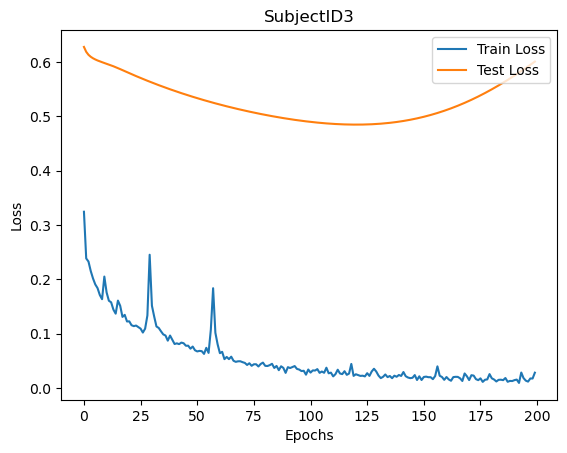

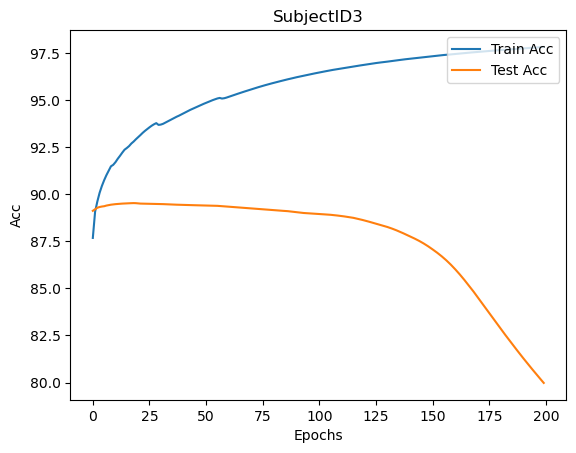

| epoch   0 | 0.0368 s/epoch | train loss 0.4322
| epoch   1 | 0.0298 s/epoch | train loss 0.2977
| epoch   2 | 0.0179 s/epoch | train loss 0.2799
| epoch   3 | 0.0406 s/epoch | train loss 0.2607
| epoch   4 | 0.0194 s/epoch | train loss 0.2459
| epoch   5 | 0.0380 s/epoch | train loss 0.2354
| epoch   6 | 0.0201 s/epoch | train loss 0.2146
| epoch   7 | 0.0301 s/epoch | train loss 0.2209
| epoch   8 | 0.0391 s/epoch | train loss 0.2024
| epoch   9 | 0.0205 s/epoch | train loss 0.1929
| epoch  10 | 0.0282 s/epoch | train loss 0.1926
| epoch  11 | 0.0433 s/epoch | train loss 0.1852
| epoch  12 | 0.0312 s/epoch | train loss 0.1829
| epoch  13 | 0.0267 s/epoch | train loss 0.1702
| epoch  14 | 0.0278 s/epoch | train loss 0.1680
| epoch  15 | 0.0299 s/epoch | train loss 0.1655
| epoch  16 | 0.0282 s/epoch | train loss 0.1648
| epoch  17 | 0.0280 s/epoch | train loss 0.1569
| epoch  18 | 0.0202 s/epoch | train loss 0.1550
| epoch  19 | 0.0307 s/epoch | train loss 0.1569
| epoch  20 | 0.0284

| epoch 168 | 0.0294 s/epoch | train loss 0.0333
| epoch 169 | 0.0292 s/epoch | train loss 0.0338
| epoch 170 | 0.0309 s/epoch | train loss 0.0156
| epoch 171 | 0.0314 s/epoch | train loss 0.0160
| epoch 172 | 0.0291 s/epoch | train loss 0.0218
| epoch 173 | 0.0333 s/epoch | train loss 0.0275
| epoch 174 | 0.0312 s/epoch | train loss 0.0204
| epoch 175 | 0.0309 s/epoch | train loss 0.0221
| epoch 176 | 0.0316 s/epoch | train loss 0.0237
| epoch 177 | 0.0388 s/epoch | train loss 0.0269
| epoch 178 | 0.0202 s/epoch | train loss 0.0188
| epoch 179 | 0.0406 s/epoch | train loss 0.0223
| epoch 180 | 0.0309 s/epoch | train loss 0.0229
| epoch 181 | 0.0275 s/epoch | train loss 0.0250
| epoch 182 | 0.0319 s/epoch | train loss 0.0226
| epoch 183 | 0.0310 s/epoch | train loss 0.0209
| epoch 184 | 0.0317 s/epoch | train loss 0.0177
| epoch 185 | 0.0319 s/epoch | train loss 0.0188
| epoch 186 | 0.0304 s/epoch | train loss 0.0234
| epoch 187 | 0.0317 s/epoch | train loss 0.0235
| epoch 188 | 0.0280

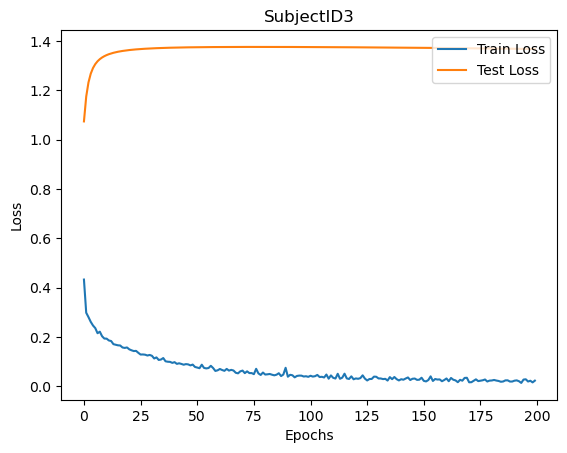

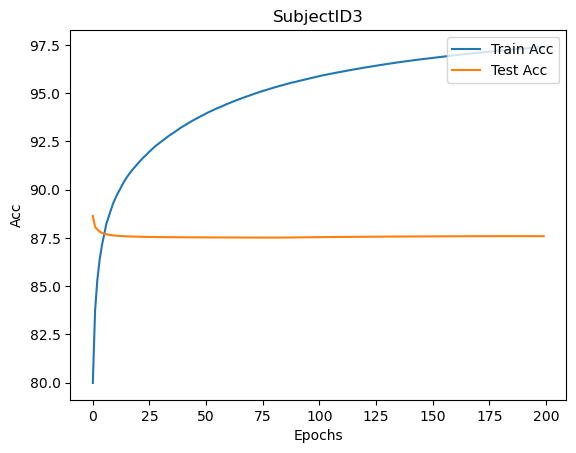


Subject 4
| epoch   0 | 0.4075 s/epoch | train loss 0.3409
| epoch   1 | 0.3957 s/epoch | train loss 0.2412
| epoch   2 | 0.4169 s/epoch | train loss 0.2245
| epoch   3 | 0.4239 s/epoch | train loss 0.2235
| epoch   4 | 0.4031 s/epoch | train loss 0.2032
| epoch   5 | 0.4056 s/epoch | train loss 0.2118
| epoch   6 | 0.4101 s/epoch | train loss 0.2302
| epoch   7 | 0.4217 s/epoch | train loss 0.2027
| epoch   8 | 0.4018 s/epoch | train loss 0.1906
| epoch   9 | 0.4044 s/epoch | train loss 0.1738
| epoch  10 | 0.4023 s/epoch | train loss 0.1638
| epoch  11 | 0.4255 s/epoch | train loss 0.1584
| epoch  12 | 0.4038 s/epoch | train loss 0.1529
| epoch  13 | 0.4261 s/epoch | train loss 0.1500
| epoch  14 | 0.3986 s/epoch | train loss 0.1357
| epoch  15 | 0.4044 s/epoch | train loss 0.2411
| epoch  16 | 0.4240 s/epoch | train loss 0.1853
| epoch  17 | 0.4111 s/epoch | train loss 0.1540
| epoch  18 | 0.4038 s/epoch | train loss 0.1436
| epoch  19 | 0.4143 s/epoch | train loss 0.1378
| epoch  

| epoch 167 | 0.3373 s/epoch | train loss 0.0619
| epoch 168 | 0.3392 s/epoch | train loss 0.0311
| epoch 169 | 0.3423 s/epoch | train loss 0.0208
| epoch 170 | 0.3345 s/epoch | train loss 0.0157
| epoch 171 | 0.3390 s/epoch | train loss 0.0210
| epoch 172 | 0.3398 s/epoch | train loss 0.0169
| epoch 173 | 0.3347 s/epoch | train loss 0.0122
| epoch 174 | 0.3332 s/epoch | train loss 0.0127
| epoch 175 | 0.3371 s/epoch | train loss 0.0144
| epoch 176 | 0.3395 s/epoch | train loss 0.0102
| epoch 177 | 0.3380 s/epoch | train loss 0.0146
| epoch 178 | 0.3330 s/epoch | train loss 0.0125
| epoch 179 | 0.3331 s/epoch | train loss 0.0180
| epoch 180 | 0.3383 s/epoch | train loss 0.0253
| epoch 181 | 0.3358 s/epoch | train loss 0.0150
| epoch 182 | 0.3373 s/epoch | train loss 0.0160
| epoch 183 | 0.3370 s/epoch | train loss 0.0158
| epoch 184 | 0.3376 s/epoch | train loss 0.0103
| epoch 185 | 0.3331 s/epoch | train loss 0.0153
| epoch 186 | 0.3327 s/epoch | train loss 0.0188
| epoch 187 | 0.3358

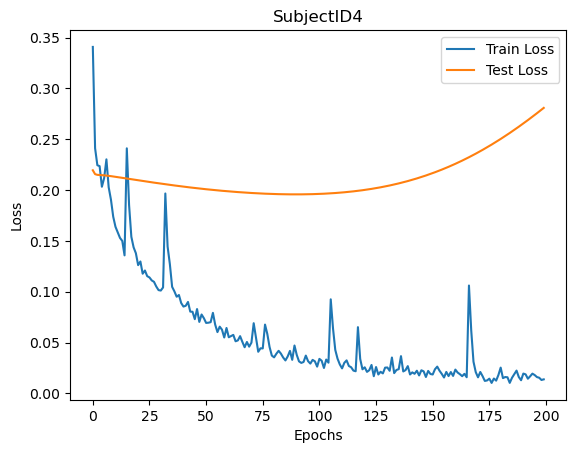

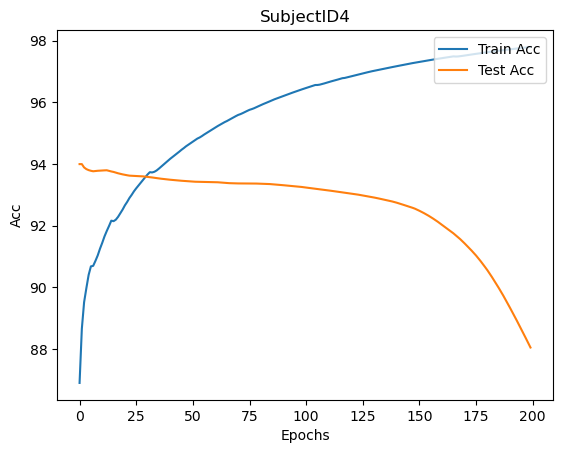

| epoch   0 | 0.0194 s/epoch | train loss 0.4213
| epoch   1 | 0.0207 s/epoch | train loss 0.3055
| epoch   2 | 0.0218 s/epoch | train loss 0.2714
| epoch   3 | 0.0235 s/epoch | train loss 0.2567
| epoch   4 | 0.0208 s/epoch | train loss 0.2524
| epoch   5 | 0.0216 s/epoch | train loss 0.2314
| epoch   6 | 0.0218 s/epoch | train loss 0.2240
| epoch   7 | 0.0217 s/epoch | train loss 0.2153
| epoch   8 | 0.0226 s/epoch | train loss 0.2073
| epoch   9 | 0.0208 s/epoch | train loss 0.2059
| epoch  10 | 0.0204 s/epoch | train loss 0.1962
| epoch  11 | 0.0220 s/epoch | train loss 0.1894
| epoch  12 | 0.0230 s/epoch | train loss 0.1866
| epoch  13 | 0.0214 s/epoch | train loss 0.1794
| epoch  14 | 0.0217 s/epoch | train loss 0.1697
| epoch  15 | 0.0231 s/epoch | train loss 0.1684
| epoch  16 | 0.0220 s/epoch | train loss 0.1677
| epoch  17 | 0.0212 s/epoch | train loss 0.1588
| epoch  18 | 0.0201 s/epoch | train loss 0.1584
| epoch  19 | 0.0213 s/epoch | train loss 0.1525
| epoch  20 | 0.0216

| epoch 168 | 0.0212 s/epoch | train loss 0.0272
| epoch 169 | 0.0228 s/epoch | train loss 0.0177
| epoch 170 | 0.0215 s/epoch | train loss 0.0207
| epoch 171 | 0.0226 s/epoch | train loss 0.0168
| epoch 172 | 0.0234 s/epoch | train loss 0.0257
| epoch 173 | 0.0215 s/epoch | train loss 0.0166
| epoch 174 | 0.0212 s/epoch | train loss 0.0215
| epoch 175 | 0.0231 s/epoch | train loss 0.0193
| epoch 176 | 0.0220 s/epoch | train loss 0.0245
| epoch 177 | 0.0225 s/epoch | train loss 0.0252
| epoch 178 | 0.0220 s/epoch | train loss 0.0168
| epoch 179 | 0.0217 s/epoch | train loss 0.0205
| epoch 180 | 0.0221 s/epoch | train loss 0.0152
| epoch 181 | 0.0222 s/epoch | train loss 0.0134
| epoch 182 | 0.0217 s/epoch | train loss 0.0309
| epoch 183 | 0.0234 s/epoch | train loss 0.0137
| epoch 184 | 0.0242 s/epoch | train loss 0.0182
| epoch 185 | 0.0224 s/epoch | train loss 0.0271
| epoch 186 | 0.0239 s/epoch | train loss 0.0196
| epoch 187 | 0.0227 s/epoch | train loss 0.0283
| epoch 188 | 0.0232

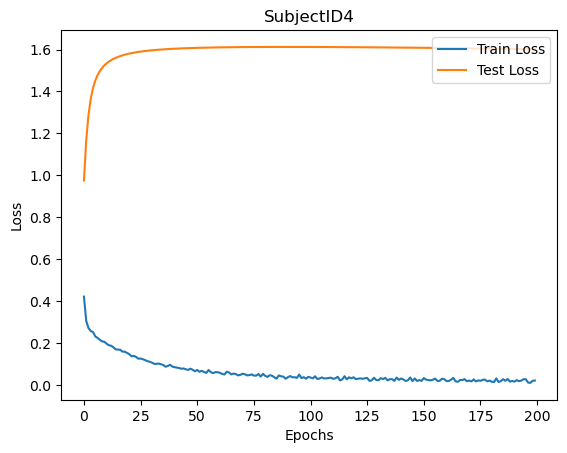

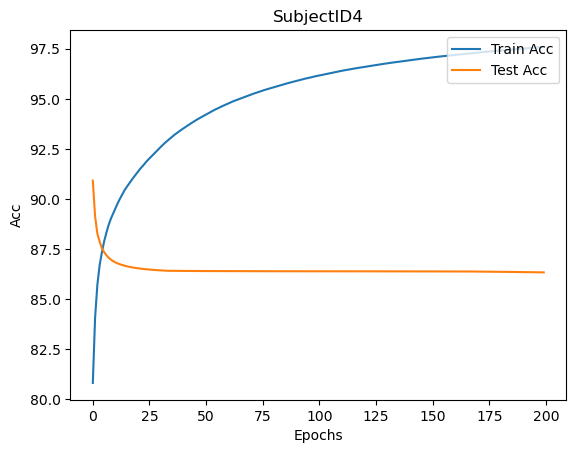


Subject 5
| epoch   0 | 0.3381 s/epoch | train loss 0.3298
| epoch   1 | 0.3366 s/epoch | train loss 0.2493
| epoch   2 | 0.3278 s/epoch | train loss 0.2270
| epoch   3 | 0.3357 s/epoch | train loss 0.2193
| epoch   4 | 0.3344 s/epoch | train loss 0.2002
| epoch   5 | 0.3334 s/epoch | train loss 0.1894
| epoch   6 | 0.3348 s/epoch | train loss 0.1842
| epoch   7 | 0.3356 s/epoch | train loss 0.1798
| epoch   8 | 0.3367 s/epoch | train loss 0.1888
| epoch   9 | 0.3386 s/epoch | train loss 0.1746
| epoch  10 | 0.3328 s/epoch | train loss 0.1614
| epoch  11 | 0.3367 s/epoch | train loss 0.1578
| epoch  12 | 0.3337 s/epoch | train loss 0.1418
| epoch  13 | 0.3326 s/epoch | train loss 0.1436
| epoch  14 | 0.3357 s/epoch | train loss 0.1408
| epoch  15 | 0.3408 s/epoch | train loss 0.1344
| epoch  16 | 0.3388 s/epoch | train loss 0.1317
| epoch  17 | 0.3299 s/epoch | train loss 0.1380
| epoch  18 | 0.3329 s/epoch | train loss 0.3059
| epoch  19 | 0.3373 s/epoch | train loss 0.2753
| epoch  

| epoch 167 | 0.3381 s/epoch | train loss 0.0208
| epoch 168 | 0.3376 s/epoch | train loss 0.0227
| epoch 169 | 0.3389 s/epoch | train loss 0.0195
| epoch 170 | 0.3369 s/epoch | train loss 0.0155
| epoch 171 | 0.3300 s/epoch | train loss 0.0175
| epoch 172 | 0.3281 s/epoch | train loss 0.0190
| epoch 173 | 0.3361 s/epoch | train loss 0.0246
| epoch 174 | 0.3353 s/epoch | train loss 0.0179
| epoch 175 | 0.3376 s/epoch | train loss 0.0219
| epoch 176 | 0.3363 s/epoch | train loss 0.0236
| epoch 177 | 0.3325 s/epoch | train loss 0.0223
| epoch 178 | 0.3340 s/epoch | train loss 0.0174
| epoch 179 | 0.3357 s/epoch | train loss 0.0193
| epoch 180 | 0.3365 s/epoch | train loss 0.0168
| epoch 181 | 0.3378 s/epoch | train loss 0.0161
| epoch 182 | 0.3368 s/epoch | train loss 0.0140
| epoch 183 | 0.3384 s/epoch | train loss 0.0200
| epoch 184 | 0.3382 s/epoch | train loss 0.0189
| epoch 185 | 0.3377 s/epoch | train loss 0.0164
| epoch 186 | 0.3387 s/epoch | train loss 0.0191
| epoch 187 | 0.3330

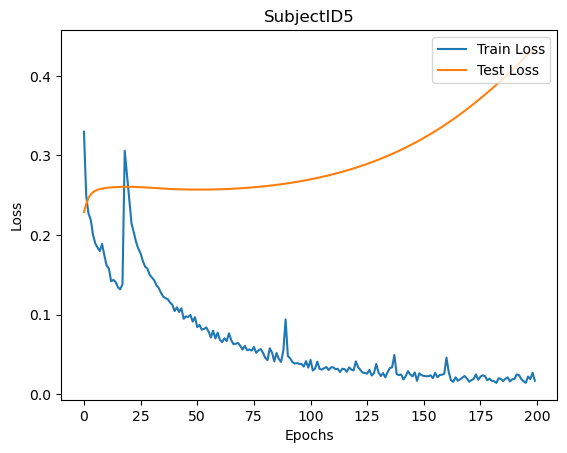

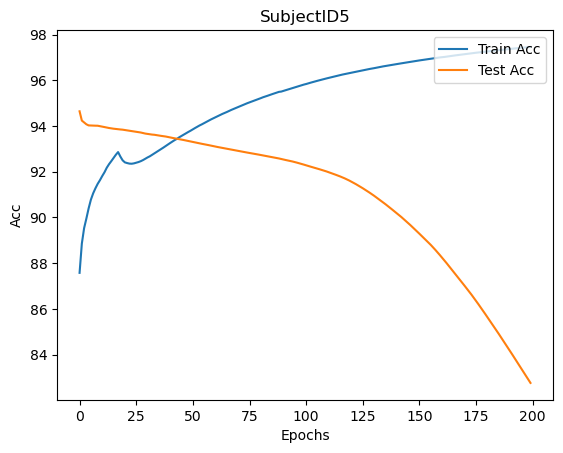

| epoch   0 | 0.0226 s/epoch | train loss 0.4340
| epoch   1 | 0.0199 s/epoch | train loss 0.3163
| epoch   2 | 0.0213 s/epoch | train loss 0.2876
| epoch   3 | 0.0221 s/epoch | train loss 0.2725
| epoch   4 | 0.0221 s/epoch | train loss 0.2603
| epoch   5 | 0.0212 s/epoch | train loss 0.2504
| epoch   6 | 0.0230 s/epoch | train loss 0.2497
| epoch   7 | 0.0217 s/epoch | train loss 0.2323
| epoch   8 | 0.0223 s/epoch | train loss 0.2328
| epoch   9 | 0.0225 s/epoch | train loss 0.2194
| epoch  10 | 0.0227 s/epoch | train loss 0.2160
| epoch  11 | 0.0221 s/epoch | train loss 0.2074
| epoch  12 | 0.0222 s/epoch | train loss 0.1999
| epoch  13 | 0.0217 s/epoch | train loss 0.1977
| epoch  14 | 0.0242 s/epoch | train loss 0.1921
| epoch  15 | 0.0226 s/epoch | train loss 0.1959
| epoch  16 | 0.0217 s/epoch | train loss 0.1861
| epoch  17 | 0.0224 s/epoch | train loss 0.1787
| epoch  18 | 0.0227 s/epoch | train loss 0.1752
| epoch  19 | 0.0207 s/epoch | train loss 0.1691
| epoch  20 | 0.0212

| epoch 168 | 0.0229 s/epoch | train loss 0.0270
| epoch 169 | 0.0238 s/epoch | train loss 0.0312
| epoch 170 | 0.0229 s/epoch | train loss 0.0258
| epoch 171 | 0.0234 s/epoch | train loss 0.0209
| epoch 172 | 0.0244 s/epoch | train loss 0.0293
| epoch 173 | 0.0223 s/epoch | train loss 0.0224
| epoch 174 | 0.0219 s/epoch | train loss 0.0272
| epoch 175 | 0.0224 s/epoch | train loss 0.0176
| epoch 176 | 0.0228 s/epoch | train loss 0.0279
| epoch 177 | 0.0232 s/epoch | train loss 0.0174
| epoch 178 | 0.0226 s/epoch | train loss 0.0268
| epoch 179 | 0.0229 s/epoch | train loss 0.0284
| epoch 180 | 0.0242 s/epoch | train loss 0.0129
| epoch 181 | 0.0243 s/epoch | train loss 0.0189
| epoch 182 | 0.0218 s/epoch | train loss 0.0246
| epoch 183 | 0.0218 s/epoch | train loss 0.0251
| epoch 184 | 0.0240 s/epoch | train loss 0.0291
| epoch 185 | 0.0226 s/epoch | train loss 0.0219
| epoch 186 | 0.0223 s/epoch | train loss 0.0243
| epoch 187 | 0.0232 s/epoch | train loss 0.0218
| epoch 188 | 0.0226

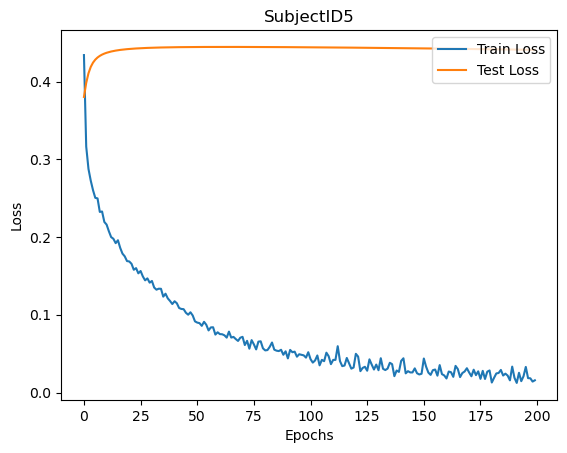

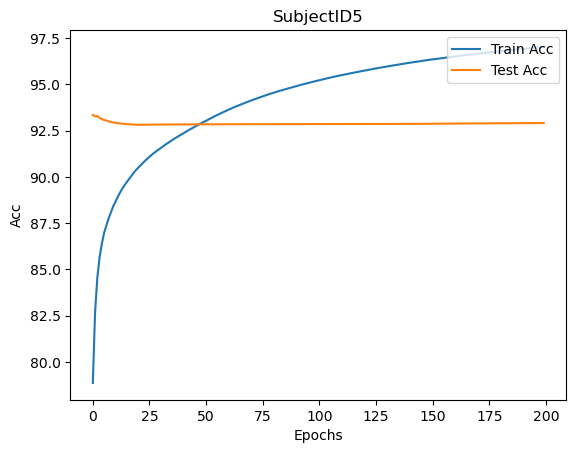


Subject 7
| epoch   0 | 0.3411 s/epoch | train loss 0.3561
| epoch   1 | 0.3339 s/epoch | train loss 0.2495
| epoch   2 | 0.3395 s/epoch | train loss 0.2209
| epoch   3 | 0.3378 s/epoch | train loss 0.2116
| epoch   4 | 0.3340 s/epoch | train loss 0.2064
| epoch   5 | 0.3325 s/epoch | train loss 0.1975
| epoch   6 | 0.3354 s/epoch | train loss 0.1887
| epoch   7 | 0.3369 s/epoch | train loss 0.1854
| epoch   8 | 0.3385 s/epoch | train loss 0.1758
| epoch   9 | 0.3320 s/epoch | train loss 0.1697
| epoch  10 | 0.3335 s/epoch | train loss 0.2359
| epoch  11 | 0.3338 s/epoch | train loss 0.1851
| epoch  12 | 0.3367 s/epoch | train loss 0.1687
| epoch  13 | 0.3352 s/epoch | train loss 0.1609
| epoch  14 | 0.3330 s/epoch | train loss 0.1504
| epoch  15 | 0.3392 s/epoch | train loss 0.1463
| epoch  16 | 0.3439 s/epoch | train loss 0.1454
| epoch  17 | 0.3377 s/epoch | train loss 0.1445
| epoch  18 | 0.3233 s/epoch | train loss 0.1431
| epoch  19 | 0.3332 s/epoch | train loss 0.1416
| epoch  

| epoch 167 | 0.3432 s/epoch | train loss 0.0165
| epoch 168 | 0.3385 s/epoch | train loss 0.0216
| epoch 169 | 0.3353 s/epoch | train loss 0.0237
| epoch 170 | 0.3406 s/epoch | train loss 0.0198
| epoch 171 | 0.3522 s/epoch | train loss 0.0198
| epoch 172 | 0.3563 s/epoch | train loss 0.0234
| epoch 173 | 0.4091 s/epoch | train loss 0.0193
| epoch 174 | 0.3347 s/epoch | train loss 0.0180
| epoch 175 | 0.3405 s/epoch | train loss 0.0139
| epoch 176 | 0.3430 s/epoch | train loss 0.0131
| epoch 177 | 0.3376 s/epoch | train loss 0.0201
| epoch 178 | 0.3440 s/epoch | train loss 0.0174
| epoch 179 | 0.3373 s/epoch | train loss 0.0202
| epoch 180 | 0.3348 s/epoch | train loss 0.0174
| epoch 181 | 0.3343 s/epoch | train loss 0.0218
| epoch 182 | 0.3362 s/epoch | train loss 0.0156
| epoch 183 | 0.3390 s/epoch | train loss 0.0166
| epoch 184 | 0.3424 s/epoch | train loss 0.0207
| epoch 185 | 0.3341 s/epoch | train loss 0.0176
| epoch 186 | 0.3388 s/epoch | train loss 0.0242
| epoch 187 | 0.3394

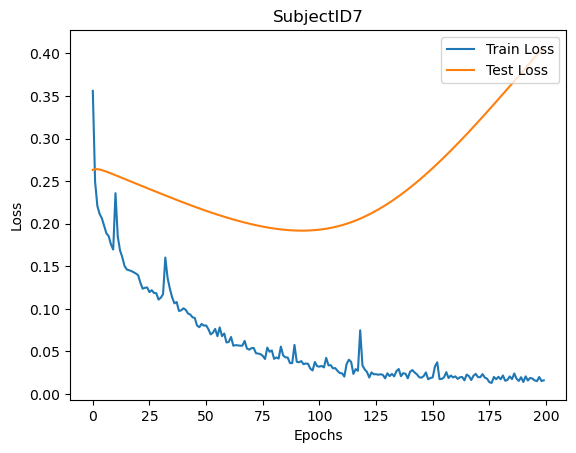

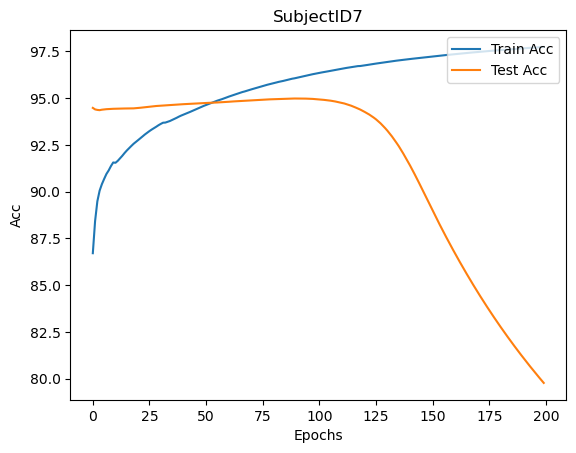

| epoch   0 | 0.0215 s/epoch | train loss 0.4325
| epoch   1 | 0.0232 s/epoch | train loss 0.3036
| epoch   2 | 0.0217 s/epoch | train loss 0.2766
| epoch   3 | 0.0217 s/epoch | train loss 0.2555
| epoch   4 | 0.0234 s/epoch | train loss 0.2510
| epoch   5 | 0.0228 s/epoch | train loss 0.2392
| epoch   6 | 0.0226 s/epoch | train loss 0.2318
| epoch   7 | 0.0230 s/epoch | train loss 0.2183
| epoch   8 | 0.0215 s/epoch | train loss 0.2222
| epoch   9 | 0.0232 s/epoch | train loss 0.2099
| epoch  10 | 0.0215 s/epoch | train loss 0.2074
| epoch  11 | 0.0218 s/epoch | train loss 0.2035
| epoch  12 | 0.0220 s/epoch | train loss 0.1972
| epoch  13 | 0.0227 s/epoch | train loss 0.1845
| epoch  14 | 0.0223 s/epoch | train loss 0.1832
| epoch  15 | 0.0220 s/epoch | train loss 0.1850
| epoch  16 | 0.0222 s/epoch | train loss 0.1765
| epoch  17 | 0.0216 s/epoch | train loss 0.1767
| epoch  18 | 0.0232 s/epoch | train loss 0.1680
| epoch  19 | 0.0233 s/epoch | train loss 0.1647
| epoch  20 | 0.0240

| epoch 168 | 0.0231 s/epoch | train loss 0.0301
| epoch 169 | 0.0207 s/epoch | train loss 0.0201
| epoch 170 | 0.0215 s/epoch | train loss 0.0198
| epoch 171 | 0.0227 s/epoch | train loss 0.0203
| epoch 172 | 0.0230 s/epoch | train loss 0.0245
| epoch 173 | 0.0226 s/epoch | train loss 0.0251
| epoch 174 | 0.0233 s/epoch | train loss 0.0159
| epoch 175 | 0.0224 s/epoch | train loss 0.0125
| epoch 176 | 0.0226 s/epoch | train loss 0.0287
| epoch 177 | 0.0219 s/epoch | train loss 0.0181
| epoch 178 | 0.0237 s/epoch | train loss 0.0181
| epoch 179 | 0.0217 s/epoch | train loss 0.0316
| epoch 180 | 0.0242 s/epoch | train loss 0.0232
| epoch 181 | 0.0226 s/epoch | train loss 0.0164
| epoch 182 | 0.0214 s/epoch | train loss 0.0180
| epoch 183 | 0.0227 s/epoch | train loss 0.0252
| epoch 184 | 0.0222 s/epoch | train loss 0.0141
| epoch 185 | 0.0220 s/epoch | train loss 0.0263
| epoch 186 | 0.0219 s/epoch | train loss 0.0153
| epoch 187 | 0.0219 s/epoch | train loss 0.0211
| epoch 188 | 0.0212

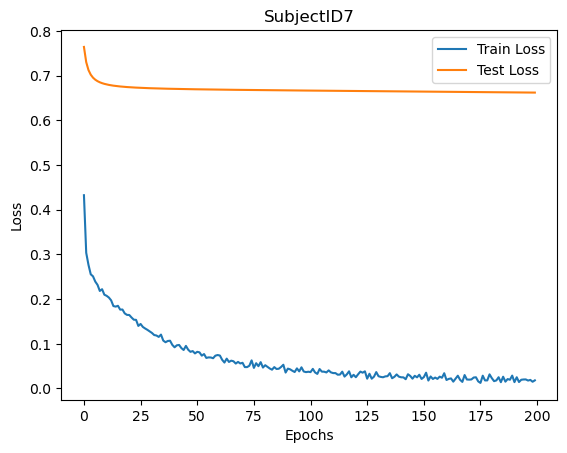

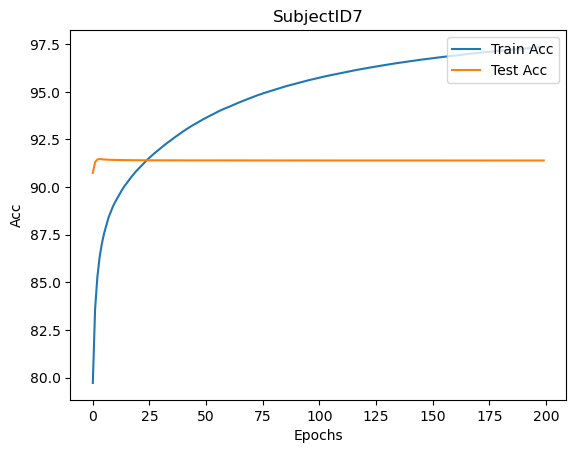


Subject 8
| epoch   0 | 0.3425 s/epoch | train loss 0.3793
| epoch   1 | 0.3397 s/epoch | train loss 0.2723
| epoch   2 | 0.3383 s/epoch | train loss 0.3866
| epoch   3 | 0.3389 s/epoch | train loss 0.2936
| epoch   4 | 0.3509 s/epoch | train loss 0.2502
| epoch   5 | 0.3617 s/epoch | train loss 0.2728
| epoch   6 | 0.3873 s/epoch | train loss 0.3112
| epoch   7 | 0.3792 s/epoch | train loss 0.2462
| epoch   8 | 0.3543 s/epoch | train loss 0.2487
| epoch   9 | 0.3532 s/epoch | train loss 0.2466
| epoch  10 | 0.3864 s/epoch | train loss 0.2851
| epoch  11 | 0.3439 s/epoch | train loss 0.2668
| epoch  12 | 0.3505 s/epoch | train loss 0.2252
| epoch  13 | 0.3417 s/epoch | train loss 0.2018
| epoch  14 | 0.4784 s/epoch | train loss 0.2117
| epoch  15 | 0.4904 s/epoch | train loss 0.1887
| epoch  16 | 0.4737 s/epoch | train loss 0.1778
| epoch  17 | 0.3980 s/epoch | train loss 0.1861
| epoch  18 | 0.5514 s/epoch | train loss 0.1987
| epoch  19 | 0.5052 s/epoch | train loss 0.1740
| epoch  

| epoch 167 | 0.3361 s/epoch | train loss 0.0202
| epoch 168 | 0.4059 s/epoch | train loss 0.0216
| epoch 169 | 0.4299 s/epoch | train loss 0.0328
| epoch 170 | 0.5793 s/epoch | train loss 0.0217
| epoch 171 | 0.3418 s/epoch | train loss 0.0194
| epoch 172 | 0.3722 s/epoch | train loss 0.0173
| epoch 173 | 0.3466 s/epoch | train loss 0.0235
| epoch 174 | 0.3476 s/epoch | train loss 0.0180
| epoch 175 | 0.3501 s/epoch | train loss 0.0238
| epoch 176 | 0.3460 s/epoch | train loss 0.0226
| epoch 177 | 0.6534 s/epoch | train loss 0.0163
| epoch 178 | 0.5927 s/epoch | train loss 0.0230
| epoch 179 | 0.3506 s/epoch | train loss 0.0175
| epoch 180 | 0.3435 s/epoch | train loss 0.0235
| epoch 181 | 0.3370 s/epoch | train loss 0.0179
| epoch 182 | 0.3490 s/epoch | train loss 0.0208
| epoch 183 | 0.3502 s/epoch | train loss 0.0220
| epoch 184 | 0.8903 s/epoch | train loss 0.0258
| epoch 185 | 0.5073 s/epoch | train loss 0.0209
| epoch 186 | 0.3506 s/epoch | train loss 0.0233
| epoch 187 | 0.3229

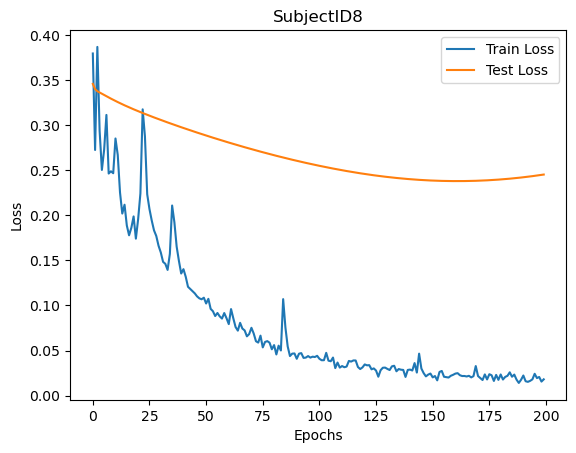

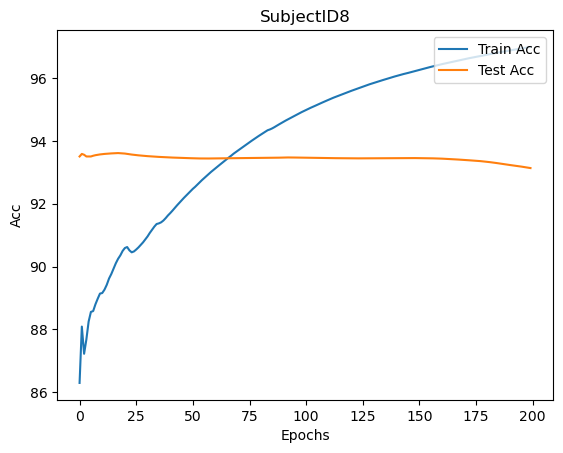

| epoch   0 | 0.0216 s/epoch | train loss 0.4564
| epoch   1 | 0.0220 s/epoch | train loss 0.3236
| epoch   2 | 0.0212 s/epoch | train loss 0.2895
| epoch   3 | 0.0217 s/epoch | train loss 0.2697
| epoch   4 | 0.0215 s/epoch | train loss 0.2599
| epoch   5 | 0.0205 s/epoch | train loss 0.2554
| epoch   6 | 0.0221 s/epoch | train loss 0.2325
| epoch   7 | 0.0219 s/epoch | train loss 0.2296
| epoch   8 | 0.0221 s/epoch | train loss 0.2194
| epoch   9 | 0.0235 s/epoch | train loss 0.2111
| epoch  10 | 0.0226 s/epoch | train loss 0.2023
| epoch  11 | 0.0226 s/epoch | train loss 0.1995
| epoch  12 | 0.0228 s/epoch | train loss 0.1911
| epoch  13 | 0.0214 s/epoch | train loss 0.1836
| epoch  14 | 0.0225 s/epoch | train loss 0.1820
| epoch  15 | 0.0219 s/epoch | train loss 0.1738
| epoch  16 | 0.0212 s/epoch | train loss 0.1720
| epoch  17 | 0.0244 s/epoch | train loss 0.1616
| epoch  18 | 0.0214 s/epoch | train loss 0.1620
| epoch  19 | 0.0204 s/epoch | train loss 0.1581
| epoch  20 | 0.0222

| epoch 168 | 0.0227 s/epoch | train loss 0.0206
| epoch 169 | 0.0231 s/epoch | train loss 0.0278
| epoch 170 | 0.0228 s/epoch | train loss 0.0204
| epoch 171 | 0.0238 s/epoch | train loss 0.0288
| epoch 172 | 0.0223 s/epoch | train loss 0.0315
| epoch 173 | 0.0219 s/epoch | train loss 0.0239
| epoch 174 | 0.0218 s/epoch | train loss 0.0172
| epoch 175 | 0.0224 s/epoch | train loss 0.0213
| epoch 176 | 0.0216 s/epoch | train loss 0.0197
| epoch 177 | 0.0223 s/epoch | train loss 0.0325
| epoch 178 | 0.0236 s/epoch | train loss 0.0196
| epoch 179 | 0.0224 s/epoch | train loss 0.0151
| epoch 180 | 0.0220 s/epoch | train loss 0.0282
| epoch 181 | 0.0228 s/epoch | train loss 0.0258
| epoch 182 | 0.0224 s/epoch | train loss 0.0135
| epoch 183 | 0.0230 s/epoch | train loss 0.0312
| epoch 184 | 0.0222 s/epoch | train loss 0.0250
| epoch 185 | 0.0213 s/epoch | train loss 0.0157
| epoch 186 | 0.0228 s/epoch | train loss 0.0138
| epoch 187 | 0.0214 s/epoch | train loss 0.0251
| epoch 188 | 0.0221

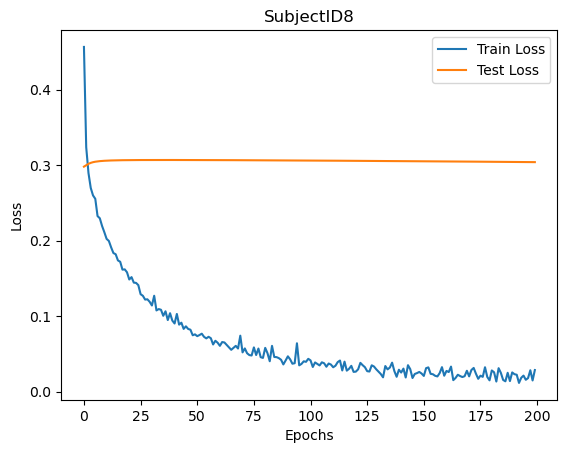

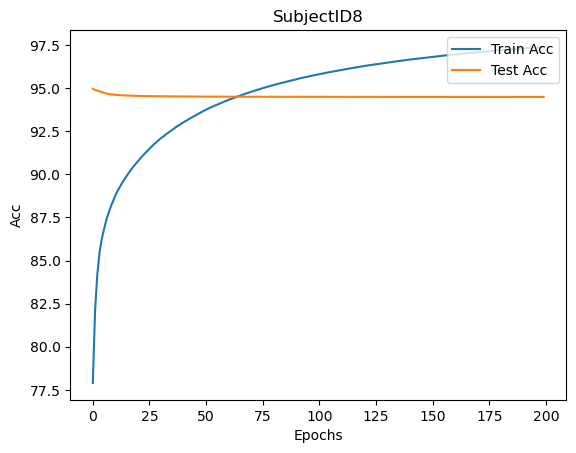


Subject 9
| epoch   0 | 0.3414 s/epoch | train loss 0.3251
| epoch   1 | 0.3533 s/epoch | train loss 0.2427
| epoch   2 | 0.3485 s/epoch | train loss 0.2278
| epoch   3 | 0.3411 s/epoch | train loss 0.2008
| epoch   4 | 0.3645 s/epoch | train loss 0.2099
| epoch   5 | 0.3426 s/epoch | train loss 0.2016
| epoch   6 | 0.3462 s/epoch | train loss 0.1787
| epoch   7 | 0.3409 s/epoch | train loss 0.1707
| epoch   8 | 0.3424 s/epoch | train loss 0.1723
| epoch   9 | 0.3674 s/epoch | train loss 0.1635
| epoch  10 | 0.3569 s/epoch | train loss 0.1576
| epoch  11 | 0.3378 s/epoch | train loss 0.1510
| epoch  12 | 0.3401 s/epoch | train loss 0.1561
| epoch  13 | 0.3428 s/epoch | train loss 0.1487
| epoch  14 | 0.3387 s/epoch | train loss 0.1379
| epoch  15 | 0.3446 s/epoch | train loss 0.1332
| epoch  16 | 0.3237 s/epoch | train loss 0.1331
| epoch  17 | 0.3344 s/epoch | train loss 0.1349
| epoch  18 | 0.3350 s/epoch | train loss 0.1308
| epoch  19 | 0.3297 s/epoch | train loss 0.1263
| epoch  

| epoch 167 | 0.3368 s/epoch | train loss 0.0152
| epoch 168 | 0.3393 s/epoch | train loss 0.0172
| epoch 169 | 0.3383 s/epoch | train loss 0.0208
| epoch 170 | 0.3373 s/epoch | train loss 0.0148
| epoch 171 | 0.3418 s/epoch | train loss 0.0181
| epoch 172 | 0.3357 s/epoch | train loss 0.0190
| epoch 173 | 0.3328 s/epoch | train loss 0.0181
| epoch 174 | 0.3336 s/epoch | train loss 0.0232
| epoch 175 | 0.3403 s/epoch | train loss 0.0149
| epoch 176 | 0.3419 s/epoch | train loss 0.0138
| epoch 177 | 0.3361 s/epoch | train loss 0.0163
| epoch 178 | 0.3383 s/epoch | train loss 0.0199
| epoch 179 | 0.3335 s/epoch | train loss 0.0218
| epoch 180 | 0.3316 s/epoch | train loss 0.0183
| epoch 181 | 0.3291 s/epoch | train loss 0.0169
| epoch 182 | 0.3337 s/epoch | train loss 0.0146
| epoch 183 | 0.3359 s/epoch | train loss 0.0299
| epoch 184 | 0.3385 s/epoch | train loss 0.0194
| epoch 185 | 0.3342 s/epoch | train loss 0.0147
| epoch 186 | 0.3339 s/epoch | train loss 0.0174
| epoch 187 | 0.3366

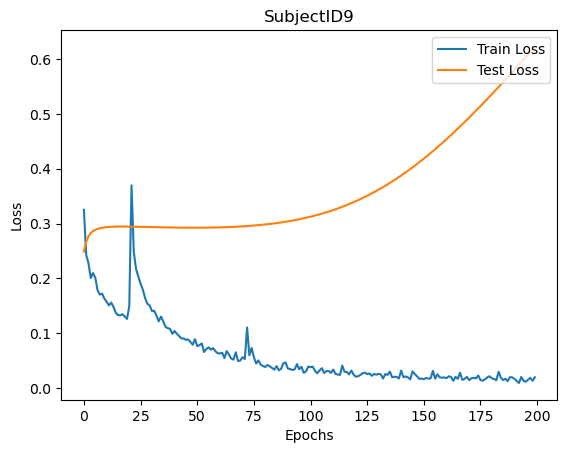

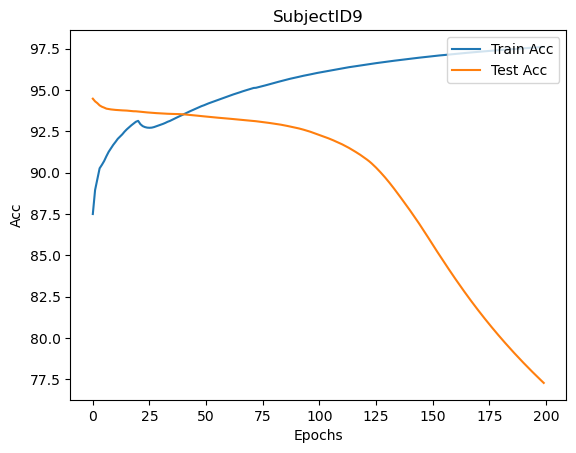

| epoch   0 | 0.0227 s/epoch | train loss 0.4260
| epoch   1 | 0.0210 s/epoch | train loss 0.3243
| epoch   2 | 0.0240 s/epoch | train loss 0.2899
| epoch   3 | 0.0212 s/epoch | train loss 0.2666
| epoch   4 | 0.0218 s/epoch | train loss 0.2504
| epoch   5 | 0.0224 s/epoch | train loss 0.2558
| epoch   6 | 0.0216 s/epoch | train loss 0.2384
| epoch   7 | 0.0227 s/epoch | train loss 0.2273
| epoch   8 | 0.0226 s/epoch | train loss 0.2181
| epoch   9 | 0.0228 s/epoch | train loss 0.2082
| epoch  10 | 0.0243 s/epoch | train loss 0.2043
| epoch  11 | 0.0237 s/epoch | train loss 0.1943
| epoch  12 | 0.0227 s/epoch | train loss 0.1926
| epoch  13 | 0.0225 s/epoch | train loss 0.1807
| epoch  14 | 0.0235 s/epoch | train loss 0.1860
| epoch  15 | 0.0238 s/epoch | train loss 0.1745
| epoch  16 | 0.0227 s/epoch | train loss 0.1757
| epoch  17 | 0.0244 s/epoch | train loss 0.1703
| epoch  18 | 0.0230 s/epoch | train loss 0.1584
| epoch  19 | 0.0225 s/epoch | train loss 0.1552
| epoch  20 | 0.0222

| epoch 168 | 0.0228 s/epoch | train loss 0.0232
| epoch 169 | 0.0220 s/epoch | train loss 0.0255
| epoch 170 | 0.0231 s/epoch | train loss 0.0202
| epoch 171 | 0.0213 s/epoch | train loss 0.0243
| epoch 172 | 0.0220 s/epoch | train loss 0.0157
| epoch 173 | 0.0222 s/epoch | train loss 0.0257
| epoch 174 | 0.0227 s/epoch | train loss 0.0282
| epoch 175 | 0.0215 s/epoch | train loss 0.0207
| epoch 176 | 0.0234 s/epoch | train loss 0.0166
| epoch 177 | 0.0235 s/epoch | train loss 0.0159
| epoch 178 | 0.0220 s/epoch | train loss 0.0293
| epoch 179 | 0.0213 s/epoch | train loss 0.0239
| epoch 180 | 0.0216 s/epoch | train loss 0.0254
| epoch 181 | 0.0226 s/epoch | train loss 0.0130
| epoch 182 | 0.0223 s/epoch | train loss 0.0155
| epoch 183 | 0.0220 s/epoch | train loss 0.0188
| epoch 184 | 0.0229 s/epoch | train loss 0.0199
| epoch 185 | 0.0235 s/epoch | train loss 0.0188
| epoch 186 | 0.0235 s/epoch | train loss 0.0248
| epoch 187 | 0.0222 s/epoch | train loss 0.0268
| epoch 188 | 0.0217

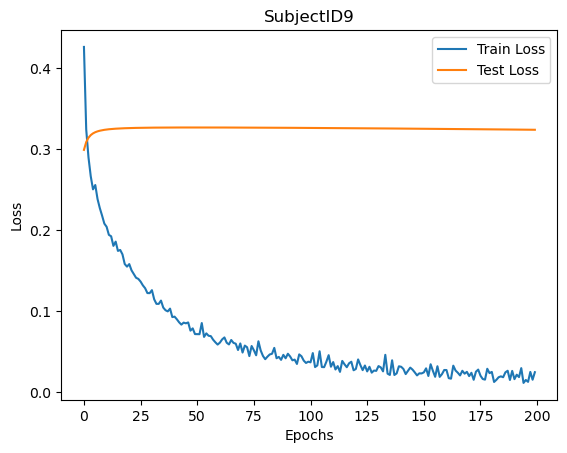

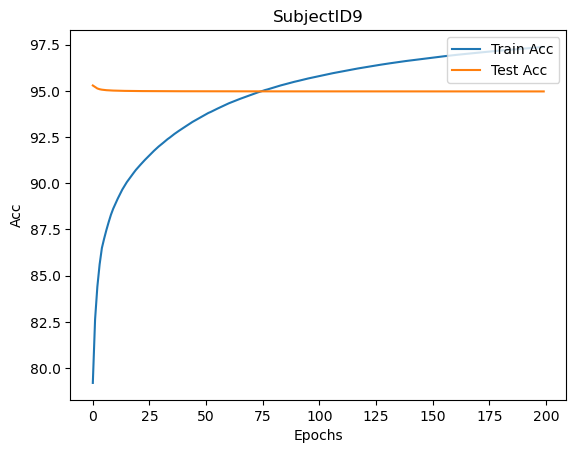


Subject 10
| epoch   0 | 0.3476 s/epoch | train loss 0.3534
| epoch   1 | 0.3332 s/epoch | train loss 0.2433
| epoch   2 | 0.3328 s/epoch | train loss 0.2349
| epoch   3 | 0.3361 s/epoch | train loss 0.2154
| epoch   4 | 0.3340 s/epoch | train loss 0.2174
| epoch   5 | 0.3387 s/epoch | train loss 0.1918
| epoch   6 | 0.3374 s/epoch | train loss 0.1813
| epoch   7 | 0.3419 s/epoch | train loss 0.1810
| epoch   8 | 0.3421 s/epoch | train loss 0.1665
| epoch   9 | 0.3364 s/epoch | train loss 0.1696
| epoch  10 | 0.3424 s/epoch | train loss 0.1595
| epoch  11 | 0.3367 s/epoch | train loss 0.1595
| epoch  12 | 0.3340 s/epoch | train loss 0.1625
| epoch  13 | 0.3358 s/epoch | train loss 0.3247
| epoch  14 | 0.3408 s/epoch | train loss 0.3524
| epoch  15 | 0.3357 s/epoch | train loss 0.2733
| epoch  16 | 0.3374 s/epoch | train loss 0.2984
| epoch  17 | 0.3394 s/epoch | train loss 0.2308
| epoch  18 | 0.3395 s/epoch | train loss 0.2066
| epoch  19 | 0.3376 s/epoch | train loss 0.2011
| epoch 

| epoch 167 | 0.3987 s/epoch | train loss 0.0252
| epoch 168 | 0.4142 s/epoch | train loss 0.0195
| epoch 169 | 0.4312 s/epoch | train loss 0.0176
| epoch 170 | 0.3929 s/epoch | train loss 0.0212
| epoch 171 | 0.3842 s/epoch | train loss 0.0186
| epoch 172 | 0.4102 s/epoch | train loss 0.0184
| epoch 173 | 0.4100 s/epoch | train loss 0.0171
| epoch 174 | 0.4096 s/epoch | train loss 0.0222
| epoch 175 | 0.3704 s/epoch | train loss 0.0181
| epoch 176 | 0.4296 s/epoch | train loss 0.0433
| epoch 177 | 0.4331 s/epoch | train loss 0.0228
| epoch 178 | 0.4351 s/epoch | train loss 0.0182
| epoch 179 | 0.3885 s/epoch | train loss 0.0206
| epoch 180 | 0.3857 s/epoch | train loss 0.0169
| epoch 181 | 0.4052 s/epoch | train loss 0.0144
| epoch 182 | 0.4061 s/epoch | train loss 0.0143
| epoch 183 | 0.3872 s/epoch | train loss 0.0163
| epoch 184 | 0.3888 s/epoch | train loss 0.0152
| epoch 185 | 0.3615 s/epoch | train loss 0.0120
| epoch 186 | 0.3890 s/epoch | train loss 0.0165
| epoch 187 | 0.3964

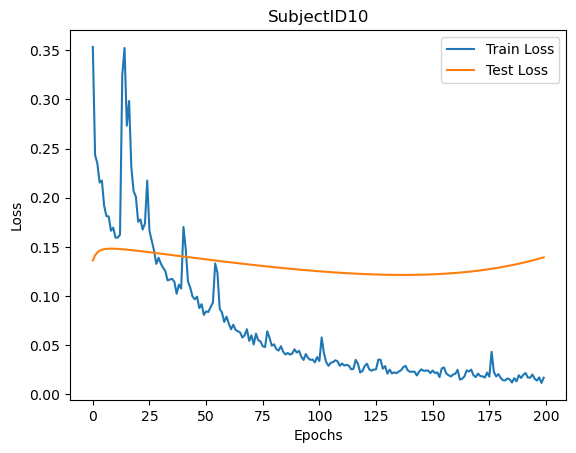

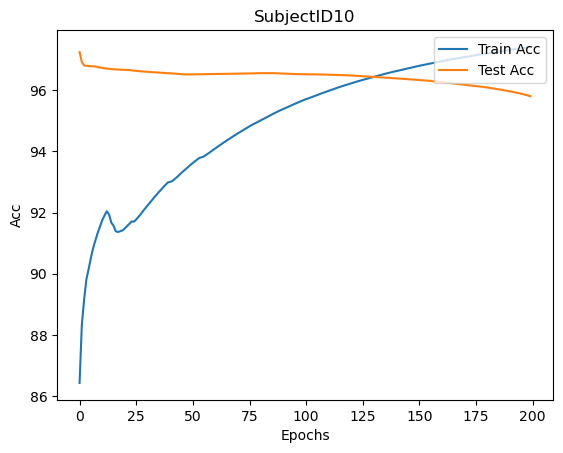

| epoch   0 | 0.0300 s/epoch | train loss 0.4359
| epoch   1 | 0.0355 s/epoch | train loss 0.2999
| epoch   2 | 0.0358 s/epoch | train loss 0.2757
| epoch   3 | 0.0337 s/epoch | train loss 0.2636
| epoch   4 | 0.0266 s/epoch | train loss 0.2447
| epoch   5 | 0.0336 s/epoch | train loss 0.2380
| epoch   6 | 0.0525 s/epoch | train loss 0.2340
| epoch   7 | 0.0289 s/epoch | train loss 0.2223
| epoch   8 | 0.0320 s/epoch | train loss 0.2190
| epoch   9 | 0.0365 s/epoch | train loss 0.2182
| epoch  10 | 0.0284 s/epoch | train loss 0.2050
| epoch  11 | 0.0319 s/epoch | train loss 0.2038
| epoch  12 | 0.0356 s/epoch | train loss 0.1939
| epoch  13 | 0.0365 s/epoch | train loss 0.1958
| epoch  14 | 0.0355 s/epoch | train loss 0.1878
| epoch  15 | 0.0272 s/epoch | train loss 0.1834
| epoch  16 | 0.0485 s/epoch | train loss 0.1842
| epoch  17 | 0.0348 s/epoch | train loss 0.1711
| epoch  18 | 0.0361 s/epoch | train loss 0.1682
| epoch  19 | 0.0280 s/epoch | train loss 0.1703
| epoch  20 | 0.0316

| epoch 168 | 0.0378 s/epoch | train loss 0.0245
| epoch 169 | 0.0351 s/epoch | train loss 0.0179
| epoch 170 | 0.0375 s/epoch | train loss 0.0156
| epoch 171 | 0.0267 s/epoch | train loss 0.0290
| epoch 172 | 0.0329 s/epoch | train loss 0.0231
| epoch 173 | 0.0365 s/epoch | train loss 0.0369
| epoch 174 | 0.0386 s/epoch | train loss 0.0204
| epoch 175 | 0.0458 s/epoch | train loss 0.0170
| epoch 176 | 0.0316 s/epoch | train loss 0.0198
| epoch 177 | 0.0375 s/epoch | train loss 0.0202
| epoch 178 | 0.0363 s/epoch | train loss 0.0245
| epoch 179 | 0.0345 s/epoch | train loss 0.0321
| epoch 180 | 0.0300 s/epoch | train loss 0.0209
| epoch 181 | 0.0350 s/epoch | train loss 0.0208
| epoch 182 | 0.0328 s/epoch | train loss 0.0203
| epoch 183 | 0.0352 s/epoch | train loss 0.0283
| epoch 184 | 0.0462 s/epoch | train loss 0.0251
| epoch 185 | 0.0308 s/epoch | train loss 0.0156
| epoch 186 | 0.0349 s/epoch | train loss 0.0197
| epoch 187 | 0.0370 s/epoch | train loss 0.0301
| epoch 188 | 0.0350

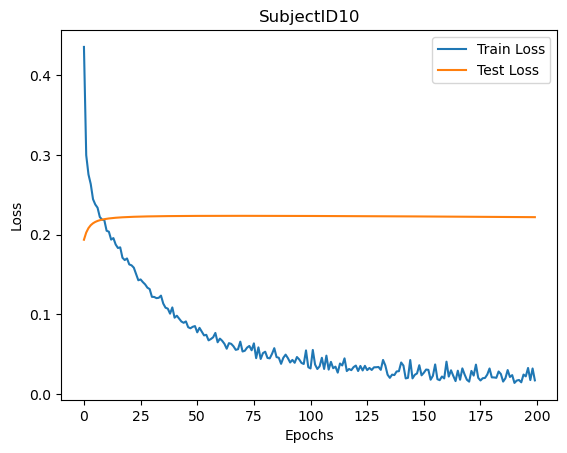

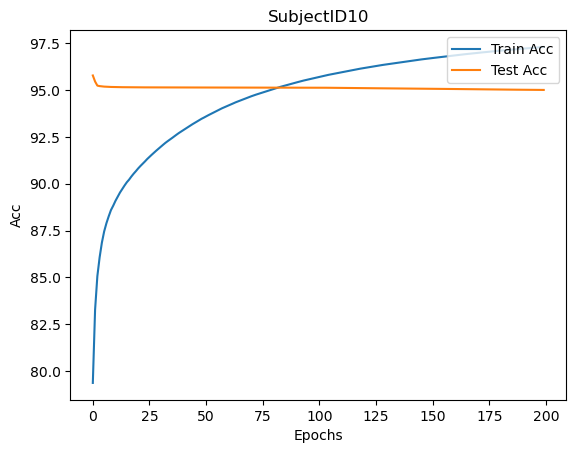


Subject 11
| epoch   0 | 0.4137 s/epoch | train loss 0.3575
| epoch   1 | 0.4551 s/epoch | train loss 0.2509
| epoch   2 | 0.4226 s/epoch | train loss 0.2236
| epoch   3 | 0.4356 s/epoch | train loss 0.2041
| epoch   4 | 0.4349 s/epoch | train loss 0.1926
| epoch   5 | 0.4311 s/epoch | train loss 0.2302
| epoch   6 | 0.4324 s/epoch | train loss 0.2281
| epoch   7 | 0.4157 s/epoch | train loss 0.1950
| epoch   8 | 0.4380 s/epoch | train loss 0.1853
| epoch   9 | 0.4238 s/epoch | train loss 0.1737
| epoch  10 | 0.4223 s/epoch | train loss 0.1731
| epoch  11 | 0.4209 s/epoch | train loss 0.1538
| epoch  12 | 0.4632 s/epoch | train loss 0.1562
| epoch  13 | 0.4360 s/epoch | train loss 0.1451
| epoch  14 | 0.4815 s/epoch | train loss 0.1455
| epoch  15 | 0.4552 s/epoch | train loss 0.1365
| epoch  16 | 0.4539 s/epoch | train loss 0.1395
| epoch  17 | 0.4578 s/epoch | train loss 0.1313
| epoch  18 | 0.4634 s/epoch | train loss 0.1312
| epoch  19 | 0.4747 s/epoch | train loss 0.1245
| epoch 

| epoch 167 | 0.4422 s/epoch | train loss 0.0138
| epoch 168 | 0.4430 s/epoch | train loss 0.0190
| epoch 169 | 0.4428 s/epoch | train loss 0.0169
| epoch 170 | 0.4259 s/epoch | train loss 0.0174
| epoch 171 | 0.4187 s/epoch | train loss 0.0209
| epoch 172 | 0.4095 s/epoch | train loss 0.0149
| epoch 173 | 0.4246 s/epoch | train loss 0.0159
| epoch 174 | 0.4189 s/epoch | train loss 0.0132
| epoch 175 | 0.4223 s/epoch | train loss 0.0221
| epoch 176 | 0.4252 s/epoch | train loss 0.0183
| epoch 177 | 0.4269 s/epoch | train loss 0.0197
| epoch 178 | 0.4238 s/epoch | train loss 0.0220
| epoch 179 | 0.4016 s/epoch | train loss 0.0188
| epoch 180 | 0.4281 s/epoch | train loss 0.0142
| epoch 181 | 0.4073 s/epoch | train loss 0.0158
| epoch 182 | 0.4198 s/epoch | train loss 0.0150
| epoch 183 | 0.4233 s/epoch | train loss 0.0156
| epoch 184 | 0.4026 s/epoch | train loss 0.0170
| epoch 185 | 0.4566 s/epoch | train loss 0.0161
| epoch 186 | 0.4741 s/epoch | train loss 0.0160
| epoch 187 | 0.4750

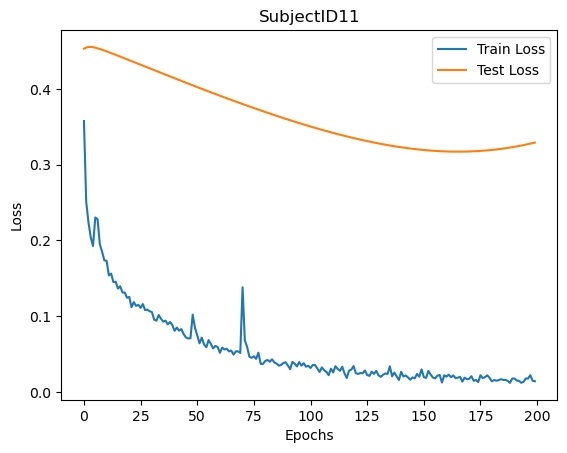

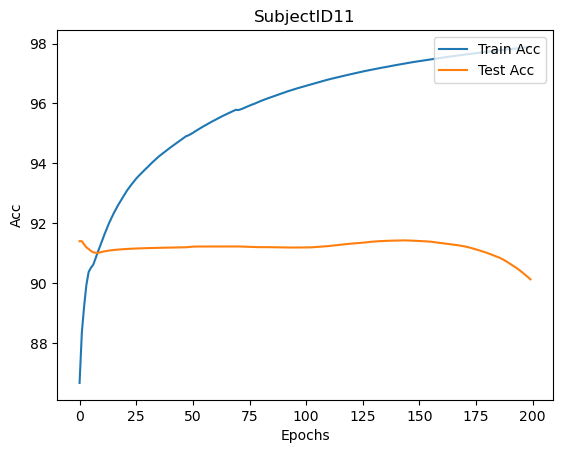

| epoch   0 | 0.0287 s/epoch | train loss 0.4222
| epoch   1 | 0.0367 s/epoch | train loss 0.3017
| epoch   2 | 0.0360 s/epoch | train loss 0.2839
| epoch   3 | 0.0359 s/epoch | train loss 0.2677
| epoch   4 | 0.0567 s/epoch | train loss 0.2523
| epoch   5 | 0.0355 s/epoch | train loss 0.2493
| epoch   6 | 0.0417 s/epoch | train loss 0.2416
| epoch   7 | 0.0293 s/epoch | train loss 0.2314
| epoch   8 | 0.0350 s/epoch | train loss 0.2306
| epoch   9 | 0.0333 s/epoch | train loss 0.2163
| epoch  10 | 0.0364 s/epoch | train loss 0.2095
| epoch  11 | 0.0310 s/epoch | train loss 0.2027
| epoch  12 | 0.0501 s/epoch | train loss 0.2009
| epoch  13 | 0.0374 s/epoch | train loss 0.1946
| epoch  14 | 0.0310 s/epoch | train loss 0.1865
| epoch  15 | 0.0366 s/epoch | train loss 0.1813
| epoch  16 | 0.0313 s/epoch | train loss 0.1847
| epoch  17 | 0.0364 s/epoch | train loss 0.1730
| epoch  18 | 0.0481 s/epoch | train loss 0.1710
| epoch  19 | 0.0285 s/epoch | train loss 0.1625
| epoch  20 | 0.0318

| epoch 168 | 0.0285 s/epoch | train loss 0.0166
| epoch 169 | 0.0185 s/epoch | train loss 0.0356
| epoch 170 | 0.0282 s/epoch | train loss 0.0228
| epoch 171 | 0.0292 s/epoch | train loss 0.0167
| epoch 172 | 0.0163 s/epoch | train loss 0.0274
| epoch 173 | 0.0276 s/epoch | train loss 0.0198
| epoch 174 | 0.0267 s/epoch | train loss 0.0161
| epoch 175 | 0.0262 s/epoch | train loss 0.0272
| epoch 176 | 0.0262 s/epoch | train loss 0.0205
| epoch 177 | 0.0261 s/epoch | train loss 0.0216
| epoch 178 | 0.0273 s/epoch | train loss 0.0186
| epoch 179 | 0.0191 s/epoch | train loss 0.0144
| epoch 180 | 0.0275 s/epoch | train loss 0.0241
| epoch 181 | 0.0261 s/epoch | train loss 0.0173
| epoch 182 | 0.0263 s/epoch | train loss 0.0179
| epoch 183 | 0.0273 s/epoch | train loss 0.0204
| epoch 184 | 0.0187 s/epoch | train loss 0.0156
| epoch 185 | 0.0265 s/epoch | train loss 0.0251
| epoch 186 | 0.0285 s/epoch | train loss 0.0243
| epoch 187 | 0.0299 s/epoch | train loss 0.0195
| epoch 188 | 0.0191

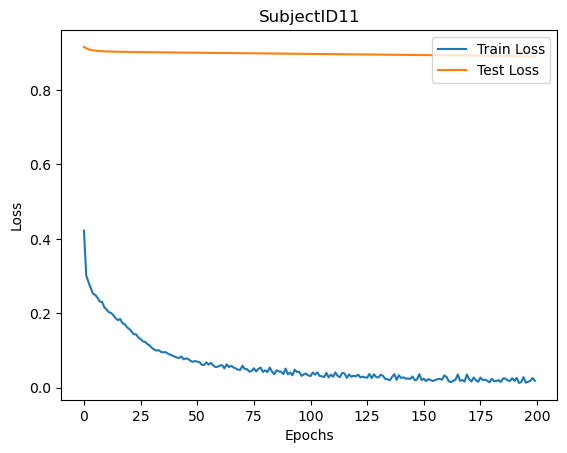

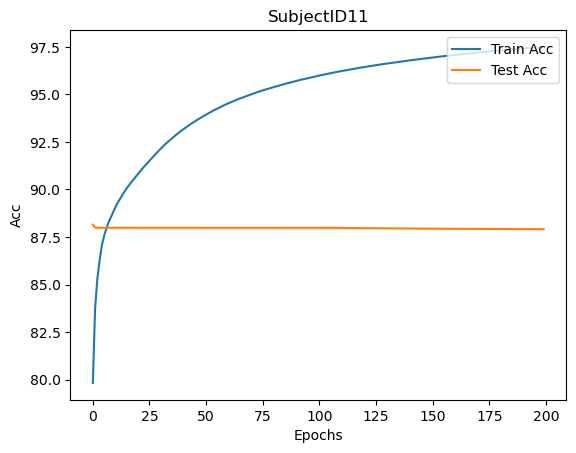


Subject 12
| epoch   0 | 0.3514 s/epoch | train loss 0.3234
| epoch   1 | 0.3417 s/epoch | train loss 0.2407
| epoch   2 | 0.3503 s/epoch | train loss 0.2174
| epoch   3 | 0.3374 s/epoch | train loss 0.2762
| epoch   4 | 0.3413 s/epoch | train loss 0.2264
| epoch   5 | 0.3533 s/epoch | train loss 0.2064
| epoch   6 | 0.3427 s/epoch | train loss 0.2013
| epoch   7 | 0.3553 s/epoch | train loss 0.1923
| epoch   8 | 0.3456 s/epoch | train loss 0.1814
| epoch   9 | 0.3483 s/epoch | train loss 0.1701
| epoch  10 | 0.3523 s/epoch | train loss 0.1670
| epoch  11 | 0.3437 s/epoch | train loss 0.1599
| epoch  12 | 0.3386 s/epoch | train loss 0.1583
| epoch  13 | 0.3588 s/epoch | train loss 0.1519
| epoch  14 | 0.3443 s/epoch | train loss 0.1490
| epoch  15 | 0.3418 s/epoch | train loss 0.1387
| epoch  16 | 0.3362 s/epoch | train loss 0.1425
| epoch  17 | 0.3388 s/epoch | train loss 0.1348
| epoch  18 | 0.3396 s/epoch | train loss 0.1308
| epoch  19 | 0.3353 s/epoch | train loss 0.1289
| epoch 

| epoch 167 | 0.3408 s/epoch | train loss 0.0256
| epoch 168 | 0.3284 s/epoch | train loss 0.0203
| epoch 169 | 0.3342 s/epoch | train loss 0.0179
| epoch 170 | 0.3308 s/epoch | train loss 0.0166
| epoch 171 | 0.3310 s/epoch | train loss 0.0168
| epoch 172 | 0.3317 s/epoch | train loss 0.0160
| epoch 173 | 0.3352 s/epoch | train loss 0.0264
| epoch 174 | 0.3337 s/epoch | train loss 0.0225
| epoch 175 | 0.3353 s/epoch | train loss 0.0265
| epoch 176 | 0.3330 s/epoch | train loss 0.0267
| epoch 177 | 0.3311 s/epoch | train loss 0.0193
| epoch 178 | 0.3374 s/epoch | train loss 0.0179
| epoch 179 | 0.3430 s/epoch | train loss 0.0180
| epoch 180 | 0.3398 s/epoch | train loss 0.0223
| epoch 181 | 0.3375 s/epoch | train loss 0.0168
| epoch 182 | 0.3305 s/epoch | train loss 0.0170
| epoch 183 | 0.3364 s/epoch | train loss 0.0140
| epoch 184 | 0.3344 s/epoch | train loss 0.0139
| epoch 185 | 0.3352 s/epoch | train loss 0.0216
| epoch 186 | 0.3367 s/epoch | train loss 0.0235
| epoch 187 | 0.3359

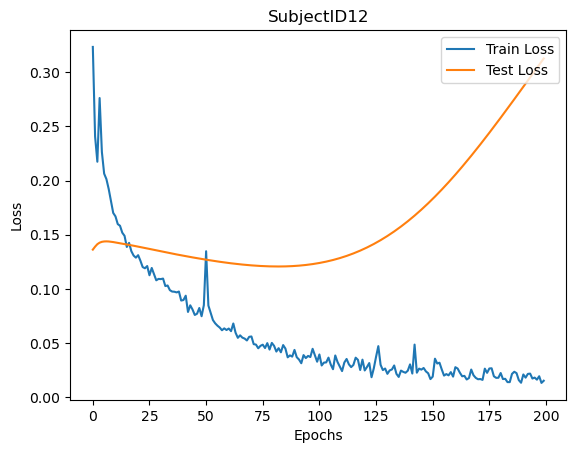

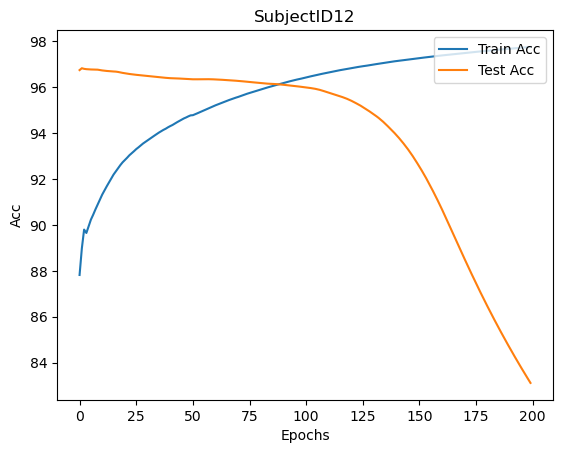

| epoch   0 | 0.0219 s/epoch | train loss 0.4286
| epoch   1 | 0.0233 s/epoch | train loss 0.3055
| epoch   2 | 0.0214 s/epoch | train loss 0.2763
| epoch   3 | 0.0223 s/epoch | train loss 0.2613
| epoch   4 | 0.0216 s/epoch | train loss 0.2447
| epoch   5 | 0.0224 s/epoch | train loss 0.2335
| epoch   6 | 0.0216 s/epoch | train loss 0.2285
| epoch   7 | 0.0233 s/epoch | train loss 0.2211
| epoch   8 | 0.0225 s/epoch | train loss 0.2103
| epoch   9 | 0.0237 s/epoch | train loss 0.2039
| epoch  10 | 0.0222 s/epoch | train loss 0.1984
| epoch  11 | 0.0230 s/epoch | train loss 0.1942
| epoch  12 | 0.0217 s/epoch | train loss 0.1914
| epoch  13 | 0.0218 s/epoch | train loss 0.1958
| epoch  14 | 0.0221 s/epoch | train loss 0.1799
| epoch  15 | 0.0231 s/epoch | train loss 0.1737
| epoch  16 | 0.0217 s/epoch | train loss 0.1699
| epoch  17 | 0.0222 s/epoch | train loss 0.1654
| epoch  18 | 0.0220 s/epoch | train loss 0.1598
| epoch  19 | 0.0227 s/epoch | train loss 0.1574
| epoch  20 | 0.0209

| epoch 168 | 0.0233 s/epoch | train loss 0.0237
| epoch 169 | 0.0213 s/epoch | train loss 0.0144
| epoch 170 | 0.0228 s/epoch | train loss 0.0283
| epoch 171 | 0.0225 s/epoch | train loss 0.0177
| epoch 172 | 0.0224 s/epoch | train loss 0.0199
| epoch 173 | 0.0232 s/epoch | train loss 0.0270
| epoch 174 | 0.0216 s/epoch | train loss 0.0169
| epoch 175 | 0.0239 s/epoch | train loss 0.0326
| epoch 176 | 0.0213 s/epoch | train loss 0.0157
| epoch 177 | 0.0223 s/epoch | train loss 0.0262
| epoch 178 | 0.0213 s/epoch | train loss 0.0196
| epoch 179 | 0.0215 s/epoch | train loss 0.0243
| epoch 180 | 0.0223 s/epoch | train loss 0.0209
| epoch 181 | 0.0217 s/epoch | train loss 0.0186
| epoch 182 | 0.0226 s/epoch | train loss 0.0155
| epoch 183 | 0.0227 s/epoch | train loss 0.0283
| epoch 184 | 0.0214 s/epoch | train loss 0.0145
| epoch 185 | 0.0221 s/epoch | train loss 0.0136
| epoch 186 | 0.0228 s/epoch | train loss 0.0245
| epoch 187 | 0.0225 s/epoch | train loss 0.0138
| epoch 188 | 0.0211

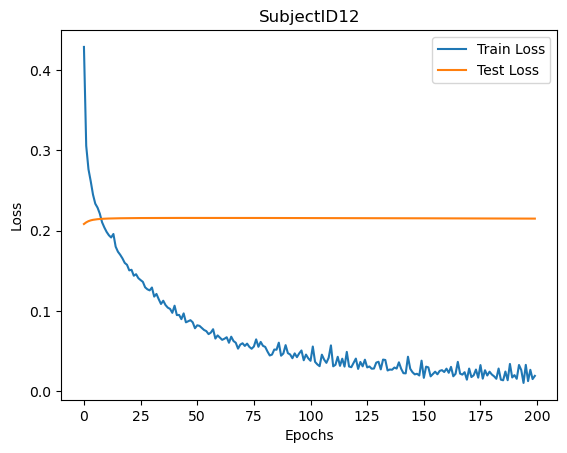

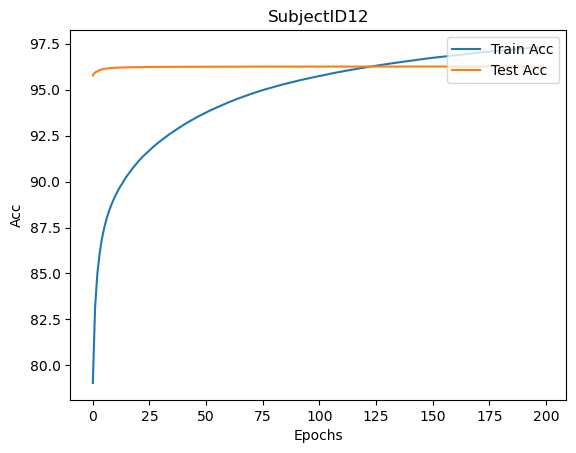


Subject 13
| epoch   0 | 0.3383 s/epoch | train loss 0.3901
| epoch   1 | 0.3332 s/epoch | train loss 0.3157
| epoch   2 | 0.3346 s/epoch | train loss 0.2798
| epoch   3 | 0.3352 s/epoch | train loss 0.2848
| epoch   4 | 0.3377 s/epoch | train loss 0.2825
| epoch   5 | 0.3360 s/epoch | train loss 0.3195
| epoch   6 | 0.3261 s/epoch | train loss 0.2531
| epoch   7 | 0.3301 s/epoch | train loss 0.2518
| epoch   8 | 0.3310 s/epoch | train loss 0.3774
| epoch   9 | 0.3326 s/epoch | train loss 0.2334
| epoch  10 | 0.3312 s/epoch | train loss 0.2284
| epoch  11 | 0.3350 s/epoch | train loss 0.2149
| epoch  12 | 0.3361 s/epoch | train loss 0.2145
| epoch  13 | 0.3343 s/epoch | train loss 0.2068
| epoch  14 | 0.3337 s/epoch | train loss 0.2195
| epoch  15 | 0.3336 s/epoch | train loss 0.1944
| epoch  16 | 0.3345 s/epoch | train loss 0.1899
| epoch  17 | 0.3355 s/epoch | train loss 0.2155
| epoch  18 | 0.3352 s/epoch | train loss 0.2058
| epoch  19 | 0.3370 s/epoch | train loss 0.2776
| epoch 

| epoch 167 | 0.3372 s/epoch | train loss 0.0204
| epoch 168 | 0.3335 s/epoch | train loss 0.0249
| epoch 169 | 0.3322 s/epoch | train loss 0.0226
| epoch 170 | 0.3287 s/epoch | train loss 0.0180
| epoch 171 | 0.3329 s/epoch | train loss 0.0245
| epoch 172 | 0.3344 s/epoch | train loss 0.0258
| epoch 173 | 0.3337 s/epoch | train loss 0.0240
| epoch 174 | 0.3281 s/epoch | train loss 0.0284
| epoch 175 | 0.3359 s/epoch | train loss 0.0154
| epoch 176 | 0.3344 s/epoch | train loss 0.0239
| epoch 177 | 0.3386 s/epoch | train loss 0.0195
| epoch 178 | 0.3344 s/epoch | train loss 0.0254
| epoch 179 | 0.3381 s/epoch | train loss 0.0234
| epoch 180 | 0.3374 s/epoch | train loss 0.0216
| epoch 181 | 0.3355 s/epoch | train loss 0.0190
| epoch 182 | 0.3392 s/epoch | train loss 0.0213
| epoch 183 | 0.3363 s/epoch | train loss 0.0292
| epoch 184 | 0.3354 s/epoch | train loss 0.0132
| epoch 185 | 0.3219 s/epoch | train loss 0.0266
| epoch 186 | 0.3389 s/epoch | train loss 0.0210
| epoch 187 | 0.3330

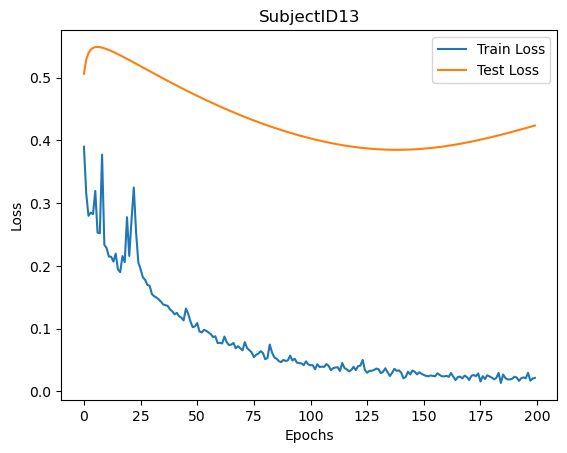

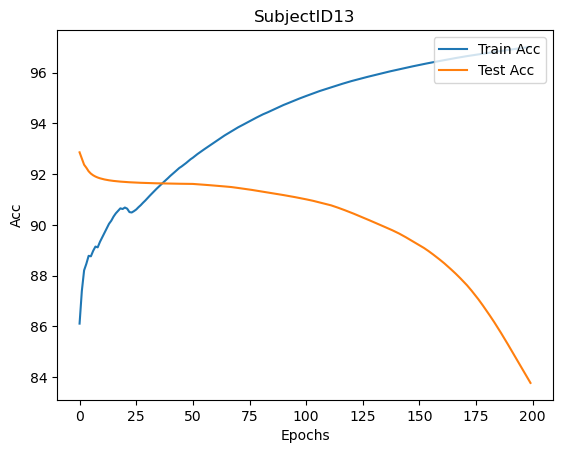

| epoch   0 | 0.0208 s/epoch | train loss 0.4465
| epoch   1 | 0.0230 s/epoch | train loss 0.3171
| epoch   2 | 0.0213 s/epoch | train loss 0.2761
| epoch   3 | 0.0220 s/epoch | train loss 0.2578
| epoch   4 | 0.0206 s/epoch | train loss 0.2474
| epoch   5 | 0.0219 s/epoch | train loss 0.2419
| epoch   6 | 0.0228 s/epoch | train loss 0.2338
| epoch   7 | 0.0211 s/epoch | train loss 0.2250
| epoch   8 | 0.0219 s/epoch | train loss 0.2255
| epoch   9 | 0.0216 s/epoch | train loss 0.2103
| epoch  10 | 0.0222 s/epoch | train loss 0.2071
| epoch  11 | 0.0231 s/epoch | train loss 0.2020
| epoch  12 | 0.0201 s/epoch | train loss 0.2004
| epoch  13 | 0.0230 s/epoch | train loss 0.1955
| epoch  14 | 0.0211 s/epoch | train loss 0.1992
| epoch  15 | 0.0236 s/epoch | train loss 0.1903
| epoch  16 | 0.0216 s/epoch | train loss 0.1848
| epoch  17 | 0.0215 s/epoch | train loss 0.1838
| epoch  18 | 0.0226 s/epoch | train loss 0.1785
| epoch  19 | 0.0219 s/epoch | train loss 0.1716
| epoch  20 | 0.0228

| epoch 168 | 0.0212 s/epoch | train loss 0.0195
| epoch 169 | 0.0226 s/epoch | train loss 0.0247
| epoch 170 | 0.0218 s/epoch | train loss 0.0198
| epoch 171 | 0.0226 s/epoch | train loss 0.0381
| epoch 172 | 0.0220 s/epoch | train loss 0.0231
| epoch 173 | 0.0231 s/epoch | train loss 0.0167
| epoch 174 | 0.0219 s/epoch | train loss 0.0310
| epoch 175 | 0.0232 s/epoch | train loss 0.0213
| epoch 176 | 0.0235 s/epoch | train loss 0.0215
| epoch 177 | 0.0217 s/epoch | train loss 0.0249
| epoch 178 | 0.0218 s/epoch | train loss 0.0272
| epoch 179 | 0.0218 s/epoch | train loss 0.0277
| epoch 180 | 0.0231 s/epoch | train loss 0.0244
| epoch 181 | 0.0229 s/epoch | train loss 0.0174
| epoch 182 | 0.0226 s/epoch | train loss 0.0233
| epoch 183 | 0.0216 s/epoch | train loss 0.0202
| epoch 184 | 0.0215 s/epoch | train loss 0.0372
| epoch 185 | 0.0236 s/epoch | train loss 0.0210
| epoch 186 | 0.0223 s/epoch | train loss 0.0202
| epoch 187 | 0.0221 s/epoch | train loss 0.0243
| epoch 188 | 0.0225

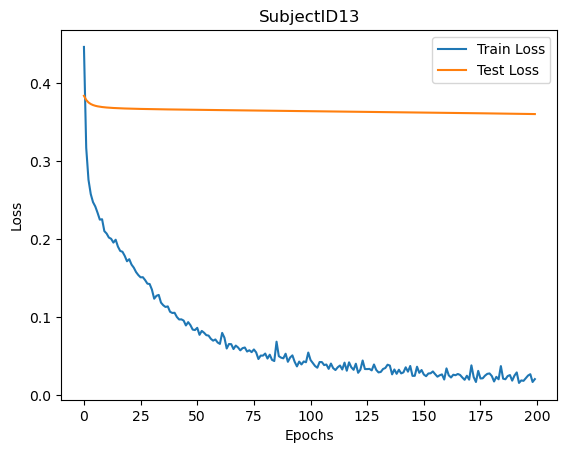

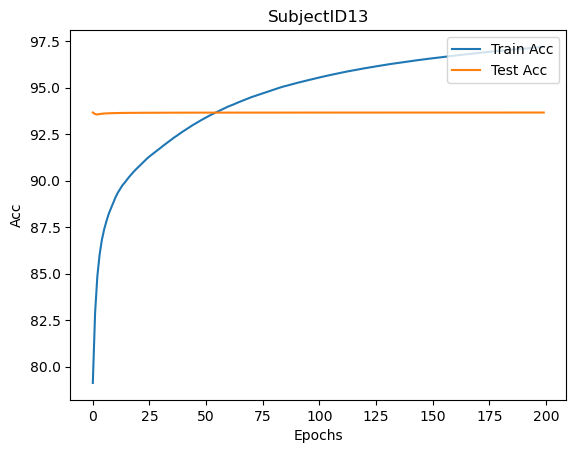


Subject 14
| epoch   0 | 0.3368 s/epoch | train loss 0.4055
| epoch   1 | 0.3324 s/epoch | train loss 0.2672
| epoch   2 | 0.3316 s/epoch | train loss 0.3344
| epoch   3 | 0.3342 s/epoch | train loss 0.3581
| epoch   4 | 0.3380 s/epoch | train loss 0.2584
| epoch   5 | 0.3295 s/epoch | train loss 0.2380
| epoch   6 | 0.3301 s/epoch | train loss 0.2179
| epoch   7 | 0.3371 s/epoch | train loss 0.1930
| epoch   8 | 0.3345 s/epoch | train loss 0.2000
| epoch   9 | 0.3366 s/epoch | train loss 0.1869
| epoch  10 | 0.3337 s/epoch | train loss 0.1932
| epoch  11 | 0.3324 s/epoch | train loss 0.1865
| epoch  12 | 0.3353 s/epoch | train loss 0.1888
| epoch  13 | 0.3326 s/epoch | train loss 0.1898
| epoch  14 | 0.3282 s/epoch | train loss 0.1719
| epoch  15 | 0.3339 s/epoch | train loss 0.1590
| epoch  16 | 0.3342 s/epoch | train loss 0.1594
| epoch  17 | 0.3351 s/epoch | train loss 0.2292
| epoch  18 | 0.3381 s/epoch | train loss 0.2617
| epoch  19 | 0.3354 s/epoch | train loss 0.2384
| epoch 

| epoch 167 | 0.3346 s/epoch | train loss 0.0187
| epoch 168 | 0.3309 s/epoch | train loss 0.0200
| epoch 169 | 0.3346 s/epoch | train loss 0.0245
| epoch 170 | 0.3359 s/epoch | train loss 0.0209
| epoch 171 | 0.3324 s/epoch | train loss 0.0188
| epoch 172 | 0.3382 s/epoch | train loss 0.0183
| epoch 173 | 0.3389 s/epoch | train loss 0.0237
| epoch 174 | 0.3405 s/epoch | train loss 0.0211
| epoch 175 | 0.3440 s/epoch | train loss 0.0198
| epoch 176 | 0.3374 s/epoch | train loss 0.0246
| epoch 177 | 0.3351 s/epoch | train loss 0.0223
| epoch 178 | 0.3340 s/epoch | train loss 0.0243
| epoch 179 | 0.3346 s/epoch | train loss 0.0187
| epoch 180 | 0.3358 s/epoch | train loss 0.0152
| epoch 181 | 0.3380 s/epoch | train loss 0.0194
| epoch 182 | 0.3399 s/epoch | train loss 0.0130
| epoch 183 | 0.3352 s/epoch | train loss 0.0256
| epoch 184 | 0.3368 s/epoch | train loss 0.0175
| epoch 185 | 0.3323 s/epoch | train loss 0.0175
| epoch 186 | 0.3375 s/epoch | train loss 0.0184
| epoch 187 | 0.3407

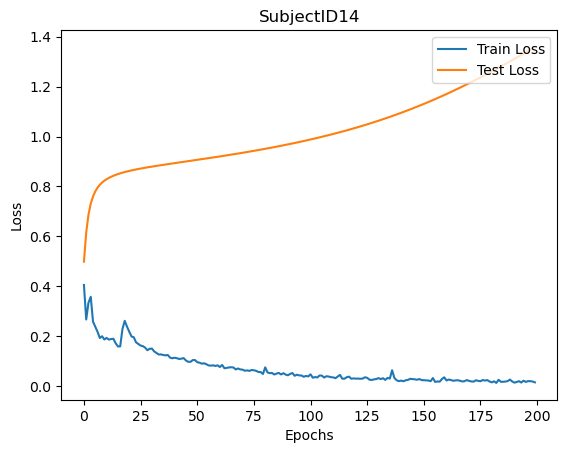

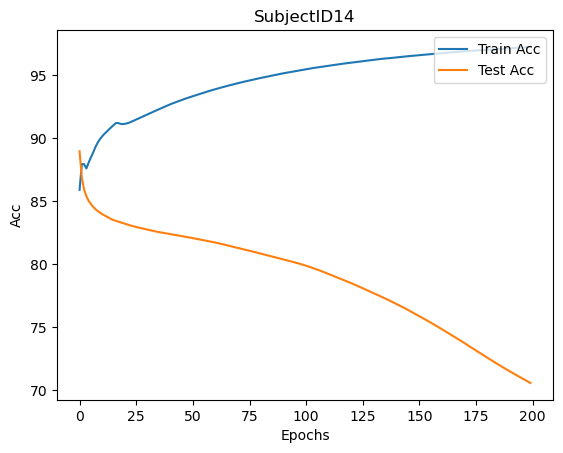

| epoch   0 | 0.0228 s/epoch | train loss 0.4310
| epoch   1 | 0.0227 s/epoch | train loss 0.3161
| epoch   2 | 0.0230 s/epoch | train loss 0.2979
| epoch   3 | 0.0228 s/epoch | train loss 0.2698
| epoch   4 | 0.0226 s/epoch | train loss 0.2590
| epoch   5 | 0.0237 s/epoch | train loss 0.2469
| epoch   6 | 0.0225 s/epoch | train loss 0.2355
| epoch   7 | 0.0215 s/epoch | train loss 0.2310
| epoch   8 | 0.0238 s/epoch | train loss 0.2240
| epoch   9 | 0.0223 s/epoch | train loss 0.2189
| epoch  10 | 0.0218 s/epoch | train loss 0.2238
| epoch  11 | 0.0216 s/epoch | train loss 0.2077
| epoch  12 | 0.0226 s/epoch | train loss 0.2062
| epoch  13 | 0.0226 s/epoch | train loss 0.2001
| epoch  14 | 0.0224 s/epoch | train loss 0.1948
| epoch  15 | 0.0222 s/epoch | train loss 0.1898
| epoch  16 | 0.0215 s/epoch | train loss 0.1908
| epoch  17 | 0.0209 s/epoch | train loss 0.1820
| epoch  18 | 0.0228 s/epoch | train loss 0.1758
| epoch  19 | 0.0220 s/epoch | train loss 0.1654
| epoch  20 | 0.0211

| epoch 168 | 0.0218 s/epoch | train loss 0.0170
| epoch 169 | 0.0232 s/epoch | train loss 0.0233
| epoch 170 | 0.0223 s/epoch | train loss 0.0203
| epoch 171 | 0.0219 s/epoch | train loss 0.0224
| epoch 172 | 0.0239 s/epoch | train loss 0.0218
| epoch 173 | 0.0222 s/epoch | train loss 0.0151
| epoch 174 | 0.0217 s/epoch | train loss 0.0146
| epoch 175 | 0.0217 s/epoch | train loss 0.0264
| epoch 176 | 0.0225 s/epoch | train loss 0.0186
| epoch 177 | 0.0213 s/epoch | train loss 0.0212
| epoch 178 | 0.0227 s/epoch | train loss 0.0211
| epoch 179 | 0.0227 s/epoch | train loss 0.0184
| epoch 180 | 0.0238 s/epoch | train loss 0.0283
| epoch 181 | 0.0230 s/epoch | train loss 0.0144
| epoch 182 | 0.0225 s/epoch | train loss 0.0113
| epoch 183 | 0.0219 s/epoch | train loss 0.0218
| epoch 184 | 0.0220 s/epoch | train loss 0.0257
| epoch 185 | 0.0230 s/epoch | train loss 0.0159
| epoch 186 | 0.0229 s/epoch | train loss 0.0136
| epoch 187 | 0.0241 s/epoch | train loss 0.0182
| epoch 188 | 0.0226

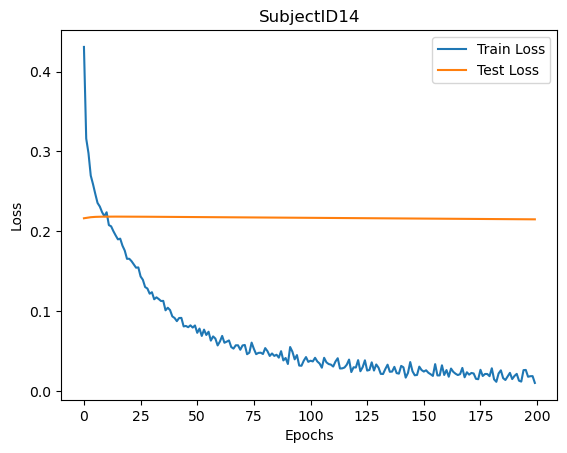

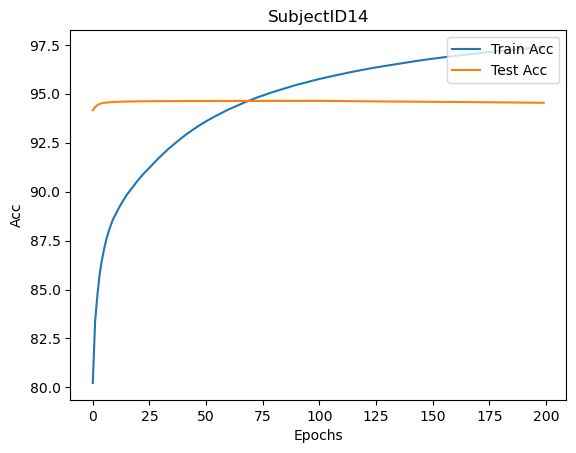


Subject 15
| epoch   0 | 0.3370 s/epoch | train loss 0.3234
| epoch   1 | 0.3334 s/epoch | train loss 0.2422
| epoch   2 | 0.3360 s/epoch | train loss 0.2168
| epoch   3 | 0.3350 s/epoch | train loss 0.2053
| epoch   4 | 0.3354 s/epoch | train loss 0.2038
| epoch   5 | 0.3327 s/epoch | train loss 0.1929
| epoch   6 | 0.3360 s/epoch | train loss 0.1893
| epoch   7 | 0.3371 s/epoch | train loss 0.1770
| epoch   8 | 0.3379 s/epoch | train loss 0.1756
| epoch   9 | 0.3343 s/epoch | train loss 0.1603
| epoch  10 | 0.3340 s/epoch | train loss 0.1604
| epoch  11 | 0.3359 s/epoch | train loss 0.3045
| epoch  12 | 0.3394 s/epoch | train loss 0.2286
| epoch  13 | 0.3404 s/epoch | train loss 0.2136
| epoch  14 | 0.3338 s/epoch | train loss 0.2050
| epoch  15 | 0.3309 s/epoch | train loss 0.1905
| epoch  16 | 0.3268 s/epoch | train loss 0.1862
| epoch  17 | 0.3336 s/epoch | train loss 0.1732
| epoch  18 | 0.3355 s/epoch | train loss 0.1679
| epoch  19 | 0.3354 s/epoch | train loss 0.1599
| epoch 

| epoch 167 | 0.3355 s/epoch | train loss 0.0205
| epoch 168 | 0.3350 s/epoch | train loss 0.0162
| epoch 169 | 0.3374 s/epoch | train loss 0.0138
| epoch 170 | 0.3312 s/epoch | train loss 0.0231
| epoch 171 | 0.3295 s/epoch | train loss 0.0135
| epoch 172 | 0.3383 s/epoch | train loss 0.0181
| epoch 173 | 0.3387 s/epoch | train loss 0.0167
| epoch 174 | 0.3365 s/epoch | train loss 0.0120
| epoch 175 | 0.3372 s/epoch | train loss 0.0153
| epoch 176 | 0.3358 s/epoch | train loss 0.0229
| epoch 177 | 0.3356 s/epoch | train loss 0.0181
| epoch 178 | 0.3375 s/epoch | train loss 0.0141
| epoch 179 | 0.3405 s/epoch | train loss 0.0180
| epoch 180 | 0.3372 s/epoch | train loss 0.0175
| epoch 181 | 0.3332 s/epoch | train loss 0.0195
| epoch 182 | 0.3381 s/epoch | train loss 0.0140
| epoch 183 | 0.3413 s/epoch | train loss 0.0159
| epoch 184 | 0.3440 s/epoch | train loss 0.0110
| epoch 185 | 0.3422 s/epoch | train loss 0.0140
| epoch 186 | 0.3369 s/epoch | train loss 0.0241
| epoch 187 | 0.3276

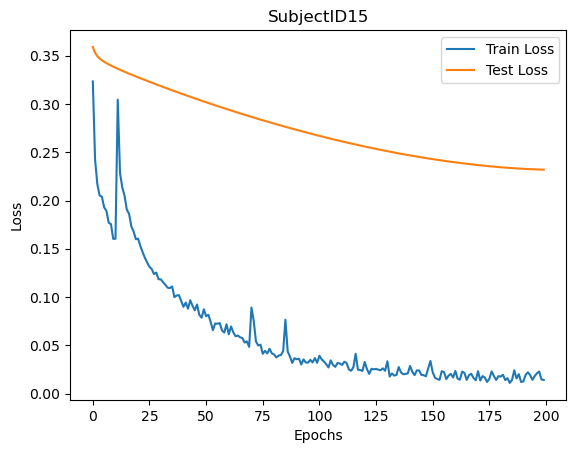

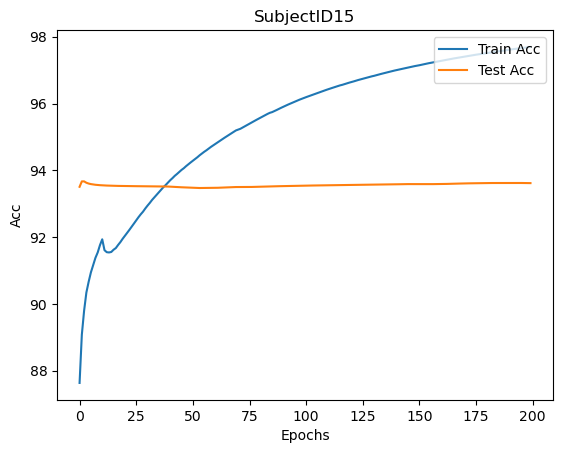

| epoch   0 | 0.0224 s/epoch | train loss 0.4379
| epoch   1 | 0.0215 s/epoch | train loss 0.3127
| epoch   2 | 0.0233 s/epoch | train loss 0.2816
| epoch   3 | 0.0229 s/epoch | train loss 0.2604
| epoch   4 | 0.0224 s/epoch | train loss 0.2444
| epoch   5 | 0.0225 s/epoch | train loss 0.2410
| epoch   6 | 0.0217 s/epoch | train loss 0.2383
| epoch   7 | 0.0228 s/epoch | train loss 0.2203
| epoch   8 | 0.0219 s/epoch | train loss 0.2171
| epoch   9 | 0.0220 s/epoch | train loss 0.2133
| epoch  10 | 0.0225 s/epoch | train loss 0.2038
| epoch  11 | 0.0216 s/epoch | train loss 0.2046
| epoch  12 | 0.0234 s/epoch | train loss 0.1985
| epoch  13 | 0.0230 s/epoch | train loss 0.1927
| epoch  14 | 0.0218 s/epoch | train loss 0.1850
| epoch  15 | 0.0226 s/epoch | train loss 0.1866
| epoch  16 | 0.0233 s/epoch | train loss 0.1825
| epoch  17 | 0.0218 s/epoch | train loss 0.1752
| epoch  18 | 0.0214 s/epoch | train loss 0.1728
| epoch  19 | 0.0215 s/epoch | train loss 0.1595
| epoch  20 | 0.0239

| epoch 168 | 0.0230 s/epoch | train loss 0.0193
| epoch 169 | 0.0218 s/epoch | train loss 0.0288
| epoch 170 | 0.0221 s/epoch | train loss 0.0280
| epoch 171 | 0.0219 s/epoch | train loss 0.0150
| epoch 172 | 0.0216 s/epoch | train loss 0.0149
| epoch 173 | 0.0213 s/epoch | train loss 0.0271
| epoch 174 | 0.0210 s/epoch | train loss 0.0228
| epoch 175 | 0.0220 s/epoch | train loss 0.0209
| epoch 176 | 0.0228 s/epoch | train loss 0.0149
| epoch 177 | 0.0219 s/epoch | train loss 0.0235
| epoch 178 | 0.0224 s/epoch | train loss 0.0177
| epoch 179 | 0.0218 s/epoch | train loss 0.0248
| epoch 180 | 0.0220 s/epoch | train loss 0.0259
| epoch 181 | 0.0234 s/epoch | train loss 0.0202
| epoch 182 | 0.0218 s/epoch | train loss 0.0164
| epoch 183 | 0.0223 s/epoch | train loss 0.0157
| epoch 184 | 0.0217 s/epoch | train loss 0.0232
| epoch 185 | 0.0225 s/epoch | train loss 0.0195
| epoch 186 | 0.0218 s/epoch | train loss 0.0140
| epoch 187 | 0.0226 s/epoch | train loss 0.0198
| epoch 188 | 0.0222

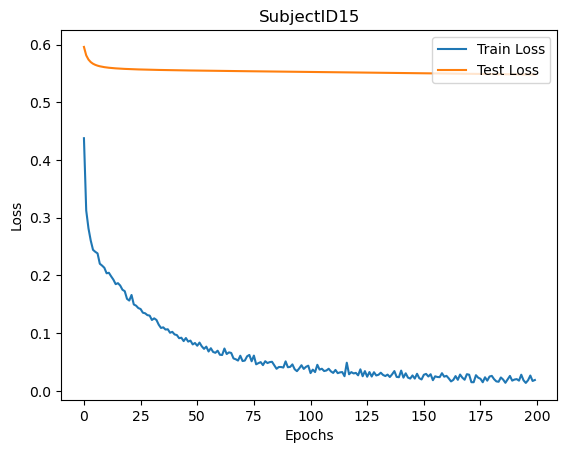

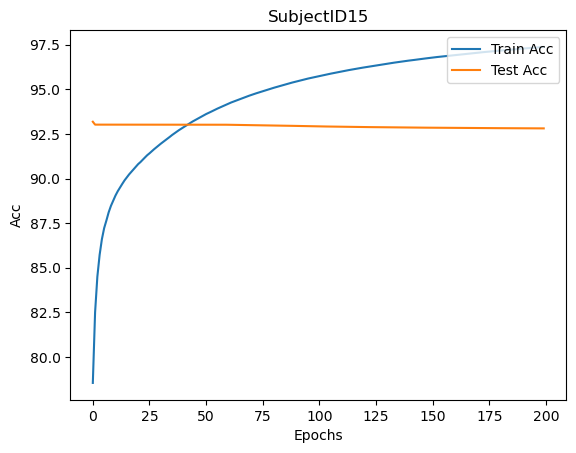


Subject 16
| epoch   0 | 0.3382 s/epoch | train loss 0.3368
| epoch   1 | 0.3363 s/epoch | train loss 0.2513
| epoch   2 | 0.3341 s/epoch | train loss 0.2311
| epoch   3 | 0.3350 s/epoch | train loss 0.2195
| epoch   4 | 0.3342 s/epoch | train loss 0.2038
| epoch   5 | 0.3350 s/epoch | train loss 0.2424
| epoch   6 | 0.3332 s/epoch | train loss 0.2063
| epoch   7 | 0.3364 s/epoch | train loss 0.1953
| epoch   8 | 0.3373 s/epoch | train loss 0.1874
| epoch   9 | 0.3335 s/epoch | train loss 0.1757
| epoch  10 | 0.3372 s/epoch | train loss 0.1717
| epoch  11 | 0.3335 s/epoch | train loss 0.1603
| epoch  12 | 0.3364 s/epoch | train loss 0.1619
| epoch  13 | 0.3353 s/epoch | train loss 0.1491
| epoch  14 | 0.3274 s/epoch | train loss 0.1435
| epoch  15 | 0.3283 s/epoch | train loss 0.1403
| epoch  16 | 0.3242 s/epoch | train loss 0.1368
| epoch  17 | 0.3327 s/epoch | train loss 0.1374
| epoch  18 | 0.3334 s/epoch | train loss 0.1317
| epoch  19 | 0.3380 s/epoch | train loss 0.1265
| epoch 

| epoch 167 | 0.3341 s/epoch | train loss 0.0199
| epoch 168 | 0.3415 s/epoch | train loss 0.0270
| epoch 169 | 0.3375 s/epoch | train loss 0.0268
| epoch 170 | 0.3381 s/epoch | train loss 0.0271
| epoch 171 | 0.3406 s/epoch | train loss 0.0278
| epoch 172 | 0.3366 s/epoch | train loss 0.0224
| epoch 173 | 0.3352 s/epoch | train loss 0.0224
| epoch 174 | 0.3353 s/epoch | train loss 0.0269
| epoch 175 | 0.3360 s/epoch | train loss 0.0321
| epoch 176 | 0.3361 s/epoch | train loss 0.0236
| epoch 177 | 0.3318 s/epoch | train loss 0.0242
| epoch 178 | 0.3393 s/epoch | train loss 0.0278
| epoch 179 | 0.3369 s/epoch | train loss 0.0238
| epoch 180 | 0.3305 s/epoch | train loss 0.0279
| epoch 181 | 0.3328 s/epoch | train loss 0.0210
| epoch 182 | 0.3377 s/epoch | train loss 0.0177
| epoch 183 | 0.3386 s/epoch | train loss 0.0170
| epoch 184 | 0.3390 s/epoch | train loss 0.0192
| epoch 185 | 0.3365 s/epoch | train loss 0.0197
| epoch 186 | 0.3387 s/epoch | train loss 0.0244
| epoch 187 | 0.3359

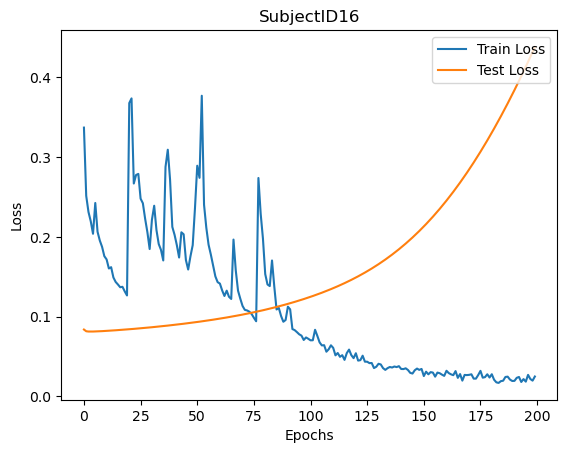

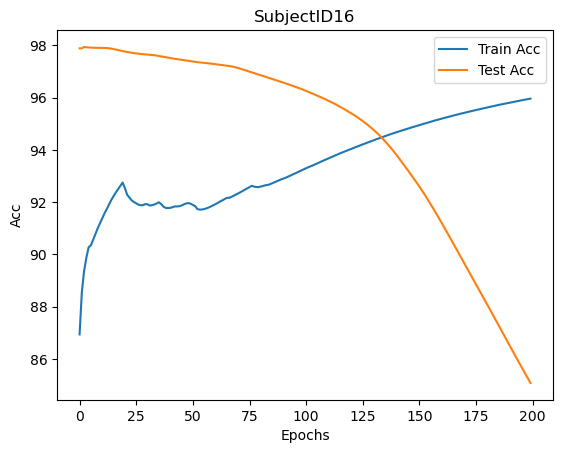

| epoch   0 | 0.0216 s/epoch | train loss 0.4177
| epoch   1 | 0.0226 s/epoch | train loss 0.3341
| epoch   2 | 0.0238 s/epoch | train loss 0.2953
| epoch   3 | 0.0223 s/epoch | train loss 0.2803
| epoch   4 | 0.0225 s/epoch | train loss 0.2699
| epoch   5 | 0.0226 s/epoch | train loss 0.2574
| epoch   6 | 0.0230 s/epoch | train loss 0.2468
| epoch   7 | 0.0243 s/epoch | train loss 0.2398
| epoch   8 | 0.0226 s/epoch | train loss 0.2260
| epoch   9 | 0.0221 s/epoch | train loss 0.2212
| epoch  10 | 0.0233 s/epoch | train loss 0.2137
| epoch  11 | 0.0232 s/epoch | train loss 0.2105
| epoch  12 | 0.0228 s/epoch | train loss 0.1984
| epoch  13 | 0.0227 s/epoch | train loss 0.2003
| epoch  14 | 0.0231 s/epoch | train loss 0.1880
| epoch  15 | 0.0217 s/epoch | train loss 0.1793
| epoch  16 | 0.0224 s/epoch | train loss 0.1742
| epoch  17 | 0.0219 s/epoch | train loss 0.1718
| epoch  18 | 0.0219 s/epoch | train loss 0.1670
| epoch  19 | 0.0233 s/epoch | train loss 0.1620
| epoch  20 | 0.0227

| epoch 168 | 0.0247 s/epoch | train loss 0.0273
| epoch 169 | 0.0228 s/epoch | train loss 0.0232
| epoch 170 | 0.0237 s/epoch | train loss 0.0204
| epoch 171 | 0.0229 s/epoch | train loss 0.0261
| epoch 172 | 0.0232 s/epoch | train loss 0.0228
| epoch 173 | 0.0221 s/epoch | train loss 0.0222
| epoch 174 | 0.0219 s/epoch | train loss 0.0172
| epoch 175 | 0.0221 s/epoch | train loss 0.0207
| epoch 176 | 0.0228 s/epoch | train loss 0.0189
| epoch 177 | 0.0222 s/epoch | train loss 0.0282
| epoch 178 | 0.0218 s/epoch | train loss 0.0217
| epoch 179 | 0.0224 s/epoch | train loss 0.0257
| epoch 180 | 0.0216 s/epoch | train loss 0.0184
| epoch 181 | 0.0218 s/epoch | train loss 0.0239
| epoch 182 | 0.0227 s/epoch | train loss 0.0247
| epoch 183 | 0.0217 s/epoch | train loss 0.0277
| epoch 184 | 0.0217 s/epoch | train loss 0.0160
| epoch 185 | 0.0224 s/epoch | train loss 0.0237
| epoch 186 | 0.0217 s/epoch | train loss 0.0222
| epoch 187 | 0.0217 s/epoch | train loss 0.0287
| epoch 188 | 0.0230

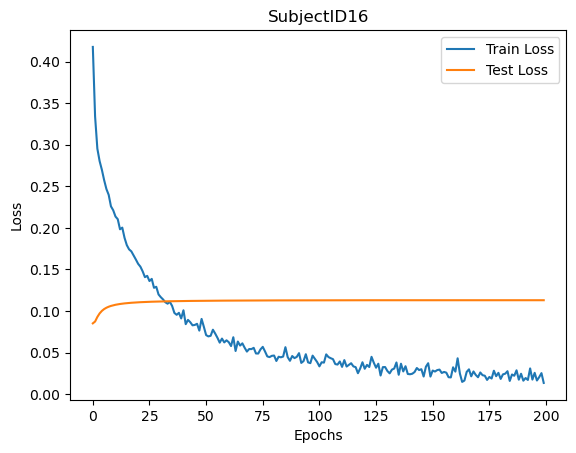

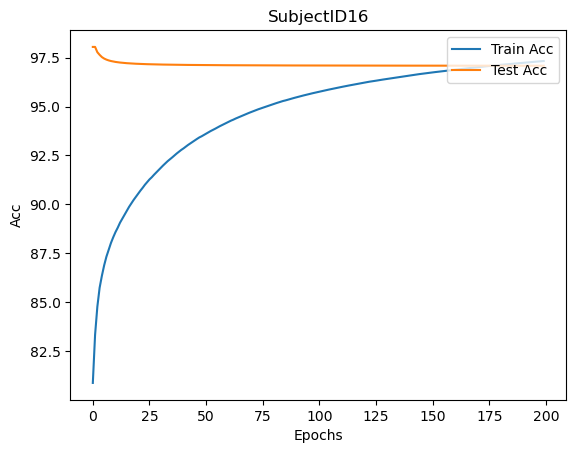


Subject 18
| epoch   0 | 0.3348 s/epoch | train loss 0.3488
| epoch   1 | 0.3346 s/epoch | train loss 0.2574
| epoch   2 | 0.3382 s/epoch | train loss 0.2393
| epoch   3 | 0.3333 s/epoch | train loss 0.2213
| epoch   4 | 0.3386 s/epoch | train loss 0.2169
| epoch   5 | 0.3346 s/epoch | train loss 0.1942
| epoch   6 | 0.3324 s/epoch | train loss 0.1946
| epoch   7 | 0.3308 s/epoch | train loss 0.1830
| epoch   8 | 0.3334 s/epoch | train loss 0.2179
| epoch   9 | 0.3251 s/epoch | train loss 0.1906
| epoch  10 | 0.3311 s/epoch | train loss 0.1814
| epoch  11 | 0.3345 s/epoch | train loss 0.1682
| epoch  12 | 0.3365 s/epoch | train loss 0.1632
| epoch  13 | 0.3352 s/epoch | train loss 0.1513
| epoch  14 | 0.3358 s/epoch | train loss 0.1531
| epoch  15 | 0.3350 s/epoch | train loss 0.1497
| epoch  16 | 0.3299 s/epoch | train loss 0.1452
| epoch  17 | 0.3316 s/epoch | train loss 0.1346
| epoch  18 | 0.3346 s/epoch | train loss 0.1367
| epoch  19 | 0.3326 s/epoch | train loss 0.1365
| epoch 

| epoch 167 | 0.3351 s/epoch | train loss 0.0221
| epoch 168 | 0.3375 s/epoch | train loss 0.0180
| epoch 169 | 0.3360 s/epoch | train loss 0.0188
| epoch 170 | 0.3391 s/epoch | train loss 0.0244
| epoch 171 | 0.3408 s/epoch | train loss 0.0169
| epoch 172 | 0.3387 s/epoch | train loss 0.0179
| epoch 173 | 0.3377 s/epoch | train loss 0.0188
| epoch 174 | 0.3377 s/epoch | train loss 0.0161
| epoch 175 | 0.3387 s/epoch | train loss 0.0205
| epoch 176 | 0.3351 s/epoch | train loss 0.0150
| epoch 177 | 0.3388 s/epoch | train loss 0.0174
| epoch 178 | 0.3337 s/epoch | train loss 0.0170
| epoch 179 | 0.3341 s/epoch | train loss 0.0183
| epoch 180 | 0.3367 s/epoch | train loss 0.0197
| epoch 181 | 0.3372 s/epoch | train loss 0.0111
| epoch 182 | 0.3399 s/epoch | train loss 0.0145
| epoch 183 | 0.3385 s/epoch | train loss 0.0197
| epoch 184 | 0.3362 s/epoch | train loss 0.0189
| epoch 185 | 0.3323 s/epoch | train loss 0.0235
| epoch 186 | 0.3344 s/epoch | train loss 0.0170
| epoch 187 | 0.3385

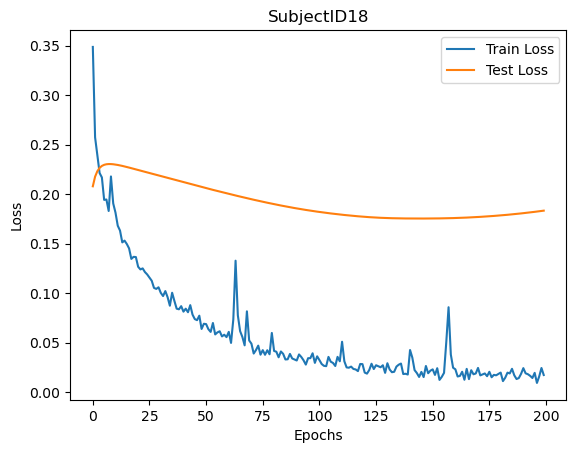

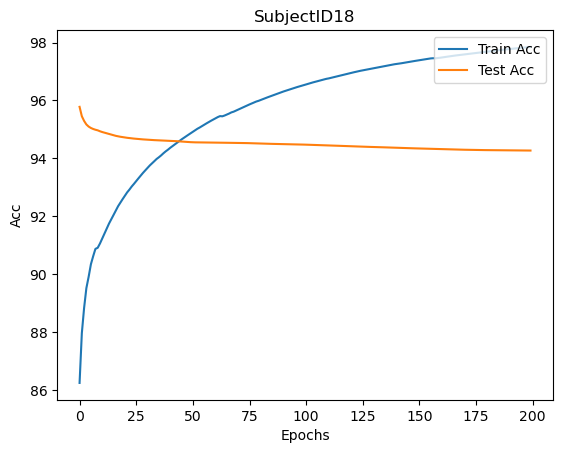

| epoch   0 | 0.0213 s/epoch | train loss 0.4327
| epoch   1 | 0.0212 s/epoch | train loss 0.3021
| epoch   2 | 0.0233 s/epoch | train loss 0.2739
| epoch   3 | 0.0219 s/epoch | train loss 0.2464
| epoch   4 | 0.0228 s/epoch | train loss 0.2338
| epoch   5 | 0.0230 s/epoch | train loss 0.2220
| epoch   6 | 0.0221 s/epoch | train loss 0.2179
| epoch   7 | 0.0241 s/epoch | train loss 0.2126
| epoch   8 | 0.0226 s/epoch | train loss 0.1997
| epoch   9 | 0.0217 s/epoch | train loss 0.1930
| epoch  10 | 0.0224 s/epoch | train loss 0.1859
| epoch  11 | 0.0214 s/epoch | train loss 0.1810
| epoch  12 | 0.0224 s/epoch | train loss 0.1855
| epoch  13 | 0.0209 s/epoch | train loss 0.1719
| epoch  14 | 0.0219 s/epoch | train loss 0.1687
| epoch  15 | 0.0230 s/epoch | train loss 0.1732
| epoch  16 | 0.0212 s/epoch | train loss 0.1619
| epoch  17 | 0.0218 s/epoch | train loss 0.1541
| epoch  18 | 0.0215 s/epoch | train loss 0.1553
| epoch  19 | 0.0227 s/epoch | train loss 0.1515
| epoch  20 | 0.0215

| epoch 168 | 0.0221 s/epoch | train loss 0.0171
| epoch 169 | 0.0219 s/epoch | train loss 0.0347
| epoch 170 | 0.0225 s/epoch | train loss 0.0169
| epoch 171 | 0.0228 s/epoch | train loss 0.0187
| epoch 172 | 0.0224 s/epoch | train loss 0.0219
| epoch 173 | 0.0243 s/epoch | train loss 0.0279
| epoch 174 | 0.0213 s/epoch | train loss 0.0224
| epoch 175 | 0.0227 s/epoch | train loss 0.0250
| epoch 176 | 0.0226 s/epoch | train loss 0.0238
| epoch 177 | 0.0220 s/epoch | train loss 0.0162
| epoch 178 | 0.0227 s/epoch | train loss 0.0294
| epoch 179 | 0.0230 s/epoch | train loss 0.0200
| epoch 180 | 0.0221 s/epoch | train loss 0.0211
| epoch 181 | 0.0239 s/epoch | train loss 0.0159
| epoch 182 | 0.0233 s/epoch | train loss 0.0202
| epoch 183 | 0.0230 s/epoch | train loss 0.0295
| epoch 184 | 0.0226 s/epoch | train loss 0.0180
| epoch 185 | 0.0238 s/epoch | train loss 0.0176
| epoch 186 | 0.0235 s/epoch | train loss 0.0189
| epoch 187 | 0.0231 s/epoch | train loss 0.0226
| epoch 188 | 0.0240

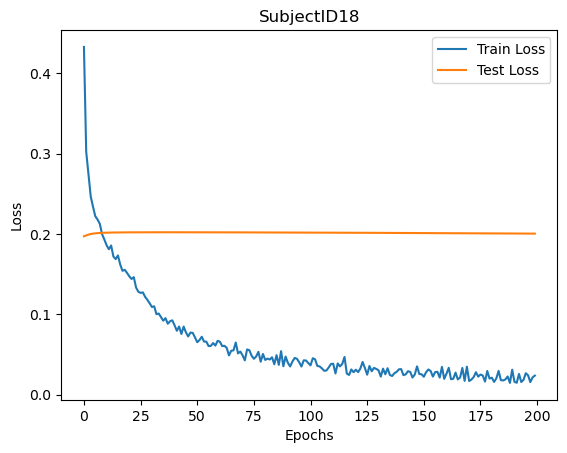

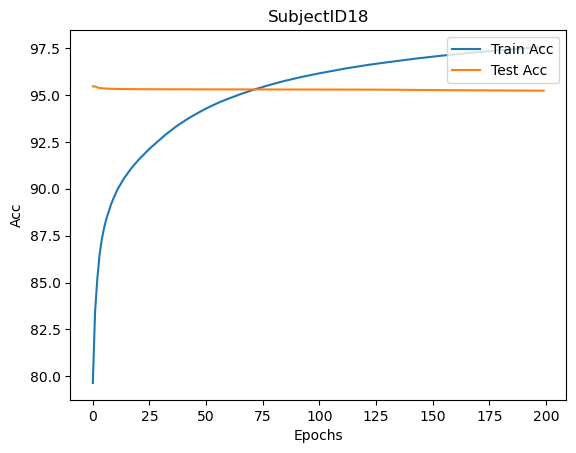


Subject 19
| epoch   0 | 0.3342 s/epoch | train loss 0.3537
| epoch   1 | 0.3293 s/epoch | train loss 0.3457
| epoch   2 | 0.3273 s/epoch | train loss 0.2966
| epoch   3 | 0.3368 s/epoch | train loss 0.2549
| epoch   4 | 0.3384 s/epoch | train loss 0.2450
| epoch   5 | 0.3391 s/epoch | train loss 0.2382
| epoch   6 | 0.3379 s/epoch | train loss 0.2265
| epoch   7 | 0.3389 s/epoch | train loss 0.2781
| epoch   8 | 0.3346 s/epoch | train loss 0.2694
| epoch   9 | 0.3315 s/epoch | train loss 0.2264
| epoch  10 | 0.3385 s/epoch | train loss 0.2815
| epoch  11 | 0.3355 s/epoch | train loss 0.3529
| epoch  12 | 0.3390 s/epoch | train loss 0.3060
| epoch  13 | 0.3409 s/epoch | train loss 0.2685
| epoch  14 | 0.3373 s/epoch | train loss 0.2741
| epoch  15 | 0.3390 s/epoch | train loss 0.2416
| epoch  16 | 0.3345 s/epoch | train loss 0.2238
| epoch  17 | 0.3384 s/epoch | train loss 0.2163
| epoch  18 | 0.3256 s/epoch | train loss 0.2015
| epoch  19 | 0.3351 s/epoch | train loss 0.1998
| epoch 

| epoch 167 | 0.3385 s/epoch | train loss 0.0233
| epoch 168 | 0.3371 s/epoch | train loss 0.0273
| epoch 169 | 0.3347 s/epoch | train loss 0.0237
| epoch 170 | 0.3391 s/epoch | train loss 0.0215
| epoch 171 | 0.3394 s/epoch | train loss 0.0216
| epoch 172 | 0.3362 s/epoch | train loss 0.0197
| epoch 173 | 0.3359 s/epoch | train loss 0.0252
| epoch 174 | 0.3354 s/epoch | train loss 0.0223
| epoch 175 | 0.3353 s/epoch | train loss 0.0166
| epoch 176 | 0.3360 s/epoch | train loss 0.0240
| epoch 177 | 0.3352 s/epoch | train loss 0.0232
| epoch 178 | 0.3404 s/epoch | train loss 0.0198
| epoch 179 | 0.3347 s/epoch | train loss 0.0173
| epoch 180 | 0.3364 s/epoch | train loss 0.0232
| epoch 181 | 0.3410 s/epoch | train loss 0.0231
| epoch 182 | 0.3399 s/epoch | train loss 0.0192
| epoch 183 | 0.3371 s/epoch | train loss 0.0181
| epoch 184 | 0.3321 s/epoch | train loss 0.0169
| epoch 185 | 0.3369 s/epoch | train loss 0.0233
| epoch 186 | 0.3393 s/epoch | train loss 0.0158
| epoch 187 | 0.3364

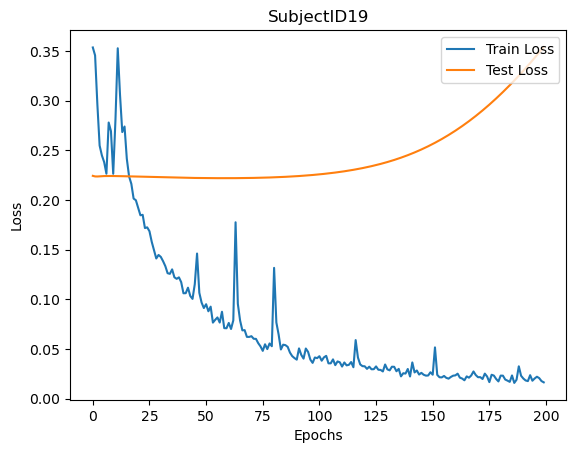

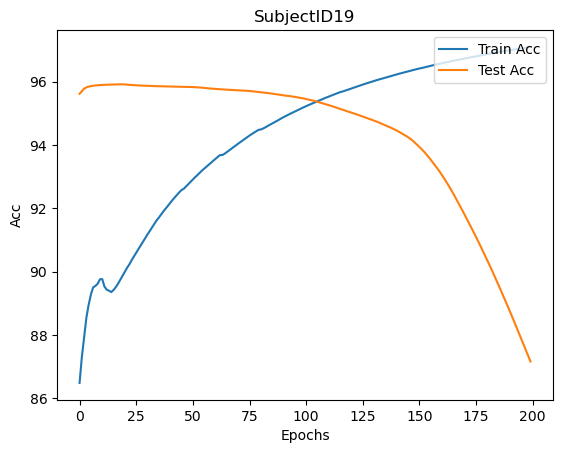

| epoch   0 | 0.0226 s/epoch | train loss 0.4510
| epoch   1 | 0.0214 s/epoch | train loss 0.3181
| epoch   2 | 0.0219 s/epoch | train loss 0.2928
| epoch   3 | 0.0229 s/epoch | train loss 0.2679
| epoch   4 | 0.0237 s/epoch | train loss 0.2537
| epoch   5 | 0.0221 s/epoch | train loss 0.2384
| epoch   6 | 0.0234 s/epoch | train loss 0.2265
| epoch   7 | 0.0226 s/epoch | train loss 0.2146
| epoch   8 | 0.0223 s/epoch | train loss 0.2176
| epoch   9 | 0.0217 s/epoch | train loss 0.2038
| epoch  10 | 0.0224 s/epoch | train loss 0.1943
| epoch  11 | 0.0229 s/epoch | train loss 0.1915
| epoch  12 | 0.0218 s/epoch | train loss 0.1901
| epoch  13 | 0.0227 s/epoch | train loss 0.1787
| epoch  14 | 0.0215 s/epoch | train loss 0.1757
| epoch  15 | 0.0223 s/epoch | train loss 0.1743
| epoch  16 | 0.0226 s/epoch | train loss 0.1707
| epoch  17 | 0.0221 s/epoch | train loss 0.1637
| epoch  18 | 0.0224 s/epoch | train loss 0.1615
| epoch  19 | 0.0219 s/epoch | train loss 0.1598
| epoch  20 | 0.0234

| epoch 168 | 0.0217 s/epoch | train loss 0.0256
| epoch 169 | 0.0231 s/epoch | train loss 0.0198
| epoch 170 | 0.0243 s/epoch | train loss 0.0253
| epoch 171 | 0.0230 s/epoch | train loss 0.0248
| epoch 172 | 0.0224 s/epoch | train loss 0.0281
| epoch 173 | 0.0236 s/epoch | train loss 0.0179
| epoch 174 | 0.0229 s/epoch | train loss 0.0255
| epoch 175 | 0.0222 s/epoch | train loss 0.0250
| epoch 176 | 0.0223 s/epoch | train loss 0.0232
| epoch 177 | 0.0226 s/epoch | train loss 0.0295
| epoch 178 | 0.0232 s/epoch | train loss 0.0214
| epoch 179 | 0.0223 s/epoch | train loss 0.0193
| epoch 180 | 0.0234 s/epoch | train loss 0.0321
| epoch 181 | 0.0231 s/epoch | train loss 0.0226
| epoch 182 | 0.0224 s/epoch | train loss 0.0165
| epoch 183 | 0.0233 s/epoch | train loss 0.0311
| epoch 184 | 0.0241 s/epoch | train loss 0.0185
| epoch 185 | 0.0225 s/epoch | train loss 0.0282
| epoch 186 | 0.0220 s/epoch | train loss 0.0156
| epoch 187 | 0.0222 s/epoch | train loss 0.0282
| epoch 188 | 0.0226

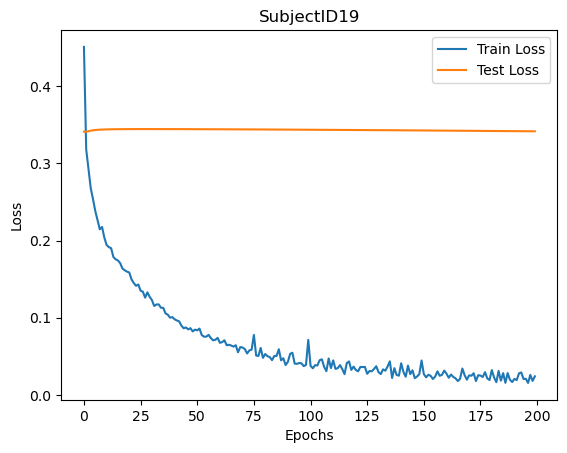

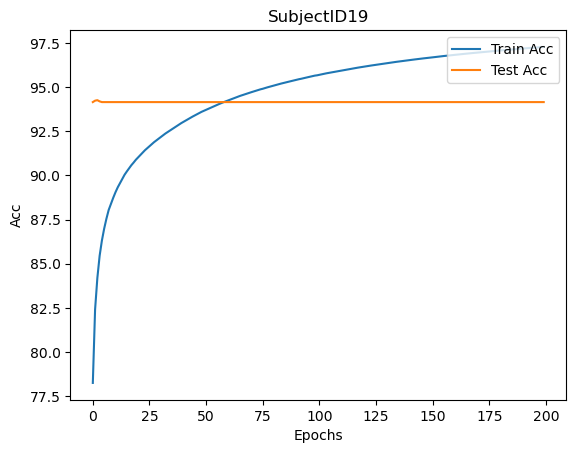


Subject 21
| epoch   0 | 0.3406 s/epoch | train loss 0.3399
| epoch   1 | 0.3320 s/epoch | train loss 0.2468
| epoch   2 | 0.3305 s/epoch | train loss 0.2225
| epoch   3 | 0.3371 s/epoch | train loss 0.2254
| epoch   4 | 0.3357 s/epoch | train loss 0.2018
| epoch   5 | 0.3404 s/epoch | train loss 0.1920
| epoch   6 | 0.3385 s/epoch | train loss 0.1850
| epoch   7 | 0.3354 s/epoch | train loss 0.1875
| epoch   8 | 0.3366 s/epoch | train loss 0.1985
| epoch   9 | 0.3401 s/epoch | train loss 0.1759
| epoch  10 | 0.3351 s/epoch | train loss 0.1667
| epoch  11 | 0.3353 s/epoch | train loss 0.1583
| epoch  12 | 0.3330 s/epoch | train loss 0.1830
| epoch  13 | 0.3378 s/epoch | train loss 0.2731
| epoch  14 | 0.3358 s/epoch | train loss 0.2167
| epoch  15 | 0.3364 s/epoch | train loss 0.2073
| epoch  16 | 0.3341 s/epoch | train loss 0.1955
| epoch  17 | 0.3405 s/epoch | train loss 0.1806
| epoch  18 | 0.3366 s/epoch | train loss 0.1774
| epoch  19 | 0.3383 s/epoch | train loss 0.1640
| epoch 

| epoch 167 | 0.3406 s/epoch | train loss 0.0202
| epoch 168 | 0.3381 s/epoch | train loss 0.0202
| epoch 169 | 0.3366 s/epoch | train loss 0.0177
| epoch 170 | 0.3370 s/epoch | train loss 0.0190
| epoch 171 | 0.3371 s/epoch | train loss 0.0214
| epoch 172 | 0.3369 s/epoch | train loss 0.0214
| epoch 173 | 0.3382 s/epoch | train loss 0.0157
| epoch 174 | 0.3402 s/epoch | train loss 0.0172
| epoch 175 | 0.3380 s/epoch | train loss 0.0191
| epoch 176 | 0.3342 s/epoch | train loss 0.0194
| epoch 177 | 0.3339 s/epoch | train loss 0.0225
| epoch 178 | 0.3389 s/epoch | train loss 0.0203
| epoch 179 | 0.3368 s/epoch | train loss 0.0199
| epoch 180 | 0.3392 s/epoch | train loss 0.0198
| epoch 181 | 0.3405 s/epoch | train loss 0.0312
| epoch 182 | 0.3389 s/epoch | train loss 0.0516
| epoch 183 | 0.3343 s/epoch | train loss 0.0222
| epoch 184 | 0.3390 s/epoch | train loss 0.0190
| epoch 185 | 0.3382 s/epoch | train loss 0.0183
| epoch 186 | 0.3357 s/epoch | train loss 0.0174
| epoch 187 | 0.3338

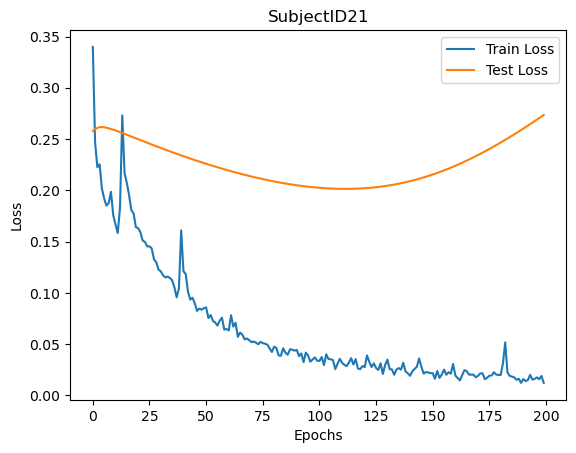

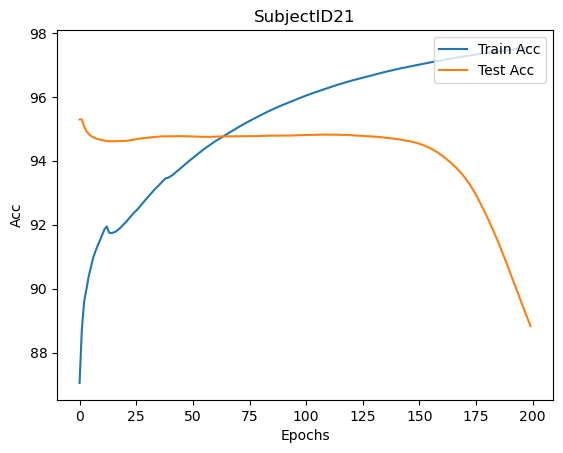

| epoch   0 | 0.0242 s/epoch | train loss 0.4360
| epoch   1 | 0.0214 s/epoch | train loss 0.3023
| epoch   2 | 0.0221 s/epoch | train loss 0.2756
| epoch   3 | 0.0236 s/epoch | train loss 0.2578
| epoch   4 | 0.0218 s/epoch | train loss 0.2527
| epoch   5 | 0.0209 s/epoch | train loss 0.2330
| epoch   6 | 0.0220 s/epoch | train loss 0.2223
| epoch   7 | 0.0218 s/epoch | train loss 0.2145
| epoch   8 | 0.0212 s/epoch | train loss 0.2063
| epoch   9 | 0.0213 s/epoch | train loss 0.2040
| epoch  10 | 0.0215 s/epoch | train loss 0.1987
| epoch  11 | 0.0231 s/epoch | train loss 0.1848
| epoch  12 | 0.0216 s/epoch | train loss 0.1851
| epoch  13 | 0.0194 s/epoch | train loss 0.1830
| epoch  14 | 0.0205 s/epoch | train loss 0.1758
| epoch  15 | 0.0215 s/epoch | train loss 0.1738
| epoch  16 | 0.0244 s/epoch | train loss 0.1670
| epoch  17 | 0.0235 s/epoch | train loss 0.1612
| epoch  18 | 0.0213 s/epoch | train loss 0.1646
| epoch  19 | 0.0223 s/epoch | train loss 0.1576
| epoch  20 | 0.0217

| epoch 168 | 0.0216 s/epoch | train loss 0.0377
| epoch 169 | 0.0242 s/epoch | train loss 0.0214
| epoch 170 | 0.0227 s/epoch | train loss 0.0234
| epoch 171 | 0.0225 s/epoch | train loss 0.0249
| epoch 172 | 0.0216 s/epoch | train loss 0.0166
| epoch 173 | 0.0222 s/epoch | train loss 0.0230
| epoch 174 | 0.0224 s/epoch | train loss 0.0232
| epoch 175 | 0.0231 s/epoch | train loss 0.0198
| epoch 176 | 0.0220 s/epoch | train loss 0.0256
| epoch 177 | 0.0225 s/epoch | train loss 0.0247
| epoch 178 | 0.0233 s/epoch | train loss 0.0208
| epoch 179 | 0.0213 s/epoch | train loss 0.0292
| epoch 180 | 0.0219 s/epoch | train loss 0.0211
| epoch 181 | 0.0226 s/epoch | train loss 0.0188
| epoch 182 | 0.0216 s/epoch | train loss 0.0248
| epoch 183 | 0.0245 s/epoch | train loss 0.0238
| epoch 184 | 0.0226 s/epoch | train loss 0.0228
| epoch 185 | 0.0231 s/epoch | train loss 0.0246
| epoch 186 | 0.0241 s/epoch | train loss 0.0220
| epoch 187 | 0.0218 s/epoch | train loss 0.0189
| epoch 188 | 0.0218

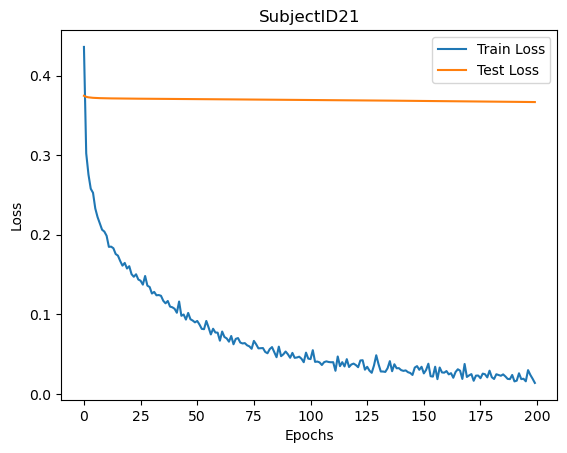

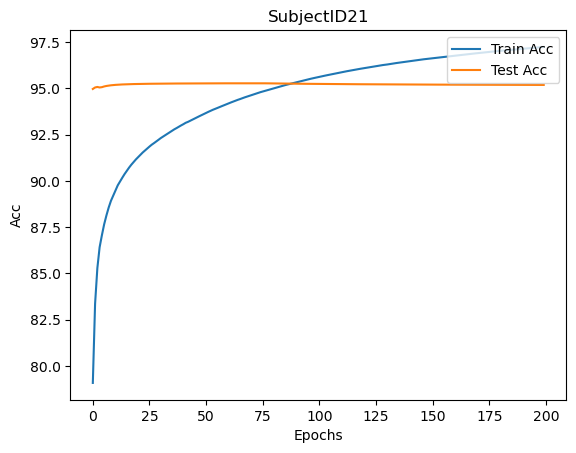


Subject 22
| epoch   0 | 0.3425 s/epoch | train loss 0.3759
| epoch   1 | 0.3362 s/epoch | train loss 0.2619
| epoch   2 | 0.3360 s/epoch | train loss 0.2557
| epoch   3 | 0.3355 s/epoch | train loss 0.2855
| epoch   4 | 0.3385 s/epoch | train loss 0.3304
| epoch   5 | 0.3363 s/epoch | train loss 0.2833
| epoch   6 | 0.3339 s/epoch | train loss 0.2738
| epoch   7 | 0.3414 s/epoch | train loss 0.2284
| epoch   8 | 0.3385 s/epoch | train loss 0.2246
| epoch   9 | 0.3347 s/epoch | train loss 0.2217
| epoch  10 | 0.4099 s/epoch | train loss 0.2067
| epoch  11 | 0.3395 s/epoch | train loss 0.2112
| epoch  12 | 0.3372 s/epoch | train loss 0.2787
| epoch  13 | 0.3702 s/epoch | train loss 0.3968
| epoch  14 | 0.3468 s/epoch | train loss 0.2611
| epoch  15 | 0.5144 s/epoch | train loss 0.2368
| epoch  16 | 0.4029 s/epoch | train loss 0.2189
| epoch  17 | 0.4262 s/epoch | train loss 0.1993
| epoch  18 | 0.4206 s/epoch | train loss 0.1869
| epoch  19 | 0.4844 s/epoch | train loss 0.1886
| epoch 

| epoch 167 | 0.4507 s/epoch | train loss 0.0191
| epoch 168 | 0.4455 s/epoch | train loss 0.0172
| epoch 169 | 0.4333 s/epoch | train loss 0.0189
| epoch 170 | 0.4005 s/epoch | train loss 0.0160
| epoch 171 | 0.3855 s/epoch | train loss 0.0275
| epoch 172 | 0.4127 s/epoch | train loss 0.0245
| epoch 173 | 0.4010 s/epoch | train loss 0.0128
| epoch 174 | 0.3989 s/epoch | train loss 0.0161
| epoch 175 | 0.4123 s/epoch | train loss 0.0166
| epoch 176 | 0.4425 s/epoch | train loss 0.0191
| epoch 177 | 0.4126 s/epoch | train loss 0.0170
| epoch 178 | 0.4230 s/epoch | train loss 0.0199
| epoch 179 | 0.4103 s/epoch | train loss 0.0167
| epoch 180 | 0.3916 s/epoch | train loss 0.0147
| epoch 181 | 0.3796 s/epoch | train loss 0.0151
| epoch 182 | 0.3837 s/epoch | train loss 0.0155
| epoch 183 | 0.4005 s/epoch | train loss 0.0180
| epoch 184 | 0.3865 s/epoch | train loss 0.0381
| epoch 185 | 0.4060 s/epoch | train loss 0.0215
| epoch 186 | 0.4296 s/epoch | train loss 0.0136
| epoch 187 | 0.4156

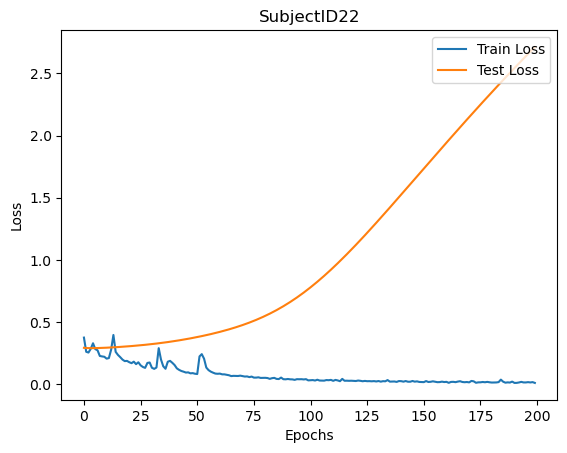

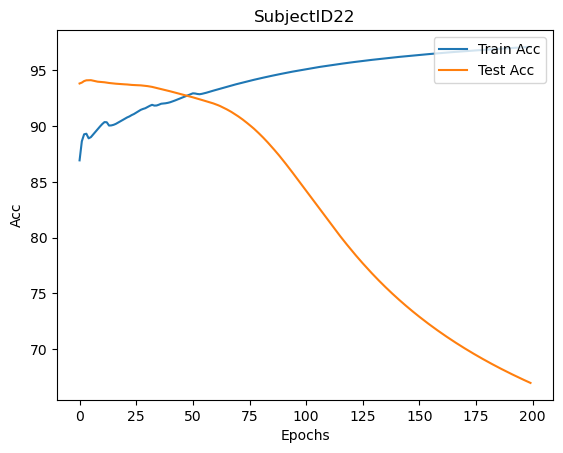

| epoch   0 | 0.0403 s/epoch | train loss 0.4250
| epoch   1 | 0.0312 s/epoch | train loss 0.3042
| epoch   2 | 0.0309 s/epoch | train loss 0.2692
| epoch   3 | 0.0318 s/epoch | train loss 0.2538
| epoch   4 | 0.0313 s/epoch | train loss 0.2464
| epoch   5 | 0.0309 s/epoch | train loss 0.2397
| epoch   6 | 0.0294 s/epoch | train loss 0.2301
| epoch   7 | 0.0275 s/epoch | train loss 0.2142
| epoch   8 | 0.0306 s/epoch | train loss 0.2063
| epoch   9 | 0.0297 s/epoch | train loss 0.1976
| epoch  10 | 0.0286 s/epoch | train loss 0.1920
| epoch  11 | 0.0284 s/epoch | train loss 0.1906
| epoch  12 | 0.0285 s/epoch | train loss 0.1869
| epoch  13 | 0.0281 s/epoch | train loss 0.1809
| epoch  14 | 0.0292 s/epoch | train loss 0.1752
| epoch  15 | 0.0293 s/epoch | train loss 0.1682
| epoch  16 | 0.0295 s/epoch | train loss 0.1661
| epoch  17 | 0.0294 s/epoch | train loss 0.1625
| epoch  18 | 0.0278 s/epoch | train loss 0.1617
| epoch  19 | 0.0292 s/epoch | train loss 0.1569
| epoch  20 | 0.0261

| epoch 168 | 0.0285 s/epoch | train loss 0.0213
| epoch 169 | 0.0291 s/epoch | train loss 0.0182
| epoch 170 | 0.0297 s/epoch | train loss 0.0204
| epoch 171 | 0.0298 s/epoch | train loss 0.0336
| epoch 172 | 0.0292 s/epoch | train loss 0.0270
| epoch 173 | 0.0342 s/epoch | train loss 0.0305
| epoch 174 | 0.0302 s/epoch | train loss 0.0175
| epoch 175 | 0.0294 s/epoch | train loss 0.0276
| epoch 176 | 0.0432 s/epoch | train loss 0.0286
| epoch 177 | 0.0301 s/epoch | train loss 0.0156
| epoch 178 | 0.0282 s/epoch | train loss 0.0298
| epoch 179 | 0.0319 s/epoch | train loss 0.0204
| epoch 180 | 0.0280 s/epoch | train loss 0.0261
| epoch 181 | 0.0371 s/epoch | train loss 0.0188
| epoch 182 | 0.0291 s/epoch | train loss 0.0244
| epoch 183 | 0.0288 s/epoch | train loss 0.0170
| epoch 184 | 0.0298 s/epoch | train loss 0.0182
| epoch 185 | 0.0306 s/epoch | train loss 0.0355
| epoch 186 | 0.0453 s/epoch | train loss 0.0170
| epoch 187 | 0.0282 s/epoch | train loss 0.0285
| epoch 188 | 0.0299

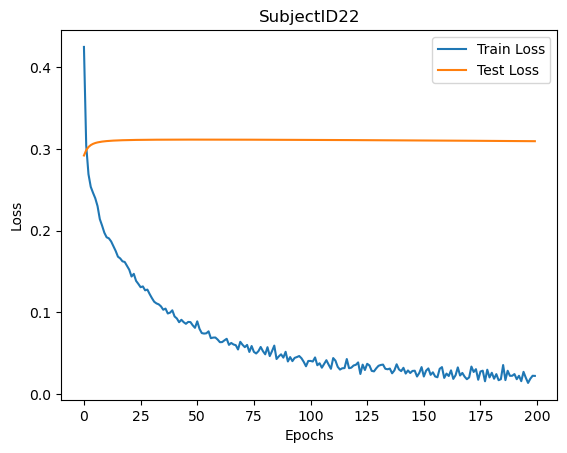

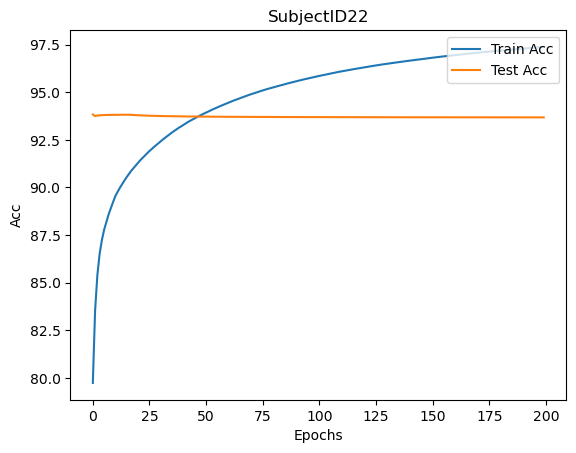


Subject 23
| epoch   0 | 0.4288 s/epoch | train loss 0.3380
| epoch   1 | 0.4155 s/epoch | train loss 0.2438
| epoch   2 | 0.4165 s/epoch | train loss 0.2234
| epoch   3 | 0.4208 s/epoch | train loss 0.2110
| epoch   4 | 0.4070 s/epoch | train loss 0.1953
| epoch   5 | 0.4033 s/epoch | train loss 0.1914
| epoch   6 | 0.4053 s/epoch | train loss 0.1830
| epoch   7 | 0.4237 s/epoch | train loss 0.1784
| epoch   8 | 0.3819 s/epoch | train loss 0.1785
| epoch   9 | 0.3641 s/epoch | train loss 0.1675
| epoch  10 | 0.4026 s/epoch | train loss 0.1594
| epoch  11 | 0.4081 s/epoch | train loss 0.1537
| epoch  12 | 0.3827 s/epoch | train loss 0.1634
| epoch  13 | 0.3959 s/epoch | train loss 0.2146
| epoch  14 | 0.4019 s/epoch | train loss 0.2421
| epoch  15 | 0.4032 s/epoch | train loss 0.1821
| epoch  16 | 0.3796 s/epoch | train loss 0.1676
| epoch  17 | 0.3661 s/epoch | train loss 0.1617
| epoch  18 | 0.3512 s/epoch | train loss 0.1450
| epoch  19 | 0.3664 s/epoch | train loss 0.1448
| epoch 

| epoch 167 | 0.3413 s/epoch | train loss 0.0128
| epoch 168 | 0.3354 s/epoch | train loss 0.0206
| epoch 169 | 0.3390 s/epoch | train loss 0.0185
| epoch 170 | 0.3406 s/epoch | train loss 0.0165
| epoch 171 | 0.3374 s/epoch | train loss 0.0284
| epoch 172 | 0.3439 s/epoch | train loss 0.0165
| epoch 173 | 0.3394 s/epoch | train loss 0.0165
| epoch 174 | 0.3435 s/epoch | train loss 0.0437
| epoch 175 | 0.3432 s/epoch | train loss 0.0239
| epoch 176 | 0.3518 s/epoch | train loss 0.0174
| epoch 177 | 0.3463 s/epoch | train loss 0.0190
| epoch 178 | 0.3676 s/epoch | train loss 0.0242
| epoch 179 | 0.3520 s/epoch | train loss 0.0189
| epoch 180 | 0.3431 s/epoch | train loss 0.0181
| epoch 181 | 0.3562 s/epoch | train loss 0.0233
| epoch 182 | 0.3649 s/epoch | train loss 0.0133
| epoch 183 | 0.3458 s/epoch | train loss 0.0163
| epoch 184 | 0.3303 s/epoch | train loss 0.0151
| epoch 185 | 0.3304 s/epoch | train loss 0.0240
| epoch 186 | 0.3322 s/epoch | train loss 0.0182
| epoch 187 | 0.3353

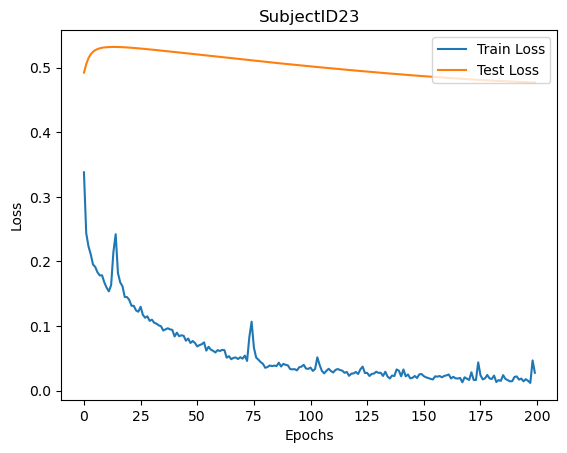

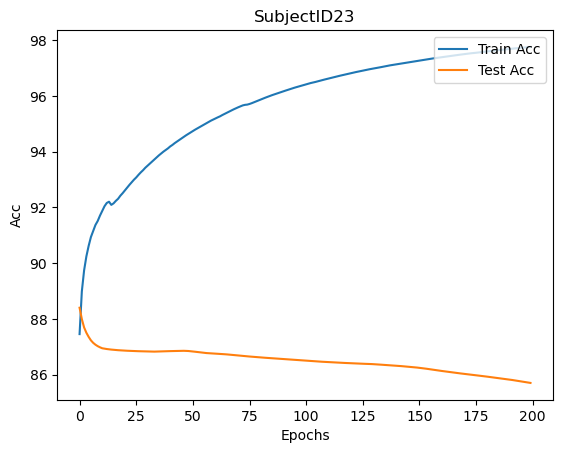

| epoch   0 | 0.0222 s/epoch | train loss 0.4093
| epoch   1 | 0.0231 s/epoch | train loss 0.2911
| epoch   2 | 0.0217 s/epoch | train loss 0.2606
| epoch   3 | 0.0243 s/epoch | train loss 0.2512
| epoch   4 | 0.0231 s/epoch | train loss 0.2304
| epoch   5 | 0.0216 s/epoch | train loss 0.2231
| epoch   6 | 0.0221 s/epoch | train loss 0.2096
| epoch   7 | 0.0224 s/epoch | train loss 0.2005
| epoch   8 | 0.0218 s/epoch | train loss 0.1918
| epoch   9 | 0.0218 s/epoch | train loss 0.1856
| epoch  10 | 0.0231 s/epoch | train loss 0.1802
| epoch  11 | 0.0216 s/epoch | train loss 0.1761
| epoch  12 | 0.0215 s/epoch | train loss 0.1728
| epoch  13 | 0.0216 s/epoch | train loss 0.1625
| epoch  14 | 0.0227 s/epoch | train loss 0.1629
| epoch  15 | 0.0236 s/epoch | train loss 0.1548
| epoch  16 | 0.0222 s/epoch | train loss 0.1505
| epoch  17 | 0.0222 s/epoch | train loss 0.1469
| epoch  18 | 0.0216 s/epoch | train loss 0.1455
| epoch  19 | 0.0223 s/epoch | train loss 0.1456
| epoch  20 | 0.0230

| epoch 168 | 0.0267 s/epoch | train loss 0.0290
| epoch 169 | 0.0255 s/epoch | train loss 0.0232
| epoch 170 | 0.0242 s/epoch | train loss 0.0220
| epoch 171 | 0.0228 s/epoch | train loss 0.0253
| epoch 172 | 0.0239 s/epoch | train loss 0.0231
| epoch 173 | 0.0234 s/epoch | train loss 0.0221
| epoch 174 | 0.0240 s/epoch | train loss 0.0215
| epoch 175 | 0.0232 s/epoch | train loss 0.0271
| epoch 176 | 0.0244 s/epoch | train loss 0.0164
| epoch 177 | 0.0233 s/epoch | train loss 0.0271
| epoch 178 | 0.0233 s/epoch | train loss 0.0267
| epoch 179 | 0.0239 s/epoch | train loss 0.0209
| epoch 180 | 0.0227 s/epoch | train loss 0.0191
| epoch 181 | 0.0237 s/epoch | train loss 0.0281
| epoch 182 | 0.0234 s/epoch | train loss 0.0259
| epoch 183 | 0.0231 s/epoch | train loss 0.0168
| epoch 184 | 0.0237 s/epoch | train loss 0.0305
| epoch 185 | 0.0248 s/epoch | train loss 0.0173
| epoch 186 | 0.0237 s/epoch | train loss 0.0145
| epoch 187 | 0.0271 s/epoch | train loss 0.0290
| epoch 188 | 0.0246

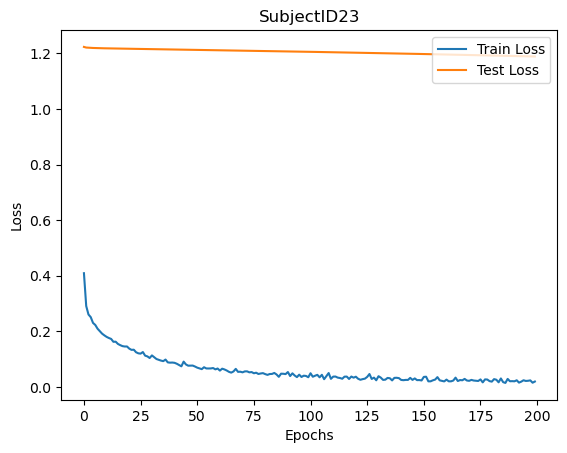

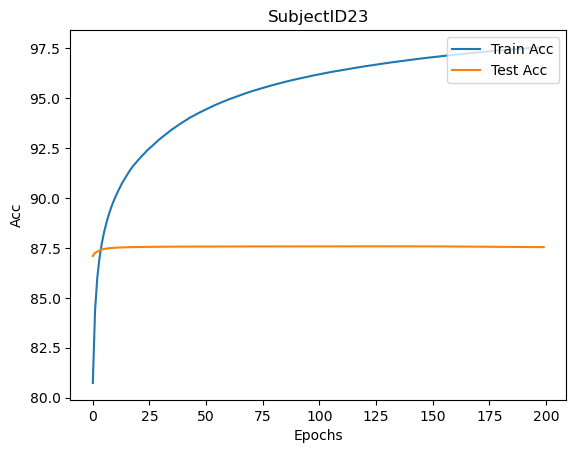

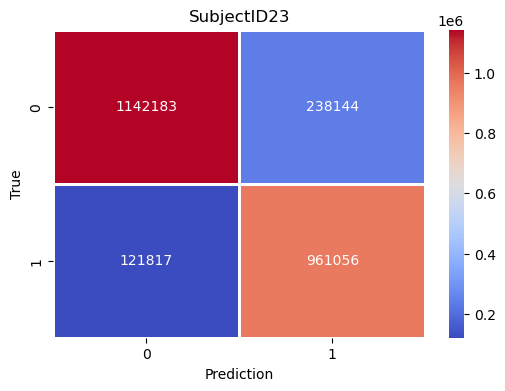

<Figure size 640x480 with 0 Axes>

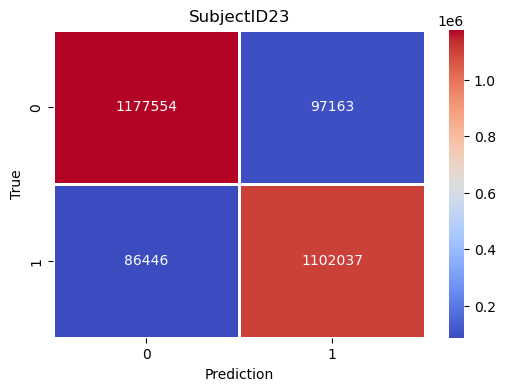

Teacher1(RestNet50)_Acc: 0.8538644852224748
Teacher1(RestNet50)_Rec: 0.8875057370531909
Teacher1(RestNet50)_Pre: 0.8014142761841228
Teacher1(RestNet50)_F1: 0.8422657820323889
Original_Student1(CNN_Small)_Acc: 0.9254591588177979
Original_Student1(CNN_Small)_Rec: 0.9272635788648218
Original_Student1(CNN_Small)_Pre: 0.9189768178785858
Original_Student1(CNN_Small)_F1: 0.9231016010081741


<Figure size 640x480 with 0 Axes>

In [17]:
#%% Evaluation
def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])

#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []


Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []


teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []



#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,18,19,21,22,23]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float32'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float32'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            if len(norm_sliding_waist_data[i]) > 0:
                e1 = np.max(norm_sliding_waist_data[i])
                max_norm_value.append(e1)
                e2 = np.argmax(norm_sliding_waist_data[i])
                max_norm_index.append(e2)

                e3 = np.max(hori_sliding_waist_data[i])
                max_hori_value.append(e3)
                e4 = np.argmax(hori_sliding_waist_data[i])
                max_hori_index.append(e4)
            else:
                e1 = 0
                max_norm_value.append(e1)
                e2 = 0
                max_norm_index.append(e2)

                e3 = np.max(hori_sliding_waist_data[i])
                max_hori_value.append(e3)
                e4 = np.argmax(hori_sliding_waist_data[i])
                max_hori_index.append(e4)
                

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float32')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float32')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [3, 4, 23, 3], 1, 2)
    model_teacher = ResNet.to(device) 
    model_teacher.train()

    model_student = Net_Student(config).to(device) 
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

#print(teacher_train_preds)
#print(teacher_train_gt)
Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher1(RestNet50)_Acc:",Teacher_eval_table[0])
print("Teacher1(RestNet50)_Rec:",Teacher_eval_table[1])
print("Teacher1(RestNet50)_Pre:",Teacher_eval_table[2])
print("Teacher1(RestNet50)_F1:",Teacher_eval_table[3])

print("Original_Student1(CNN_Small)_Acc:",Student_eval_table[0])
print("Original_Student1(CNN_Small)_Rec:",Student_eval_table[1])
print("Original_Student1(CNN_Small)_Pre:",Student_eval_table[2])
print("Original_Student1(CNN_Small)_F1:",Student_eval_table[3]) 


Subject 1
| epoch   0 | 0.4309 s/epoch | train loss 0.6175
| epoch   1 | 0.4438 s/epoch | train loss 0.4433
| epoch   2 | 0.4314 s/epoch | train loss 0.3947
| epoch   3 | 0.4445 s/epoch | train loss 0.3742
| epoch   4 | 0.4265 s/epoch | train loss 0.3488
| epoch   5 | 0.4182 s/epoch | train loss 0.3424
| epoch   6 | 0.4171 s/epoch | train loss 0.3239
| epoch   7 | 0.4249 s/epoch | train loss 0.3206
| epoch   8 | 0.4506 s/epoch | train loss 0.3067
| epoch   9 | 0.4476 s/epoch | train loss 0.3002
| epoch  10 | 0.4276 s/epoch | train loss 0.3040
| epoch  11 | 0.4373 s/epoch | train loss 0.2836
| epoch  12 | 0.4343 s/epoch | train loss 0.2884
| epoch  13 | 0.4423 s/epoch | train loss 0.2846
| epoch  14 | 0.4290 s/epoch | train loss 0.2786
| epoch  15 | 0.4644 s/epoch | train loss 0.2707
| epoch  16 | 0.4479 s/epoch | train loss 0.2611
| epoch  17 | 0.4453 s/epoch | train loss 0.2606
| epoch  18 | 0.4484 s/epoch | train loss 0.2494
| epoch  19 | 0.4649 s/epoch | train loss 0.2556
| epoch  

| epoch 167 | 0.4169 s/epoch | train loss 0.1059
| epoch 168 | 0.4154 s/epoch | train loss 0.1130
| epoch 169 | 0.4121 s/epoch | train loss 0.1129
| epoch 170 | 0.4217 s/epoch | train loss 0.1040
| epoch 171 | 0.4221 s/epoch | train loss 0.1034
| epoch 172 | 0.4169 s/epoch | train loss 0.1063
| epoch 173 | 0.4161 s/epoch | train loss 0.1038
| epoch 174 | 0.4196 s/epoch | train loss 0.1022
| epoch 175 | 0.4168 s/epoch | train loss 0.1069
| epoch 176 | 0.4172 s/epoch | train loss 0.1052
| epoch 177 | 0.4208 s/epoch | train loss 0.1092
| epoch 178 | 0.4236 s/epoch | train loss 0.2074
| epoch 179 | 0.4308 s/epoch | train loss 0.2246
| epoch 180 | 0.4353 s/epoch | train loss 0.1798
| epoch 181 | 0.4364 s/epoch | train loss 0.1461
| epoch 182 | 0.4299 s/epoch | train loss 0.1295
| epoch 183 | 0.4440 s/epoch | train loss 0.1194
| epoch 184 | 0.4397 s/epoch | train loss 0.1144
| epoch 185 | 0.4211 s/epoch | train loss 0.1214
| epoch 186 | 0.4271 s/epoch | train loss 0.1298
| epoch 187 | 0.4227

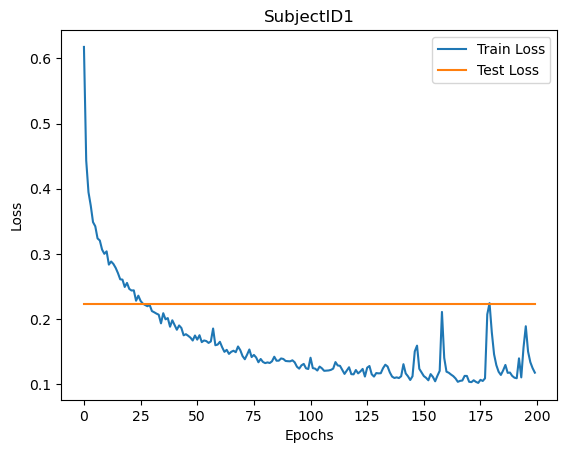

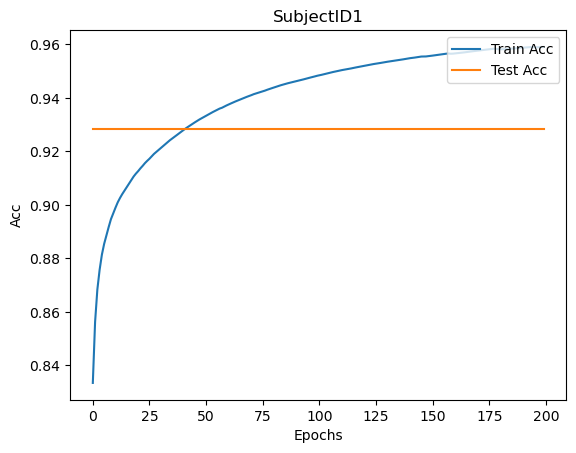

~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~

Subject 2
| epoch   0 | 0.4193 s/epoch | train loss 0.6088
| epoch   1 | 0.4188 s/epoch | train loss 0.4416
| epoch   2 | 0.4283 s/epoch | train loss 0.3880
| epoch   3 | 0.4285 s/epoch | train loss 0.3695
| epoch   4 | 0.4360 s/epoch | train loss 0.3604
| epoch   5 | 0.4374 s/epoch | train loss 0.3348
| epoch   6 | 0.4375 s/epoch | train loss 0.3238
| epoch   7 | 0.4337 s/epoch | train loss 0.3102
| epoch   8 | 0.4283 s/epoch | train loss 0.3115
| epoch   9 | 0.4249 s/epoch | train loss 0.3018
| epoch  10 | 0.4201 s/epoch | train loss 0.2882
| epoch  11 | 0.4336 s/epoch | train loss 0.2879
| epoch  12 | 0.4239 s/epoch | train loss 0.2721
| epoch  13 | 0.4233 s/epoch | train loss 0.2657
| epoch  14 | 0.4348 s/epoch | train loss 0.2638
| 

| epoch 162 | 0.4142 s/epoch | train loss 0.1004
| epoch 163 | 0.4158 s/epoch | train loss 0.1053
| epoch 164 | 0.4165 s/epoch | train loss 0.1144
| epoch 165 | 0.4104 s/epoch | train loss 0.1079
| epoch 166 | 0.4117 s/epoch | train loss 0.1074
| epoch 167 | 0.4098 s/epoch | train loss 0.0990
| epoch 168 | 0.4132 s/epoch | train loss 0.1001
| epoch 169 | 0.4183 s/epoch | train loss 0.1068
| epoch 170 | 0.4120 s/epoch | train loss 0.1003
| epoch 171 | 0.4129 s/epoch | train loss 0.1007
| epoch 172 | 0.4168 s/epoch | train loss 0.1020
| epoch 173 | 0.4178 s/epoch | train loss 0.1003
| epoch 174 | 0.4131 s/epoch | train loss 0.1004
| epoch 175 | 0.4082 s/epoch | train loss 0.1049
| epoch 176 | 0.4054 s/epoch | train loss 0.1107
| epoch 177 | 0.4143 s/epoch | train loss 0.1520
| epoch 178 | 0.4145 s/epoch | train loss 0.1099
| epoch 179 | 0.4164 s/epoch | train loss 0.1039
| epoch 180 | 0.4150 s/epoch | train loss 0.0997
| epoch 181 | 0.4161 s/epoch | train loss 0.1014
| epoch 182 | 0.4169

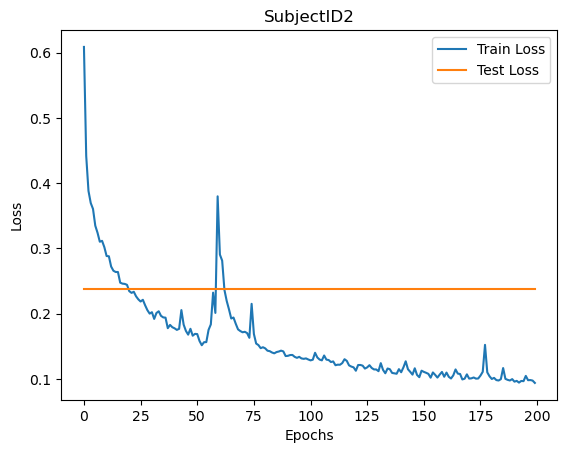

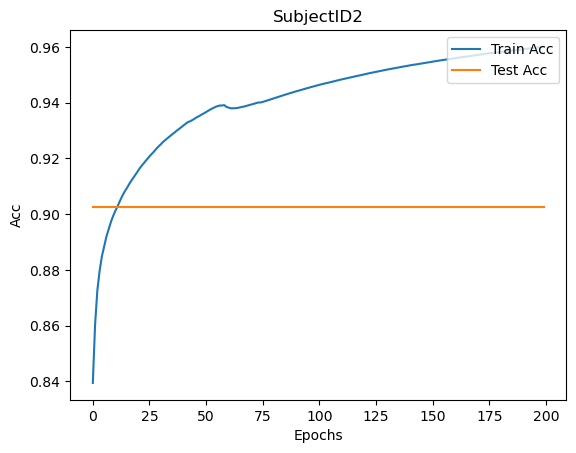


Subject 3
| epoch   0 | 0.4147 s/epoch | train loss 0.5891
| epoch   1 | 0.4152 s/epoch | train loss 0.4352
| epoch   2 | 0.4087 s/epoch | train loss 0.3864
| epoch   3 | 0.4161 s/epoch | train loss 0.3668
| epoch   4 | 0.4115 s/epoch | train loss 0.3484
| epoch   5 | 0.4083 s/epoch | train loss 0.3332
| epoch   6 | 0.4196 s/epoch | train loss 0.3236
| epoch   7 | 0.4139 s/epoch | train loss 0.3064
| epoch   8 | 0.4156 s/epoch | train loss 0.2906
| epoch   9 | 0.4189 s/epoch | train loss 0.2830
| epoch  10 | 0.4145 s/epoch | train loss 0.2826
| epoch  11 | 0.4166 s/epoch | train loss 0.2779
| epoch  12 | 0.4130 s/epoch | train loss 0.2677
| epoch  13 | 0.4117 s/epoch | train loss 0.2597
| epoch  14 | 0.4158 s/epoch | train loss 0.2514
| epoch  15 | 0.4105 s/epoch | train loss 0.2568
| epoch  16 | 0.4170 s/epoch | train loss 0.2474
| epoch  17 | 0.4115 s/epoch | train loss 0.2431
| epoch  18 | 0.4191 s/epoch | train loss 0.2406
| epoch  19 | 0.4149 s/epoch | train loss 0.2374
| epoch  

| epoch 167 | 0.4139 s/epoch | train loss 0.1061
| epoch 168 | 0.4130 s/epoch | train loss 0.1062
| epoch 169 | 0.4114 s/epoch | train loss 0.1038
| epoch 170 | 0.4076 s/epoch | train loss 0.1038
| epoch 171 | 0.4090 s/epoch | train loss 0.1035
| epoch 172 | 0.4088 s/epoch | train loss 0.1053
| epoch 173 | 0.4169 s/epoch | train loss 0.1071
| epoch 174 | 0.4112 s/epoch | train loss 0.1114
| epoch 175 | 0.4160 s/epoch | train loss 0.1037
| epoch 176 | 0.4171 s/epoch | train loss 0.1037
| epoch 177 | 0.4148 s/epoch | train loss 0.1037
| epoch 178 | 0.4148 s/epoch | train loss 0.1031
| epoch 179 | 0.4152 s/epoch | train loss 0.1405
| epoch 180 | 0.4121 s/epoch | train loss 0.1294
| epoch 181 | 0.4142 s/epoch | train loss 0.1089
| epoch 182 | 0.4156 s/epoch | train loss 0.1033
| epoch 183 | 0.4132 s/epoch | train loss 0.1033
| epoch 184 | 0.4152 s/epoch | train loss 0.1050
| epoch 185 | 0.4170 s/epoch | train loss 0.1194
| epoch 186 | 0.4162 s/epoch | train loss 0.1137
| epoch 187 | 0.4125

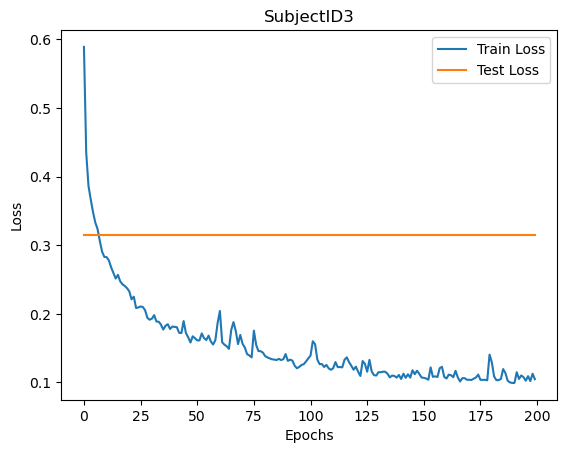

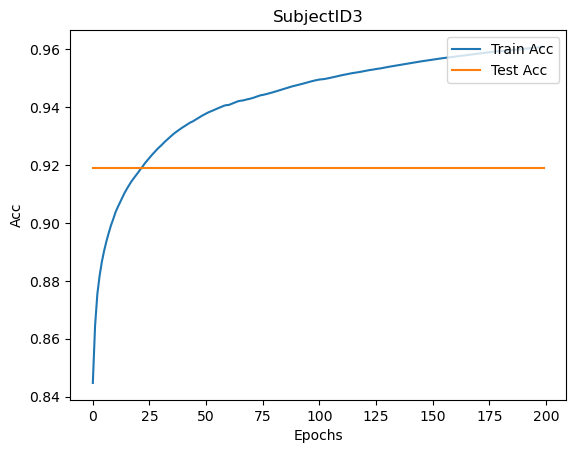


Subject 4
| epoch   0 | 0.4069 s/epoch | train loss 0.6610
| epoch   1 | 0.4119 s/epoch | train loss 0.4368
| epoch   2 | 0.4136 s/epoch | train loss 0.3922
| epoch   3 | 0.4101 s/epoch | train loss 0.3652
| epoch   4 | 0.4198 s/epoch | train loss 0.3504
| epoch   5 | 0.4128 s/epoch | train loss 0.3437
| epoch   6 | 0.4104 s/epoch | train loss 0.3181
| epoch   7 | 0.4152 s/epoch | train loss 0.3177
| epoch   8 | 0.4175 s/epoch | train loss 0.3015
| epoch   9 | 0.4152 s/epoch | train loss 0.2914
| epoch  10 | 0.4122 s/epoch | train loss 0.2791
| epoch  11 | 0.4148 s/epoch | train loss 0.2829
| epoch  12 | 0.4119 s/epoch | train loss 0.2721
| epoch  13 | 0.4171 s/epoch | train loss 0.2690
| epoch  14 | 0.4165 s/epoch | train loss 0.2695
| epoch  15 | 0.4150 s/epoch | train loss 0.2533
| epoch  16 | 0.4110 s/epoch | train loss 0.2493
| epoch  17 | 0.4169 s/epoch | train loss 0.2419
| epoch  18 | 0.4121 s/epoch | train loss 0.2452
| epoch  19 | 0.4094 s/epoch | train loss 0.2336
| epoch  

| epoch 167 | 0.4168 s/epoch | train loss 0.1720
| epoch 168 | 0.4100 s/epoch | train loss 0.1736
| epoch 169 | 0.4142 s/epoch | train loss 0.1635
| epoch 170 | 0.4176 s/epoch | train loss 0.1572
| epoch 171 | 0.4121 s/epoch | train loss 0.1755
| epoch 172 | 0.4147 s/epoch | train loss 0.1675
| epoch 173 | 0.4158 s/epoch | train loss 0.1625
| epoch 174 | 0.4160 s/epoch | train loss 0.1501
| epoch 175 | 0.4165 s/epoch | train loss 0.1721
| epoch 176 | 0.4105 s/epoch | train loss 0.2287
| epoch 177 | 0.4153 s/epoch | train loss 0.2148
| epoch 178 | 0.4123 s/epoch | train loss 0.1861
| epoch 179 | 0.4097 s/epoch | train loss 0.1674
| epoch 180 | 0.4128 s/epoch | train loss 0.1503
| epoch 181 | 0.4129 s/epoch | train loss 0.1562
| epoch 182 | 0.4149 s/epoch | train loss 0.1737
| epoch 183 | 0.4080 s/epoch | train loss 0.1528
| epoch 184 | 0.4123 s/epoch | train loss 0.1406
| epoch 185 | 0.4146 s/epoch | train loss 0.1416
| epoch 186 | 0.4175 s/epoch | train loss 0.1424
| epoch 187 | 0.4147

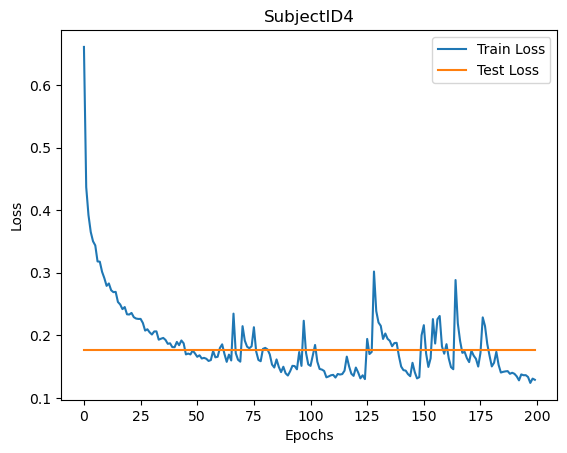

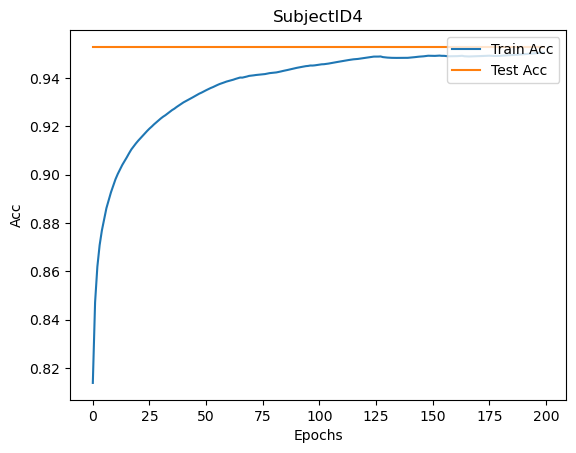


Subject 5
| epoch   0 | 0.4121 s/epoch | train loss 0.6111
| epoch   1 | 0.4100 s/epoch | train loss 0.4383
| epoch   2 | 0.4124 s/epoch | train loss 0.3942
| epoch   3 | 0.4090 s/epoch | train loss 0.3842
| epoch   4 | 0.4078 s/epoch | train loss 0.3595
| epoch   5 | 0.4105 s/epoch | train loss 0.3441
| epoch   6 | 0.4109 s/epoch | train loss 0.3294
| epoch   7 | 0.4148 s/epoch | train loss 0.3254
| epoch   8 | 0.4131 s/epoch | train loss 0.3085
| epoch   9 | 0.4112 s/epoch | train loss 0.3056
| epoch  10 | 0.4126 s/epoch | train loss 0.2969
| epoch  11 | 0.4128 s/epoch | train loss 0.2855
| epoch  12 | 0.4155 s/epoch | train loss 0.2885
| epoch  13 | 0.4155 s/epoch | train loss 0.2779
| epoch  14 | 0.4165 s/epoch | train loss 0.2781
| epoch  15 | 0.4081 s/epoch | train loss 0.2604
| epoch  16 | 0.4111 s/epoch | train loss 0.2578
| epoch  17 | 0.4117 s/epoch | train loss 0.2529
| epoch  18 | 0.4078 s/epoch | train loss 0.2515
| epoch  19 | 0.4106 s/epoch | train loss 0.2368
| epoch  

| epoch 167 | 0.4127 s/epoch | train loss 0.1148
| epoch 168 | 0.4175 s/epoch | train loss 0.1077
| epoch 169 | 0.4099 s/epoch | train loss 0.1171
| epoch 170 | 0.4115 s/epoch | train loss 0.1069
| epoch 171 | 0.4158 s/epoch | train loss 0.1012
| epoch 172 | 0.4136 s/epoch | train loss 0.1070
| epoch 173 | 0.4138 s/epoch | train loss 0.1071
| epoch 174 | 0.4128 s/epoch | train loss 0.1102
| epoch 175 | 0.4144 s/epoch | train loss 0.1024
| epoch 176 | 0.4130 s/epoch | train loss 0.1081
| epoch 177 | 0.4141 s/epoch | train loss 0.1018
| epoch 178 | 0.4145 s/epoch | train loss 0.1003
| epoch 179 | 0.4147 s/epoch | train loss 0.1083
| epoch 180 | 0.4163 s/epoch | train loss 0.1137
| epoch 181 | 0.4082 s/epoch | train loss 0.1287
| epoch 182 | 0.4182 s/epoch | train loss 0.1118
| epoch 183 | 0.4151 s/epoch | train loss 0.1031
| epoch 184 | 0.4125 s/epoch | train loss 0.1016
| epoch 185 | 0.4166 s/epoch | train loss 0.0986
| epoch 186 | 0.4144 s/epoch | train loss 0.0969
| epoch 187 | 0.4182

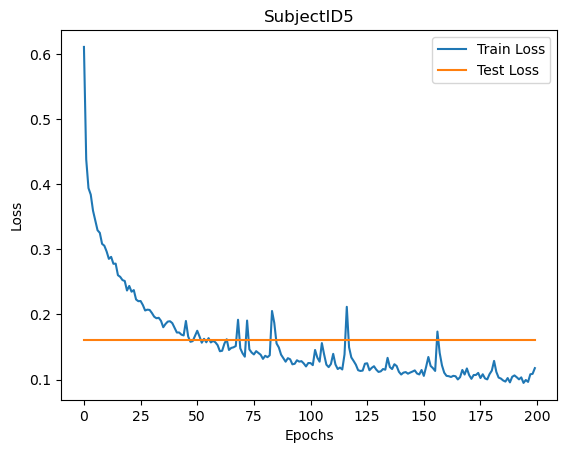

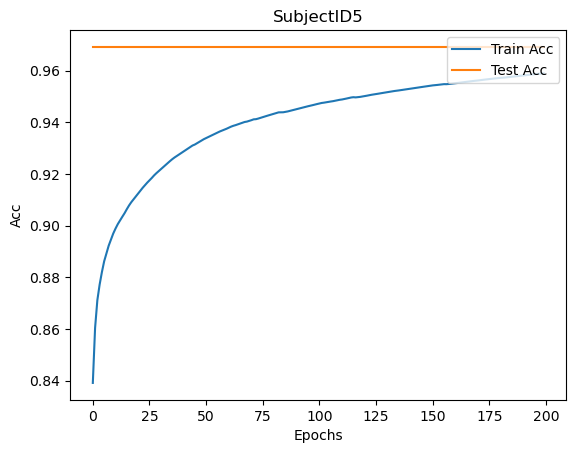


Subject 7
| epoch   0 | 0.4149 s/epoch | train loss 0.6228
| epoch   1 | 0.4118 s/epoch | train loss 0.4389
| epoch   2 | 0.4159 s/epoch | train loss 0.3982
| epoch   3 | 0.4143 s/epoch | train loss 0.3875
| epoch   4 | 0.4116 s/epoch | train loss 0.3571
| epoch   5 | 0.4149 s/epoch | train loss 0.3449
| epoch   6 | 0.4166 s/epoch | train loss 0.3340
| epoch   7 | 0.4120 s/epoch | train loss 0.3335
| epoch   8 | 0.4114 s/epoch | train loss 0.3137
| epoch   9 | 0.4149 s/epoch | train loss 0.3171
| epoch  10 | 0.4121 s/epoch | train loss 0.2996
| epoch  11 | 0.4133 s/epoch | train loss 0.2922
| epoch  12 | 0.4143 s/epoch | train loss 0.2904
| epoch  13 | 0.4163 s/epoch | train loss 0.2870
| epoch  14 | 0.4129 s/epoch | train loss 0.2787
| epoch  15 | 0.4163 s/epoch | train loss 0.2625
| epoch  16 | 0.4152 s/epoch | train loss 0.2626
| epoch  17 | 0.4115 s/epoch | train loss 0.2628
| epoch  18 | 0.4114 s/epoch | train loss 0.2499
| epoch  19 | 0.4180 s/epoch | train loss 0.2506
| epoch  

| epoch 167 | 0.4086 s/epoch | train loss 0.1159
| epoch 168 | 0.4027 s/epoch | train loss 0.1130
| epoch 169 | 0.4058 s/epoch | train loss 0.1129
| epoch 170 | 0.4089 s/epoch | train loss 0.1113
| epoch 171 | 0.4095 s/epoch | train loss 0.1122
| epoch 172 | 0.4102 s/epoch | train loss 0.1340
| epoch 173 | 0.4109 s/epoch | train loss 0.1421
| epoch 174 | 0.4130 s/epoch | train loss 0.1311
| epoch 175 | 0.4086 s/epoch | train loss 0.1151
| epoch 176 | 0.4094 s/epoch | train loss 0.1142
| epoch 177 | 0.4037 s/epoch | train loss 0.1268
| epoch 178 | 0.4066 s/epoch | train loss 0.1201
| epoch 179 | 0.4155 s/epoch | train loss 0.1128
| epoch 180 | 0.4126 s/epoch | train loss 0.1124
| epoch 181 | 0.4136 s/epoch | train loss 0.1215
| epoch 182 | 0.4163 s/epoch | train loss 0.1159
| epoch 183 | 0.4115 s/epoch | train loss 0.1242
| epoch 184 | 0.4112 s/epoch | train loss 0.1181
| epoch 185 | 0.4130 s/epoch | train loss 0.1134
| epoch 186 | 0.4134 s/epoch | train loss 0.1162
| epoch 187 | 0.4128

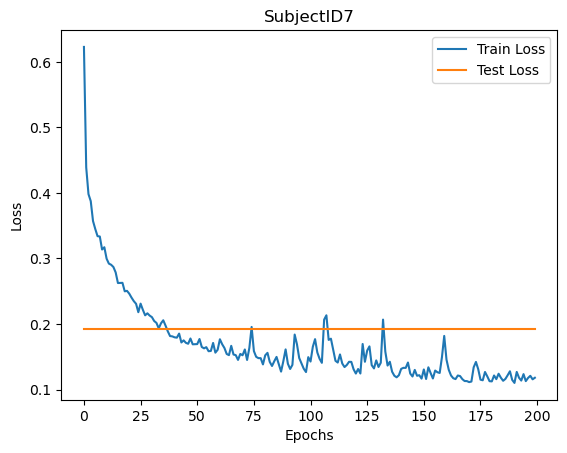

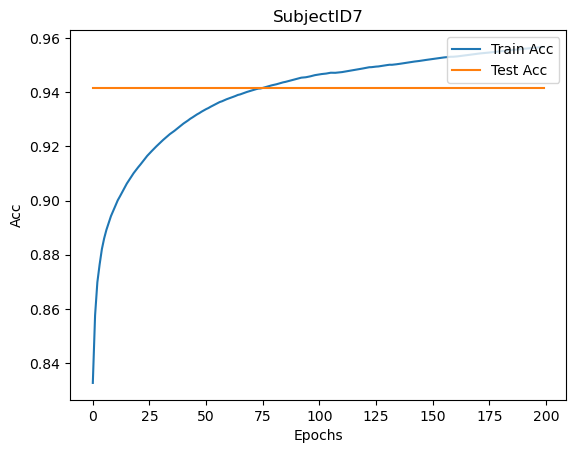


Subject 8
| epoch   0 | 0.4139 s/epoch | train loss 0.6683
| epoch   1 | 0.4096 s/epoch | train loss 0.4576
| epoch   2 | 0.4143 s/epoch | train loss 0.4042
| epoch   3 | 0.4153 s/epoch | train loss 0.3808
| epoch   4 | 0.4144 s/epoch | train loss 0.3730
| epoch   5 | 0.4148 s/epoch | train loss 0.3597
| epoch   6 | 0.4114 s/epoch | train loss 0.3404
| epoch   7 | 0.4116 s/epoch | train loss 0.3286
| epoch   8 | 0.4130 s/epoch | train loss 0.3246
| epoch   9 | 0.4151 s/epoch | train loss 0.3149
| epoch  10 | 0.4110 s/epoch | train loss 0.3076
| epoch  11 | 0.4115 s/epoch | train loss 0.2977
| epoch  12 | 0.4086 s/epoch | train loss 0.2810
| epoch  13 | 0.4154 s/epoch | train loss 0.2883
| epoch  14 | 0.4122 s/epoch | train loss 0.2862
| epoch  15 | 0.4133 s/epoch | train loss 0.2754
| epoch  16 | 0.4187 s/epoch | train loss 0.2698
| epoch  17 | 0.4145 s/epoch | train loss 0.2592
| epoch  18 | 0.4116 s/epoch | train loss 0.2593
| epoch  19 | 0.4109 s/epoch | train loss 0.2537
| epoch  

| epoch 167 | 0.4145 s/epoch | train loss 0.1159
| epoch 168 | 0.4144 s/epoch | train loss 0.1221
| epoch 169 | 0.4147 s/epoch | train loss 0.2185
| epoch 170 | 0.4112 s/epoch | train loss 0.1461
| epoch 171 | 0.4120 s/epoch | train loss 0.1436
| epoch 172 | 0.4129 s/epoch | train loss 0.1736
| epoch 173 | 0.4116 s/epoch | train loss 0.1535
| epoch 174 | 0.4138 s/epoch | train loss 0.1589
| epoch 175 | 0.4199 s/epoch | train loss 0.1666
| epoch 176 | 0.4129 s/epoch | train loss 0.1756
| epoch 177 | 0.4147 s/epoch | train loss 0.1489
| epoch 178 | 0.4180 s/epoch | train loss 0.1429
| epoch 179 | 0.4135 s/epoch | train loss 0.1758
| epoch 180 | 0.4161 s/epoch | train loss 0.3192
| epoch 181 | 0.4078 s/epoch | train loss 0.2326
| epoch 182 | 0.4122 s/epoch | train loss 0.1981
| epoch 183 | 0.4146 s/epoch | train loss 0.1749
| epoch 184 | 0.4178 s/epoch | train loss 0.1581
| epoch 185 | 0.4115 s/epoch | train loss 0.1683
| epoch 186 | 0.4105 s/epoch | train loss 0.1407
| epoch 187 | 0.4117

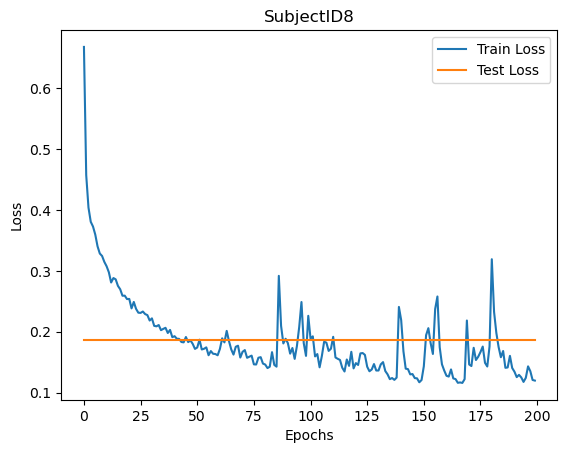

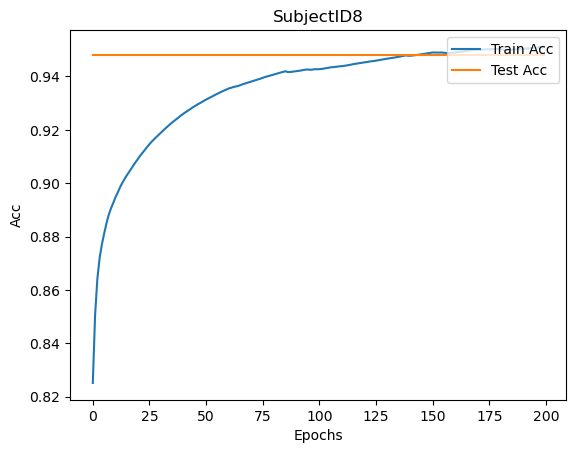


Subject 9
| epoch   0 | 0.4146 s/epoch | train loss 0.6250
| epoch   1 | 0.4132 s/epoch | train loss 0.4263
| epoch   2 | 0.4160 s/epoch | train loss 0.3808
| epoch   3 | 0.4148 s/epoch | train loss 0.3632
| epoch   4 | 0.4160 s/epoch | train loss 0.3487
| epoch   5 | 0.4148 s/epoch | train loss 0.3263
| epoch   6 | 0.4139 s/epoch | train loss 0.3202
| epoch   7 | 0.4133 s/epoch | train loss 0.3044
| epoch   8 | 0.4121 s/epoch | train loss 0.2958
| epoch   9 | 0.4169 s/epoch | train loss 0.2943
| epoch  10 | 0.4161 s/epoch | train loss 0.2806
| epoch  11 | 0.4136 s/epoch | train loss 0.2764
| epoch  12 | 0.4160 s/epoch | train loss 0.2683
| epoch  13 | 0.4134 s/epoch | train loss 0.2571
| epoch  14 | 0.4155 s/epoch | train loss 0.2543
| epoch  15 | 0.4103 s/epoch | train loss 0.2427
| epoch  16 | 0.4142 s/epoch | train loss 0.2449
| epoch  17 | 0.4168 s/epoch | train loss 0.2537
| epoch  18 | 0.6192 s/epoch | train loss 0.2329
| epoch  19 | 0.4787 s/epoch | train loss 0.2352
| epoch  

| epoch 167 | 0.5027 s/epoch | train loss 0.1195
| epoch 168 | 0.5454 s/epoch | train loss 0.1131
| epoch 169 | 0.4889 s/epoch | train loss 0.1060
| epoch 170 | 0.5260 s/epoch | train loss 0.1142
| epoch 171 | 0.4973 s/epoch | train loss 0.1110
| epoch 172 | 0.5042 s/epoch | train loss 0.1060
| epoch 173 | 0.5153 s/epoch | train loss 0.1093
| epoch 174 | 0.5154 s/epoch | train loss 0.1174
| epoch 175 | 0.4889 s/epoch | train loss 0.1140
| epoch 176 | 0.5180 s/epoch | train loss 0.1136
| epoch 177 | 0.5208 s/epoch | train loss 0.1172
| epoch 178 | 0.5075 s/epoch | train loss 0.1125
| epoch 179 | 0.5108 s/epoch | train loss 0.1102
| epoch 180 | 0.5184 s/epoch | train loss 0.1106
| epoch 181 | 0.5033 s/epoch | train loss 0.1043
| epoch 182 | 0.5073 s/epoch | train loss 0.1123
| epoch 183 | 0.5177 s/epoch | train loss 0.1053
| epoch 184 | 0.5077 s/epoch | train loss 0.1087
| epoch 185 | 0.5092 s/epoch | train loss 0.1033
| epoch 186 | 0.4834 s/epoch | train loss 0.1061
| epoch 187 | 0.5140

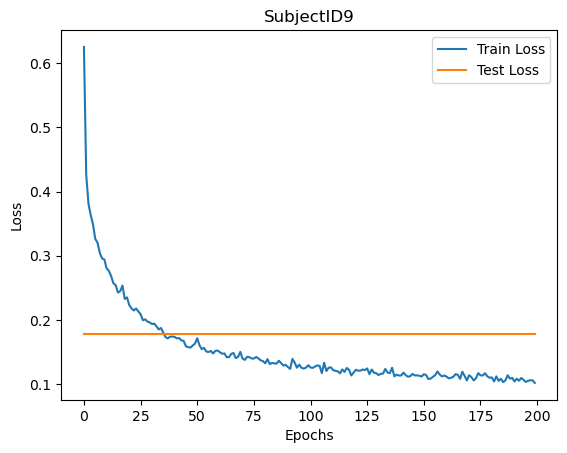

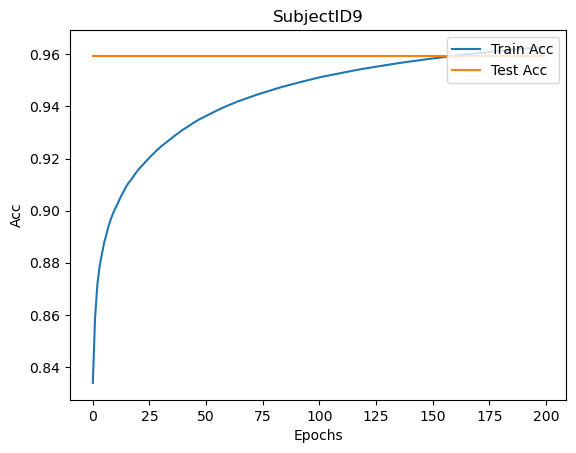


Subject 10
| epoch   0 | 0.4537 s/epoch | train loss 0.5925
| epoch   1 | 0.4779 s/epoch | train loss 0.4310
| epoch   2 | 0.5159 s/epoch | train loss 0.3829
| epoch   3 | 0.4832 s/epoch | train loss 0.3565
| epoch   4 | 0.4538 s/epoch | train loss 0.3445
| epoch   5 | 0.4832 s/epoch | train loss 0.3369
| epoch   6 | 0.4654 s/epoch | train loss 0.3322
| epoch   7 | 0.4748 s/epoch | train loss 0.3328
| epoch   8 | 0.4744 s/epoch | train loss 0.3086
| epoch   9 | 0.4632 s/epoch | train loss 0.3084
| epoch  10 | 0.4693 s/epoch | train loss 0.3036
| epoch  11 | 0.4696 s/epoch | train loss 0.2949
| epoch  12 | 0.4819 s/epoch | train loss 0.2824
| epoch  13 | 0.5231 s/epoch | train loss 0.2830
| epoch  14 | 0.5089 s/epoch | train loss 0.2798
| epoch  15 | 0.4733 s/epoch | train loss 0.2743
| epoch  16 | 0.4781 s/epoch | train loss 0.2679
| epoch  17 | 0.5229 s/epoch | train loss 0.2660
| epoch  18 | 0.5182 s/epoch | train loss 0.2694
| epoch  19 | 0.5534 s/epoch | train loss 0.2545
| epoch 

| epoch 167 | 0.5004 s/epoch | train loss 0.1218
| epoch 168 | 0.5495 s/epoch | train loss 0.1176
| epoch 169 | 0.5113 s/epoch | train loss 0.1176
| epoch 170 | 0.4917 s/epoch | train loss 0.1165
| epoch 171 | 0.4768 s/epoch | train loss 0.1247
| epoch 172 | 0.4953 s/epoch | train loss 0.1194
| epoch 173 | 0.5017 s/epoch | train loss 0.1180
| epoch 174 | 0.4892 s/epoch | train loss 0.2223
| epoch 175 | 0.4962 s/epoch | train loss 0.1692
| epoch 176 | 0.5223 s/epoch | train loss 0.1531
| epoch 177 | 0.4876 s/epoch | train loss 0.1430
| epoch 178 | 0.4518 s/epoch | train loss 0.1325
| epoch 179 | 0.4508 s/epoch | train loss 0.1304
| epoch 180 | 0.4632 s/epoch | train loss 0.1241
| epoch 181 | 0.4970 s/epoch | train loss 0.1203
| epoch 182 | 0.5025 s/epoch | train loss 0.1209
| epoch 183 | 0.4726 s/epoch | train loss 0.1178
| epoch 184 | 0.4769 s/epoch | train loss 0.1181
| epoch 185 | 0.4597 s/epoch | train loss 0.1194
| epoch 186 | 0.4912 s/epoch | train loss 0.1155
| epoch 187 | 0.4745

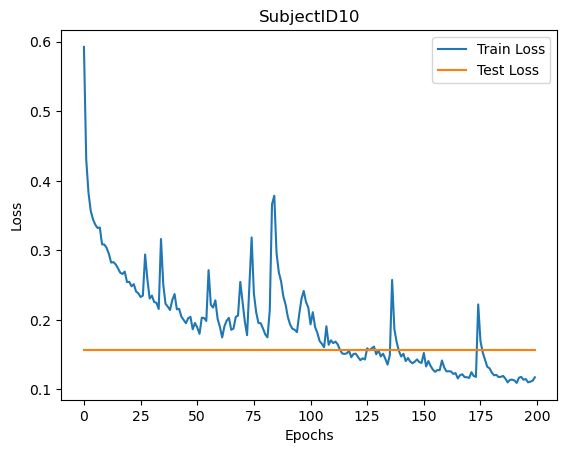

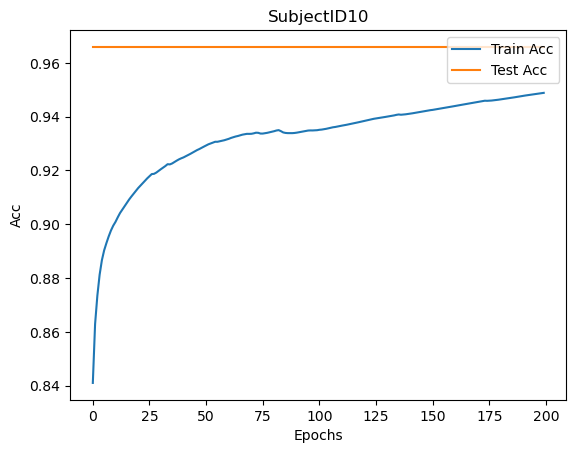


Subject 11
| epoch   0 | 0.4869 s/epoch | train loss 0.6585
| epoch   1 | 0.5235 s/epoch | train loss 0.4289
| epoch   2 | 0.5074 s/epoch | train loss 0.3953
| epoch   3 | 0.5057 s/epoch | train loss 0.3718
| epoch   4 | 0.5014 s/epoch | train loss 0.3467
| epoch   5 | 0.4886 s/epoch | train loss 0.3285
| epoch   6 | 0.5065 s/epoch | train loss 0.3223
| epoch   7 | 0.5164 s/epoch | train loss 0.3005
| epoch   8 | 0.4925 s/epoch | train loss 0.2923
| epoch   9 | 0.4930 s/epoch | train loss 0.2998
| epoch  10 | 0.4941 s/epoch | train loss 0.2843
| epoch  11 | 0.4813 s/epoch | train loss 0.2723
| epoch  12 | 0.5242 s/epoch | train loss 0.2774
| epoch  13 | 0.4924 s/epoch | train loss 0.2600
| epoch  14 | 0.4772 s/epoch | train loss 0.2588
| epoch  15 | 0.4405 s/epoch | train loss 0.2554
| epoch  16 | 0.4507 s/epoch | train loss 0.2503
| epoch  17 | 0.4318 s/epoch | train loss 0.2381
| epoch  18 | 0.4461 s/epoch | train loss 0.2315
| epoch  19 | 0.4320 s/epoch | train loss 0.2247
| epoch 

| epoch 167 | 0.4123 s/epoch | train loss 0.1102
| epoch 168 | 0.4113 s/epoch | train loss 0.1153
| epoch 169 | 0.4136 s/epoch | train loss 0.1150
| epoch 170 | 0.4071 s/epoch | train loss 0.1084
| epoch 171 | 0.4046 s/epoch | train loss 0.1038
| epoch 172 | 0.4081 s/epoch | train loss 0.1227
| epoch 173 | 0.4096 s/epoch | train loss 0.1174
| epoch 174 | 0.4155 s/epoch | train loss 0.1399
| epoch 175 | 0.4095 s/epoch | train loss 0.1195
| epoch 176 | 0.4114 s/epoch | train loss 0.1112
| epoch 177 | 0.4101 s/epoch | train loss 0.1076
| epoch 178 | 0.4163 s/epoch | train loss 0.1212
| epoch 179 | 0.4095 s/epoch | train loss 0.1144
| epoch 180 | 0.4131 s/epoch | train loss 0.1195
| epoch 181 | 0.4135 s/epoch | train loss 0.1268
| epoch 182 | 0.4107 s/epoch | train loss 0.1235
| epoch 183 | 0.4144 s/epoch | train loss 0.1148
| epoch 184 | 0.4066 s/epoch | train loss 0.1162
| epoch 185 | 0.4075 s/epoch | train loss 0.1152
| epoch 186 | 0.4096 s/epoch | train loss 0.1254
| epoch 187 | 0.4123

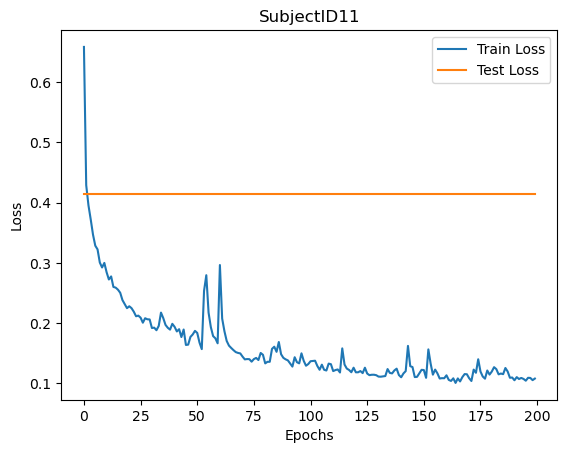

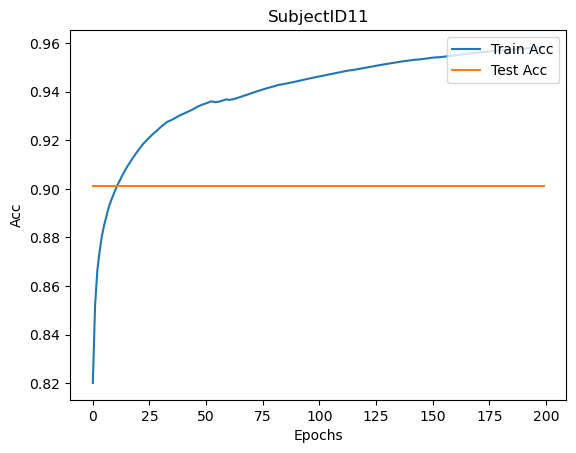


Subject 12
| epoch   0 | 0.4129 s/epoch | train loss 0.6172
| epoch   1 | 0.4098 s/epoch | train loss 0.4420
| epoch   2 | 0.4080 s/epoch | train loss 0.4096
| epoch   3 | 0.4125 s/epoch | train loss 0.3713
| epoch   4 | 0.4146 s/epoch | train loss 0.3591
| epoch   5 | 0.4084 s/epoch | train loss 0.3394
| epoch   6 | 0.4112 s/epoch | train loss 0.3277
| epoch   7 | 0.4137 s/epoch | train loss 0.3213
| epoch   8 | 0.4143 s/epoch | train loss 0.3116
| epoch   9 | 0.4110 s/epoch | train loss 0.3098
| epoch  10 | 0.4115 s/epoch | train loss 0.2947
| epoch  11 | 0.4117 s/epoch | train loss 0.2983
| epoch  12 | 0.3986 s/epoch | train loss 0.2713
| epoch  13 | 0.4065 s/epoch | train loss 0.2798
| epoch  14 | 0.4097 s/epoch | train loss 0.2692
| epoch  15 | 0.4125 s/epoch | train loss 0.2550
| epoch  16 | 0.4123 s/epoch | train loss 0.2690
| epoch  17 | 0.4108 s/epoch | train loss 0.2507
| epoch  18 | 0.4103 s/epoch | train loss 0.2530
| epoch  19 | 0.4115 s/epoch | train loss 0.2471
| epoch 

| epoch 167 | 0.4145 s/epoch | train loss 0.1009
| epoch 168 | 0.4159 s/epoch | train loss 0.1018
| epoch 169 | 0.4166 s/epoch | train loss 0.1036
| epoch 170 | 0.4147 s/epoch | train loss 0.1098
| epoch 171 | 0.4104 s/epoch | train loss 0.1042
| epoch 172 | 0.4168 s/epoch | train loss 0.1036
| epoch 173 | 0.4113 s/epoch | train loss 0.0997
| epoch 174 | 0.4163 s/epoch | train loss 0.1008
| epoch 175 | 0.4120 s/epoch | train loss 0.1025
| epoch 176 | 0.4176 s/epoch | train loss 0.1075
| epoch 177 | 0.4129 s/epoch | train loss 0.0973
| epoch 178 | 0.4150 s/epoch | train loss 0.1019
| epoch 179 | 0.4151 s/epoch | train loss 0.1053
| epoch 180 | 0.4152 s/epoch | train loss 0.1094
| epoch 181 | 0.4158 s/epoch | train loss 0.1071
| epoch 182 | 0.4115 s/epoch | train loss 0.1058
| epoch 183 | 0.4146 s/epoch | train loss 0.0955
| epoch 184 | 0.4137 s/epoch | train loss 0.0979
| epoch 185 | 0.4083 s/epoch | train loss 0.0996
| epoch 186 | 0.4087 s/epoch | train loss 0.0976
| epoch 187 | 0.4110

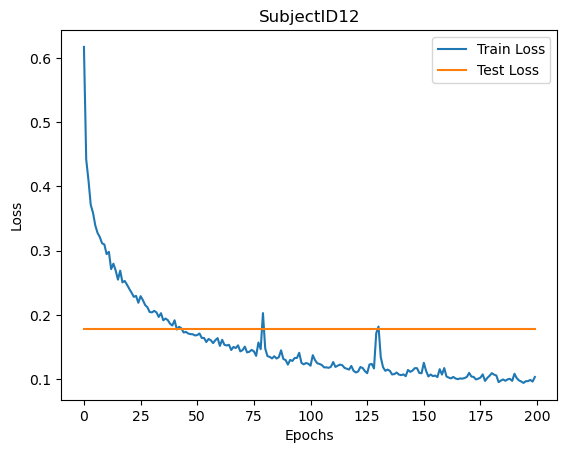

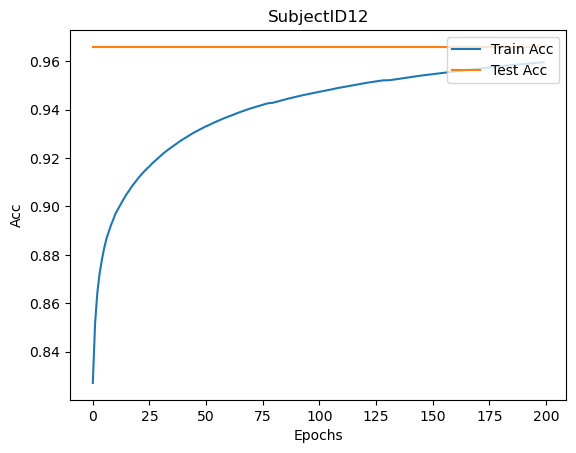


Subject 13
| epoch   0 | 0.4173 s/epoch | train loss 0.6105
| epoch   1 | 0.4169 s/epoch | train loss 0.4228
| epoch   2 | 0.4143 s/epoch | train loss 0.3931
| epoch   3 | 0.4140 s/epoch | train loss 0.3632
| epoch   4 | 0.4144 s/epoch | train loss 0.3561
| epoch   5 | 0.4158 s/epoch | train loss 0.3391
| epoch   6 | 0.4144 s/epoch | train loss 0.3231
| epoch   7 | 0.4104 s/epoch | train loss 0.3117
| epoch   8 | 0.4164 s/epoch | train loss 0.3025
| epoch   9 | 0.4115 s/epoch | train loss 0.3043
| epoch  10 | 0.4163 s/epoch | train loss 0.2854
| epoch  11 | 0.4128 s/epoch | train loss 0.2860
| epoch  12 | 0.4132 s/epoch | train loss 0.2841
| epoch  13 | 0.4158 s/epoch | train loss 0.2714
| epoch  14 | 0.4132 s/epoch | train loss 0.2672
| epoch  15 | 0.4145 s/epoch | train loss 0.2689
| epoch  16 | 0.4067 s/epoch | train loss 0.2557
| epoch  17 | 0.4165 s/epoch | train loss 0.2497
| epoch  18 | 0.4153 s/epoch | train loss 0.2591
| epoch  19 | 0.4103 s/epoch | train loss 0.2475
| epoch 

| epoch 167 | 0.4124 s/epoch | train loss 0.1027
| epoch 168 | 0.4118 s/epoch | train loss 0.1028
| epoch 169 | 0.4131 s/epoch | train loss 0.1041
| epoch 170 | 0.4150 s/epoch | train loss 0.0991
| epoch 171 | 0.4076 s/epoch | train loss 0.0980
| epoch 172 | 0.4132 s/epoch | train loss 0.0991
| epoch 173 | 0.4174 s/epoch | train loss 0.0986
| epoch 174 | 0.4146 s/epoch | train loss 0.0983
| epoch 175 | 0.4145 s/epoch | train loss 0.1068
| epoch 176 | 0.4155 s/epoch | train loss 0.1007
| epoch 177 | 0.4139 s/epoch | train loss 0.0980
| epoch 178 | 0.4130 s/epoch | train loss 0.0952
| epoch 179 | 0.4072 s/epoch | train loss 0.0983
| epoch 180 | 0.4159 s/epoch | train loss 0.0982
| epoch 181 | 0.4154 s/epoch | train loss 0.1141
| epoch 182 | 0.4166 s/epoch | train loss 0.1117
| epoch 183 | 0.4110 s/epoch | train loss 0.1319
| epoch 184 | 0.4107 s/epoch | train loss 0.1019
| epoch 185 | 0.4128 s/epoch | train loss 0.1019
| epoch 186 | 0.4141 s/epoch | train loss 0.0927
| epoch 187 | 0.4113

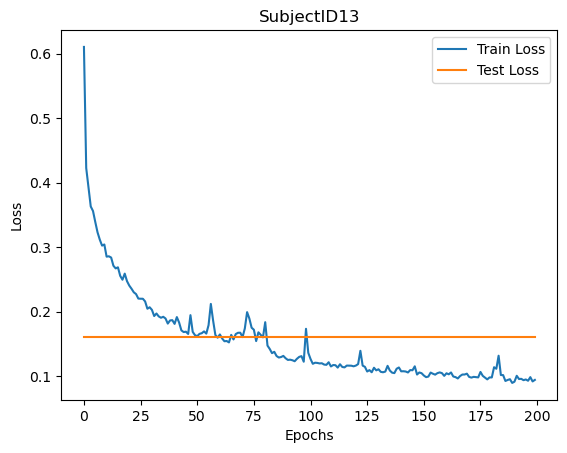

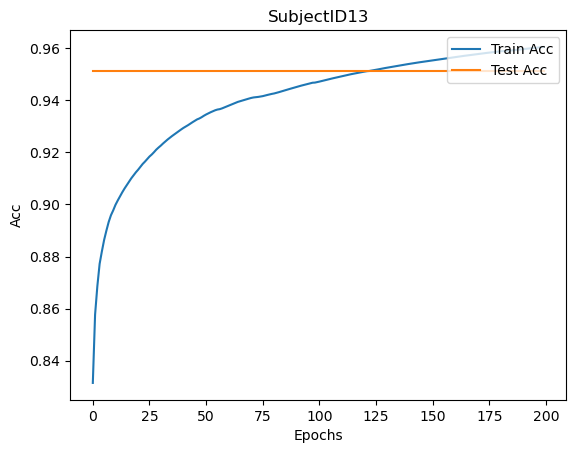


Subject 14
| epoch   0 | 0.4054 s/epoch | train loss 0.6269
| epoch   1 | 0.4056 s/epoch | train loss 0.4252
| epoch   2 | 0.4152 s/epoch | train loss 0.3983
| epoch   3 | 0.4134 s/epoch | train loss 0.3710
| epoch   4 | 0.4154 s/epoch | train loss 0.3512
| epoch   5 | 0.4101 s/epoch | train loss 0.3346
| epoch   6 | 0.4107 s/epoch | train loss 0.3167
| epoch   7 | 0.4088 s/epoch | train loss 0.3079
| epoch   8 | 0.4106 s/epoch | train loss 0.3063
| epoch   9 | 0.4139 s/epoch | train loss 0.2875
| epoch  10 | 0.4127 s/epoch | train loss 0.2705
| epoch  11 | 0.4079 s/epoch | train loss 0.2749
| epoch  12 | 0.4143 s/epoch | train loss 0.2754
| epoch  13 | 0.4140 s/epoch | train loss 0.2695
| epoch  14 | 0.4156 s/epoch | train loss 0.2605
| epoch  15 | 0.4071 s/epoch | train loss 0.2529
| epoch  16 | 0.4092 s/epoch | train loss 0.2500
| epoch  17 | 0.4119 s/epoch | train loss 0.2495
| epoch  18 | 0.4160 s/epoch | train loss 0.2373
| epoch  19 | 0.4123 s/epoch | train loss 0.2313
| epoch 

| epoch 167 | 0.4155 s/epoch | train loss 0.1554
| epoch 168 | 0.4147 s/epoch | train loss 0.1311
| epoch 169 | 0.4119 s/epoch | train loss 0.1237
| epoch 170 | 0.4121 s/epoch | train loss 0.1181
| epoch 171 | 0.4123 s/epoch | train loss 0.1368
| epoch 172 | 0.4190 s/epoch | train loss 0.1227
| epoch 173 | 0.4123 s/epoch | train loss 0.1241
| epoch 174 | 0.4078 s/epoch | train loss 0.1178
| epoch 175 | 0.4205 s/epoch | train loss 0.1186
| epoch 176 | 0.4135 s/epoch | train loss 0.1230
| epoch 177 | 0.4140 s/epoch | train loss 0.1148
| epoch 178 | 0.4151 s/epoch | train loss 0.1367
| epoch 179 | 0.4186 s/epoch | train loss 0.1344
| epoch 180 | 0.4120 s/epoch | train loss 0.1139
| epoch 181 | 0.4136 s/epoch | train loss 0.1158
| epoch 182 | 0.4123 s/epoch | train loss 0.1082
| epoch 183 | 0.4167 s/epoch | train loss 0.1155
| epoch 184 | 0.4117 s/epoch | train loss 0.1541
| epoch 185 | 0.4169 s/epoch | train loss 0.1208
| epoch 186 | 0.4151 s/epoch | train loss 0.1335
| epoch 187 | 0.4129

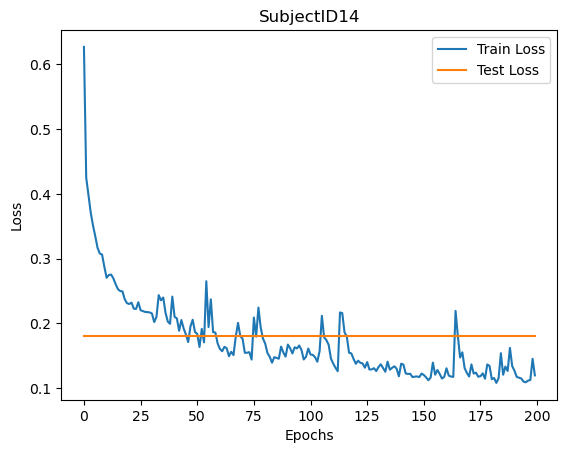

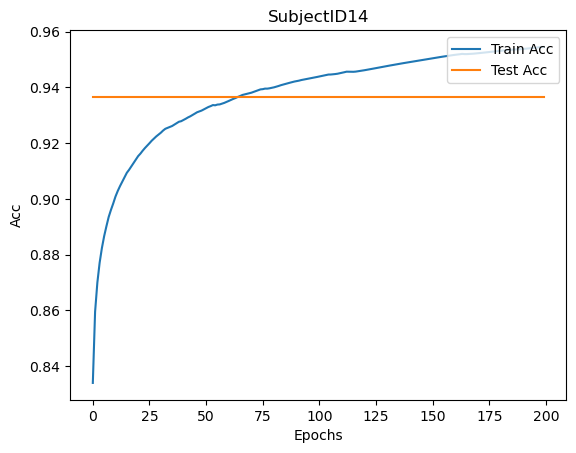


Subject 15
| epoch   0 | 0.4129 s/epoch | train loss 0.6409
| epoch   1 | 0.4106 s/epoch | train loss 0.4458
| epoch   2 | 0.4137 s/epoch | train loss 0.3934
| epoch   3 | 0.4110 s/epoch | train loss 0.3665
| epoch   4 | 0.4137 s/epoch | train loss 0.3449
| epoch   5 | 0.4161 s/epoch | train loss 0.3299
| epoch   6 | 0.4146 s/epoch | train loss 0.3186
| epoch   7 | 0.4181 s/epoch | train loss 0.3228
| epoch   8 | 0.4123 s/epoch | train loss 0.3075
| epoch   9 | 0.4093 s/epoch | train loss 0.2993
| epoch  10 | 0.4102 s/epoch | train loss 0.2973
| epoch  11 | 0.4066 s/epoch | train loss 0.2828
| epoch  12 | 0.4135 s/epoch | train loss 0.2806
| epoch  13 | 0.4171 s/epoch | train loss 0.2713
| epoch  14 | 0.4126 s/epoch | train loss 0.2670
| epoch  15 | 0.4148 s/epoch | train loss 0.2669
| epoch  16 | 0.4096 s/epoch | train loss 0.2509
| epoch  17 | 0.4128 s/epoch | train loss 0.2493
| epoch  18 | 0.4148 s/epoch | train loss 0.2433
| epoch  19 | 0.4131 s/epoch | train loss 0.2418
| epoch 

| epoch 167 | 0.4132 s/epoch | train loss 0.1842
| epoch 168 | 0.4111 s/epoch | train loss 0.1439
| epoch 169 | 0.4123 s/epoch | train loss 0.1473
| epoch 170 | 0.4159 s/epoch | train loss 0.1676
| epoch 171 | 0.4177 s/epoch | train loss 0.1525
| epoch 172 | 0.4168 s/epoch | train loss 0.1337
| epoch 173 | 0.4082 s/epoch | train loss 0.1491
| epoch 174 | 0.4037 s/epoch | train loss 0.1472
| epoch 175 | 0.4151 s/epoch | train loss 0.1561
| epoch 176 | 0.4133 s/epoch | train loss 0.1443
| epoch 177 | 0.4120 s/epoch | train loss 0.2223
| epoch 178 | 0.4170 s/epoch | train loss 0.1889
| epoch 179 | 0.4179 s/epoch | train loss 0.1646
| epoch 180 | 0.4102 s/epoch | train loss 0.1555
| epoch 181 | 0.4146 s/epoch | train loss 0.1390
| epoch 182 | 0.4083 s/epoch | train loss 0.1357
| epoch 183 | 0.4138 s/epoch | train loss 0.1427
| epoch 184 | 0.4058 s/epoch | train loss 0.1361
| epoch 185 | 0.4113 s/epoch | train loss 0.1284
| epoch 186 | 0.4169 s/epoch | train loss 0.1278
| epoch 187 | 0.4144

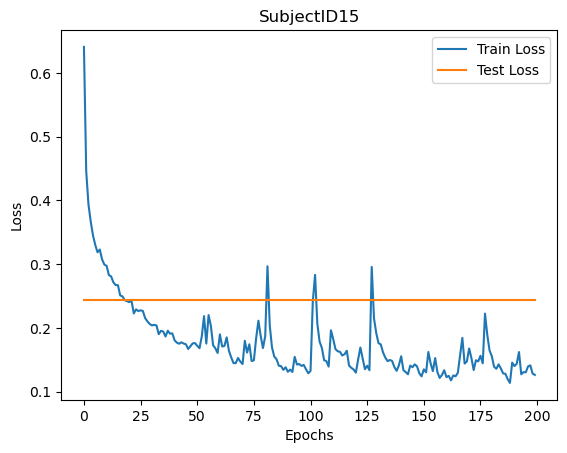

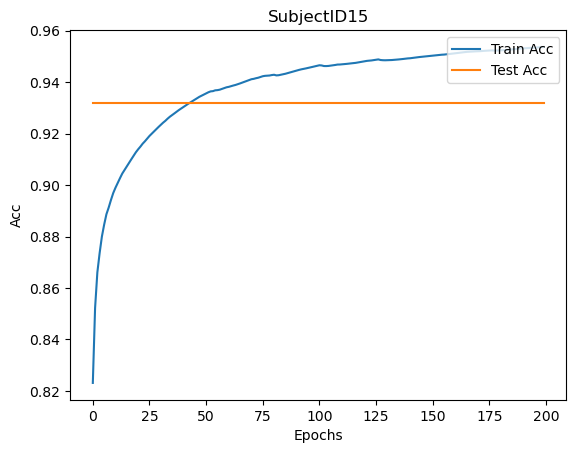


Subject 16
| epoch   0 | 0.4114 s/epoch | train loss 0.6501
| epoch   1 | 0.4105 s/epoch | train loss 0.4499
| epoch   2 | 0.4117 s/epoch | train loss 0.3988
| epoch   3 | 0.4120 s/epoch | train loss 0.3710
| epoch   4 | 0.4182 s/epoch | train loss 0.3549
| epoch   5 | 0.4150 s/epoch | train loss 0.3299
| epoch   6 | 0.4084 s/epoch | train loss 0.3217
| epoch   7 | 0.4090 s/epoch | train loss 0.3181
| epoch   8 | 0.4126 s/epoch | train loss 0.3007
| epoch   9 | 0.4152 s/epoch | train loss 0.2998
| epoch  10 | 0.4106 s/epoch | train loss 0.2843
| epoch  11 | 0.4136 s/epoch | train loss 0.2824
| epoch  12 | 0.4132 s/epoch | train loss 0.2725
| epoch  13 | 0.4130 s/epoch | train loss 0.2805
| epoch  14 | 0.4121 s/epoch | train loss 0.2642
| epoch  15 | 0.4104 s/epoch | train loss 0.2662
| epoch  16 | 0.4130 s/epoch | train loss 0.2538
| epoch  17 | 0.4123 s/epoch | train loss 0.2552
| epoch  18 | 0.4104 s/epoch | train loss 0.2513
| epoch  19 | 0.4130 s/epoch | train loss 0.2407
| epoch 

| epoch 167 | 0.4103 s/epoch | train loss 0.1174
| epoch 168 | 0.4154 s/epoch | train loss 0.1018
| epoch 169 | 0.4164 s/epoch | train loss 0.1000
| epoch 170 | 0.4132 s/epoch | train loss 0.0956
| epoch 171 | 0.4154 s/epoch | train loss 0.0965
| epoch 172 | 0.4120 s/epoch | train loss 0.1029
| epoch 173 | 0.4126 s/epoch | train loss 0.1007
| epoch 174 | 0.4121 s/epoch | train loss 0.0945
| epoch 175 | 0.4142 s/epoch | train loss 0.0960
| epoch 176 | 0.4101 s/epoch | train loss 0.1004
| epoch 177 | 0.4144 s/epoch | train loss 0.0962
| epoch 178 | 0.4144 s/epoch | train loss 0.0959
| epoch 179 | 0.4172 s/epoch | train loss 0.0998
| epoch 180 | 0.4155 s/epoch | train loss 0.0937
| epoch 181 | 0.4145 s/epoch | train loss 0.0977
| epoch 182 | 0.4205 s/epoch | train loss 0.0949
| epoch 183 | 0.4166 s/epoch | train loss 0.0965
| epoch 184 | 0.4122 s/epoch | train loss 0.0964
| epoch 185 | 0.4163 s/epoch | train loss 0.0966
| epoch 186 | 0.4179 s/epoch | train loss 0.0968
| epoch 187 | 0.4140

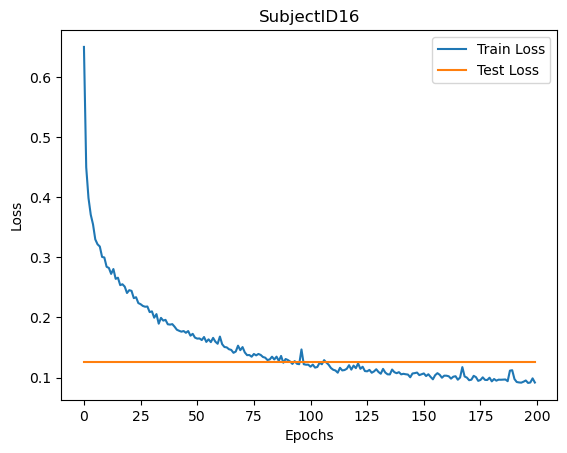

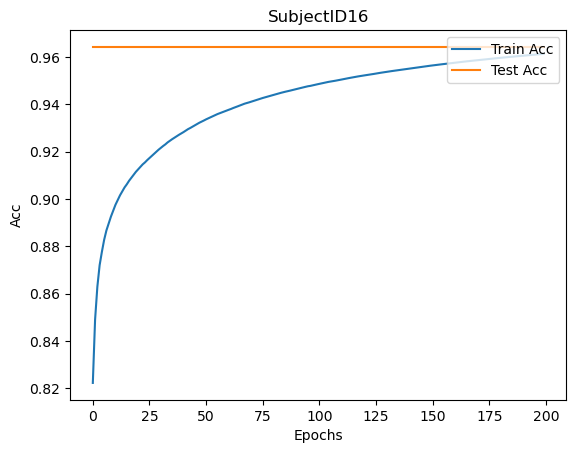


Subject 18
| epoch   0 | 0.4118 s/epoch | train loss 0.6440
| epoch   1 | 0.4117 s/epoch | train loss 0.4401
| epoch   2 | 0.4117 s/epoch | train loss 0.4057
| epoch   3 | 0.4110 s/epoch | train loss 0.3785
| epoch   4 | 0.4110 s/epoch | train loss 0.3590
| epoch   5 | 0.4158 s/epoch | train loss 0.3502
| epoch   6 | 0.4134 s/epoch | train loss 0.3305
| epoch   7 | 0.4165 s/epoch | train loss 0.3238
| epoch   8 | 0.4126 s/epoch | train loss 0.3145
| epoch   9 | 0.4109 s/epoch | train loss 0.2964
| epoch  10 | 0.4130 s/epoch | train loss 0.3014
| epoch  11 | 0.4176 s/epoch | train loss 0.2912
| epoch  12 | 0.4112 s/epoch | train loss 0.2861
| epoch  13 | 0.4144 s/epoch | train loss 0.2819
| epoch  14 | 0.4121 s/epoch | train loss 0.2672
| epoch  15 | 0.4144 s/epoch | train loss 0.2638
| epoch  16 | 0.4188 s/epoch | train loss 0.2617
| epoch  17 | 0.4068 s/epoch | train loss 0.2568
| epoch  18 | 0.4097 s/epoch | train loss 0.2470
| epoch  19 | 0.4099 s/epoch | train loss 0.2499
| epoch 

| epoch 167 | 0.2399 s/epoch | train loss 0.1230
| epoch 168 | 0.2419 s/epoch | train loss 0.1198
| epoch 169 | 0.2370 s/epoch | train loss 0.1518
| epoch 170 | 0.2391 s/epoch | train loss 0.1323
| epoch 171 | 0.2402 s/epoch | train loss 0.1270
| epoch 172 | 0.2404 s/epoch | train loss 0.1237
| epoch 173 | 0.2389 s/epoch | train loss 0.1197
| epoch 174 | 0.2395 s/epoch | train loss 0.1156
| epoch 175 | 0.2434 s/epoch | train loss 0.1185
| epoch 176 | 0.2893 s/epoch | train loss 0.1156
| epoch 177 | 0.2417 s/epoch | train loss 0.1166
| epoch 178 | 0.2387 s/epoch | train loss 0.1122
| epoch 179 | 0.2410 s/epoch | train loss 0.1228
| epoch 180 | 0.2419 s/epoch | train loss 0.1214
| epoch 181 | 0.2420 s/epoch | train loss 0.1099
| epoch 182 | 0.2412 s/epoch | train loss 0.1142
| epoch 183 | 0.2392 s/epoch | train loss 0.1169
| epoch 184 | 0.2399 s/epoch | train loss 0.1252
| epoch 185 | 0.2387 s/epoch | train loss 0.1165
| epoch 186 | 0.2375 s/epoch | train loss 0.1157
| epoch 187 | 0.2376

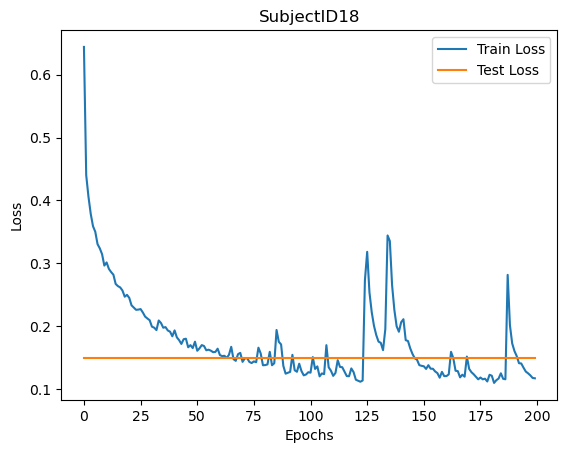

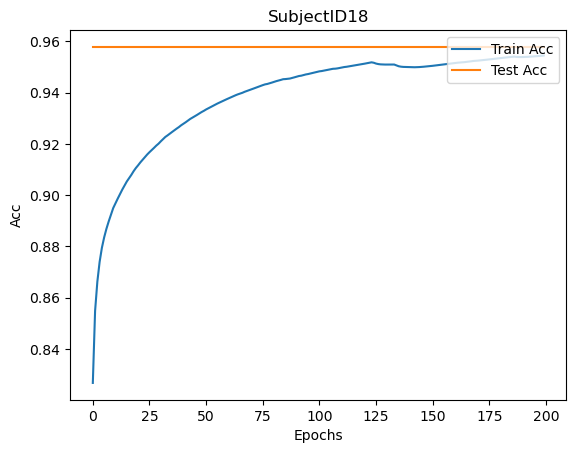


Subject 19
| epoch   0 | 0.2406 s/epoch | train loss 0.6173
| epoch   1 | 0.2395 s/epoch | train loss 0.4251
| epoch   2 | 0.2400 s/epoch | train loss 0.3867
| epoch   3 | 0.2390 s/epoch | train loss 0.3667
| epoch   4 | 0.2418 s/epoch | train loss 0.3482
| epoch   5 | 0.2402 s/epoch | train loss 0.3344
| epoch   6 | 0.2400 s/epoch | train loss 0.3216
| epoch   7 | 0.2386 s/epoch | train loss 0.3175
| epoch   8 | 0.2379 s/epoch | train loss 0.3111
| epoch   9 | 0.2383 s/epoch | train loss 0.3020
| epoch  10 | 0.2371 s/epoch | train loss 0.2862
| epoch  11 | 0.2379 s/epoch | train loss 0.2811
| epoch  12 | 0.2411 s/epoch | train loss 0.2915
| epoch  13 | 0.2373 s/epoch | train loss 0.2699
| epoch  14 | 0.2402 s/epoch | train loss 0.2642
| epoch  15 | 0.2372 s/epoch | train loss 0.2653
| epoch  16 | 0.2392 s/epoch | train loss 0.2598
| epoch  17 | 0.2414 s/epoch | train loss 0.2566
| epoch  18 | 0.2387 s/epoch | train loss 0.2452
| epoch  19 | 0.2396 s/epoch | train loss 0.2370
| epoch 

| epoch 167 | 0.2391 s/epoch | train loss 0.1206
| epoch 168 | 0.2394 s/epoch | train loss 0.1198
| epoch 169 | 0.2384 s/epoch | train loss 0.1215
| epoch 170 | 0.2410 s/epoch | train loss 0.1229
| epoch 171 | 0.2395 s/epoch | train loss 0.1217
| epoch 172 | 0.2409 s/epoch | train loss 0.1196
| epoch 173 | 0.3340 s/epoch | train loss 0.1270
| epoch 174 | 0.3541 s/epoch | train loss 0.1227
| epoch 175 | 0.3093 s/epoch | train loss 0.1150
| epoch 176 | 0.3588 s/epoch | train loss 0.1197
| epoch 177 | 0.4626 s/epoch | train loss 0.1157
| epoch 178 | 0.2657 s/epoch | train loss 0.1109
| epoch 179 | 0.2392 s/epoch | train loss 0.1148
| epoch 180 | 0.2555 s/epoch | train loss 0.1132
| epoch 181 | 0.2412 s/epoch | train loss 0.1176
| epoch 182 | 0.2437 s/epoch | train loss 0.1201
| epoch 183 | 0.2407 s/epoch | train loss 0.1192
| epoch 184 | 0.2395 s/epoch | train loss 0.1140
| epoch 185 | 0.2405 s/epoch | train loss 0.1263
| epoch 186 | 0.2420 s/epoch | train loss 0.1258
| epoch 187 | 0.2395

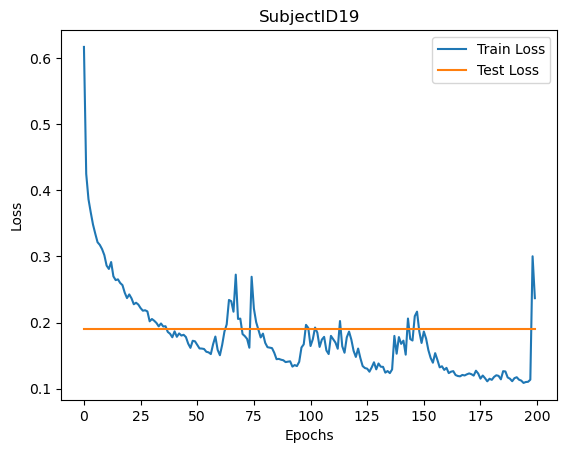

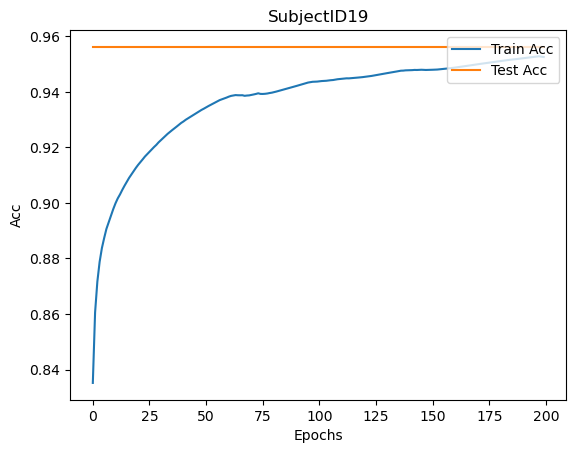


Subject 21
| epoch   0 | 0.2554 s/epoch | train loss 0.6289
| epoch   1 | 0.2678 s/epoch | train loss 0.4467
| epoch   2 | 0.2448 s/epoch | train loss 0.4069
| epoch   3 | 0.2816 s/epoch | train loss 0.3723
| epoch   4 | 0.2415 s/epoch | train loss 0.3498
| epoch   5 | 0.2404 s/epoch | train loss 0.3410
| epoch   6 | 0.2396 s/epoch | train loss 0.3389
| epoch   7 | 0.2387 s/epoch | train loss 0.3194
| epoch   8 | 0.2396 s/epoch | train loss 0.3125
| epoch   9 | 0.2414 s/epoch | train loss 0.2962
| epoch  10 | 0.2408 s/epoch | train loss 0.2908
| epoch  11 | 0.2385 s/epoch | train loss 0.2915
| epoch  12 | 0.2408 s/epoch | train loss 0.2824
| epoch  13 | 0.2414 s/epoch | train loss 0.2791
| epoch  14 | 0.2401 s/epoch | train loss 0.2675
| epoch  15 | 0.2381 s/epoch | train loss 0.2720
| epoch  16 | 0.2398 s/epoch | train loss 0.2664
| epoch  17 | 0.2402 s/epoch | train loss 0.2661
| epoch  18 | 0.2399 s/epoch | train loss 0.2566
| epoch  19 | 0.2382 s/epoch | train loss 0.2531
| epoch 

| epoch 167 | 0.2475 s/epoch | train loss 0.1031
| epoch 168 | 0.2486 s/epoch | train loss 0.1042
| epoch 169 | 0.2540 s/epoch | train loss 0.1096
| epoch 170 | 0.2451 s/epoch | train loss 0.1054
| epoch 171 | 0.2440 s/epoch | train loss 0.1062
| epoch 172 | 0.2439 s/epoch | train loss 0.1050
| epoch 173 | 0.2446 s/epoch | train loss 0.1023
| epoch 174 | 0.2444 s/epoch | train loss 0.1048
| epoch 175 | 0.2452 s/epoch | train loss 0.1010
| epoch 176 | 0.2461 s/epoch | train loss 0.1138
| epoch 177 | 0.2453 s/epoch | train loss 0.1207
| epoch 178 | 0.2446 s/epoch | train loss 0.1049
| epoch 179 | 0.2446 s/epoch | train loss 0.1038
| epoch 180 | 0.2447 s/epoch | train loss 0.1044
| epoch 181 | 0.2389 s/epoch | train loss 0.1030
| epoch 182 | 0.2448 s/epoch | train loss 0.1014
| epoch 183 | 0.2435 s/epoch | train loss 0.1028
| epoch 184 | 0.2460 s/epoch | train loss 0.1038
| epoch 185 | 0.2444 s/epoch | train loss 0.1063
| epoch 186 | 0.2445 s/epoch | train loss 0.1056
| epoch 187 | 0.2449

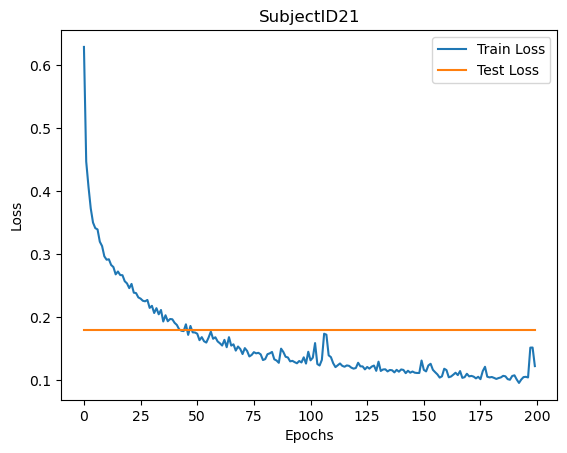

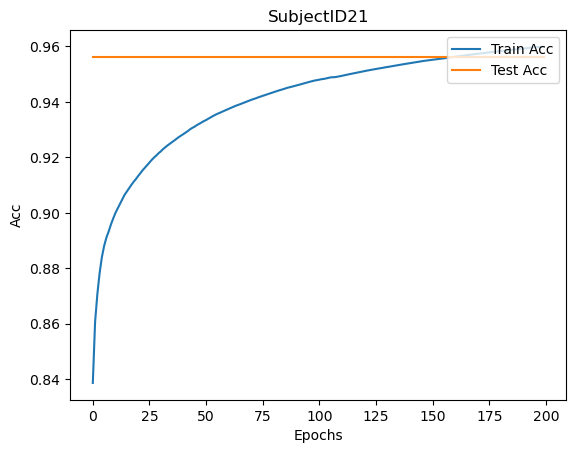


Subject 22
| epoch   0 | 0.2448 s/epoch | train loss 0.6096
| epoch   1 | 0.2476 s/epoch | train loss 0.4267
| epoch   2 | 0.2483 s/epoch | train loss 0.3881
| epoch   3 | 0.2452 s/epoch | train loss 0.3809
| epoch   4 | 0.2496 s/epoch | train loss 0.3560
| epoch   5 | 0.2454 s/epoch | train loss 0.3462
| epoch   6 | 0.2443 s/epoch | train loss 0.3289
| epoch   7 | 0.2464 s/epoch | train loss 0.3128
| epoch   8 | 0.2468 s/epoch | train loss 0.3049
| epoch   9 | 0.2440 s/epoch | train loss 0.2979
| epoch  10 | 0.2454 s/epoch | train loss 0.2857
| epoch  11 | 0.2516 s/epoch | train loss 0.2872
| epoch  12 | 0.2447 s/epoch | train loss 0.2740
| epoch  13 | 0.2447 s/epoch | train loss 0.2772
| epoch  14 | 0.2434 s/epoch | train loss 0.2670
| epoch  15 | 0.2446 s/epoch | train loss 0.2537
| epoch  16 | 0.2443 s/epoch | train loss 0.2605
| epoch  17 | 0.2433 s/epoch | train loss 0.2526
| epoch  18 | 0.2435 s/epoch | train loss 0.2518
| epoch  19 | 0.2409 s/epoch | train loss 0.2472
| epoch 

| epoch 167 | 0.3532 s/epoch | train loss 0.1097
| epoch 168 | 0.3570 s/epoch | train loss 0.1105
| epoch 169 | 0.3541 s/epoch | train loss 0.1013
| epoch 170 | 0.3513 s/epoch | train loss 0.1167
| epoch 171 | 0.3547 s/epoch | train loss 0.1073
| epoch 172 | 0.3560 s/epoch | train loss 0.1035
| epoch 173 | 0.3536 s/epoch | train loss 0.1019
| epoch 174 | 0.3531 s/epoch | train loss 0.1027
| epoch 175 | 0.3518 s/epoch | train loss 0.1014
| epoch 176 | 0.3520 s/epoch | train loss 0.1022
| epoch 177 | 0.3554 s/epoch | train loss 0.1048
| epoch 178 | 0.3551 s/epoch | train loss 0.1071
| epoch 179 | 0.3557 s/epoch | train loss 0.1073
| epoch 180 | 0.3518 s/epoch | train loss 0.1615
| epoch 181 | 0.3531 s/epoch | train loss 0.1290
| epoch 182 | 0.3536 s/epoch | train loss 0.1143
| epoch 183 | 0.3535 s/epoch | train loss 0.1072
| epoch 184 | 0.3520 s/epoch | train loss 0.1027
| epoch 185 | 0.3546 s/epoch | train loss 0.0994
| epoch 186 | 0.3556 s/epoch | train loss 0.1075
| epoch 187 | 0.3528

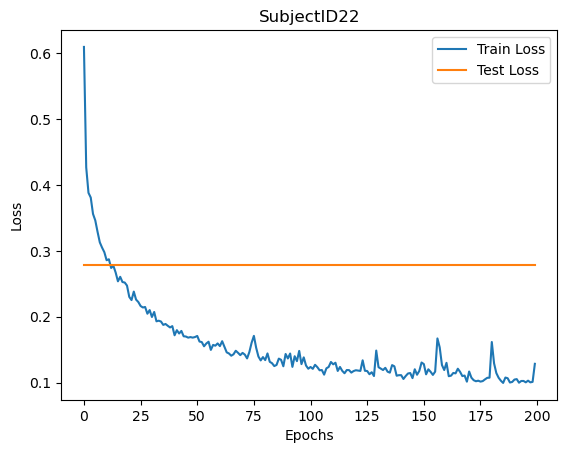

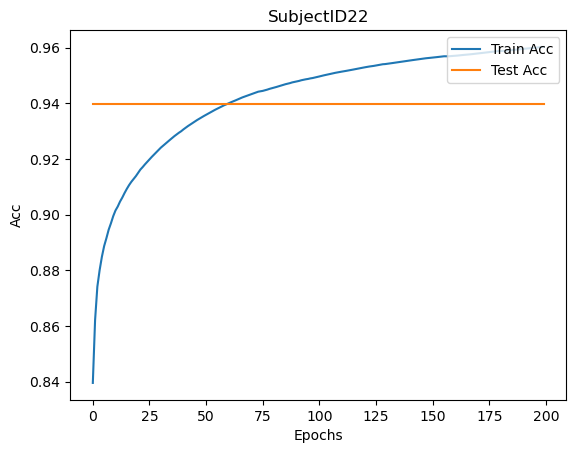


Subject 23
| epoch   0 | 0.4324 s/epoch | train loss 0.5989
| epoch   1 | 0.5693 s/epoch | train loss 0.4358
| epoch   2 | 0.3529 s/epoch | train loss 0.3912
| epoch   3 | 0.3538 s/epoch | train loss 0.3710
| epoch   4 | 0.3523 s/epoch | train loss 0.3522
| epoch   5 | 0.3535 s/epoch | train loss 0.3328
| epoch   6 | 0.3506 s/epoch | train loss 0.3226
| epoch   7 | 0.3510 s/epoch | train loss 0.3138
| epoch   8 | 0.3531 s/epoch | train loss 0.3064
| epoch   9 | 0.3545 s/epoch | train loss 0.2998
| epoch  10 | 0.3480 s/epoch | train loss 0.3012
| epoch  11 | 0.3541 s/epoch | train loss 0.2853
| epoch  12 | 0.3526 s/epoch | train loss 0.2761
| epoch  13 | 0.3534 s/epoch | train loss 0.2740
| epoch  14 | 0.3521 s/epoch | train loss 0.2649
| epoch  15 | 0.3534 s/epoch | train loss 0.2509
| epoch  16 | 0.3545 s/epoch | train loss 0.2507
| epoch  17 | 0.3527 s/epoch | train loss 0.2427
| epoch  18 | 0.3515 s/epoch | train loss 0.2403
| epoch  19 | 0.3532 s/epoch | train loss 0.2362
| epoch 

| epoch 167 | 0.3620 s/epoch | train loss 0.0985
| epoch 168 | 0.3624 s/epoch | train loss 0.0927
| epoch 169 | 0.3581 s/epoch | train loss 0.0994
| epoch 170 | 0.3622 s/epoch | train loss 0.1013
| epoch 171 | 0.3585 s/epoch | train loss 0.1051
| epoch 172 | 0.3651 s/epoch | train loss 0.1171
| epoch 173 | 0.3551 s/epoch | train loss 0.0984
| epoch 174 | 0.3590 s/epoch | train loss 0.0962
| epoch 175 | 0.3654 s/epoch | train loss 0.1024
| epoch 176 | 0.3578 s/epoch | train loss 0.0956
| epoch 177 | 0.3569 s/epoch | train loss 0.0955
| epoch 178 | 0.3575 s/epoch | train loss 0.0976
| epoch 179 | 0.3589 s/epoch | train loss 0.0901
| epoch 180 | 0.3534 s/epoch | train loss 0.0946
| epoch 181 | 0.3596 s/epoch | train loss 0.0943
| epoch 182 | 0.3728 s/epoch | train loss 0.1029
| epoch 183 | 0.3612 s/epoch | train loss 0.0991
| epoch 184 | 0.3599 s/epoch | train loss 0.1033
| epoch 185 | 0.3493 s/epoch | train loss 0.0961
| epoch 186 | 0.3519 s/epoch | train loss 0.0960
| epoch 187 | 0.3577

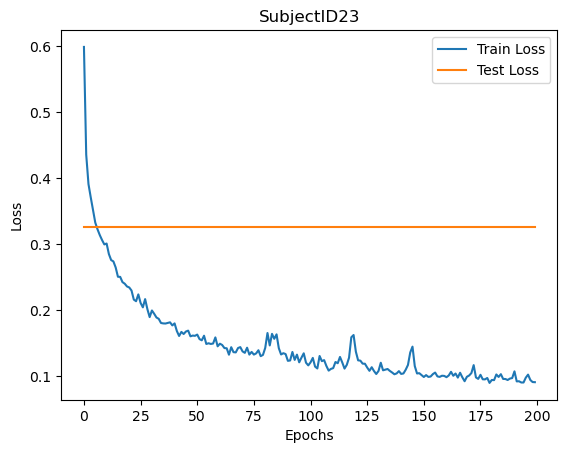

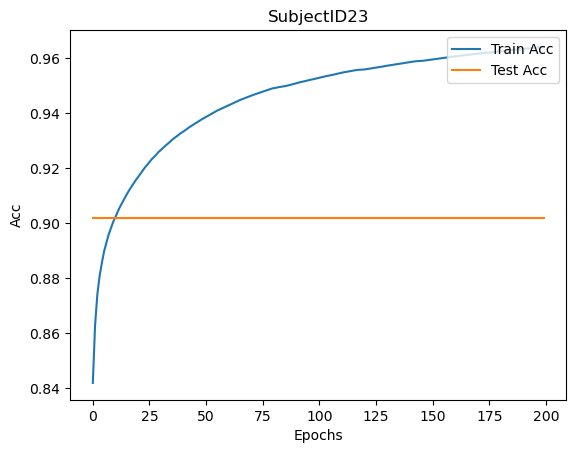

~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~


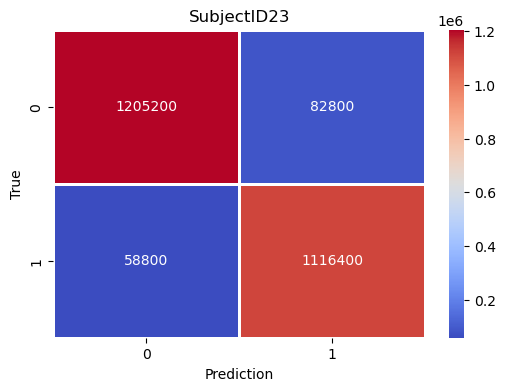

Distillation_teacher(Mobilnet)_Acc: 0.9425138031828516
Distillation_teacher(Mobilnet)_Rec: 0.9499659632402995
Distillation_teacher(Mobilnet)_Pre: 0.9309539693128752
Distillation_teacher(Mobilnet)_F1: 0.9403638814016172


<Figure size 640x480 with 0 Axes>

In [18]:
#Layer 1 Training teacher
teacher_student_train_preds = []
teacher_student_train_gt = []


for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float32'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float32'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float32')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float32')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode

    model_teacher_student = MobileNetV3_Small_KD().to(device) 
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = False
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader,Layer,sub)

#save(config['epochs'], teacher_student_model, teacher_student_optimizer, teacher_student_loss)
show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_teacher(Mobilnet)_Acc:",teacher_Student_eval_table[0])
print("Distillation_teacher(Mobilnet)_Rec:",teacher_Student_eval_table[1])
print("Distillation_teacher(Mobilnet)_Pre:",teacher_Student_eval_table[2])
print("Distillation_teacher(Mobilnet)_F1:",teacher_Student_eval_table[3])


Subject 1
| epoch   0 | 0.1239 s/epoch | train loss 0.6751
| epoch   1 | 0.1224 s/epoch | train loss 0.4051
| epoch   2 | 0.1177 s/epoch | train loss 0.3534
| epoch   3 | 0.1187 s/epoch | train loss 0.3199
| epoch   4 | 0.1150 s/epoch | train loss 0.3030
| epoch   5 | 0.1151 s/epoch | train loss 0.2919
| epoch   6 | 0.1127 s/epoch | train loss 0.2574
| epoch   7 | 0.1171 s/epoch | train loss 0.2452
| epoch   8 | 0.1150 s/epoch | train loss 0.2393
| epoch   9 | 0.1180 s/epoch | train loss 0.2244
| epoch  10 | 0.1136 s/epoch | train loss 0.2213
| epoch  11 | 0.1190 s/epoch | train loss 0.2055
| epoch  12 | 0.1163 s/epoch | train loss 0.1960
| epoch  13 | 0.1147 s/epoch | train loss 0.2025
| epoch  14 | 0.1173 s/epoch | train loss 0.1882
| epoch  15 | 0.1172 s/epoch | train loss 0.1734
| epoch  16 | 0.1168 s/epoch | train loss 0.1768
| epoch  17 | 0.1153 s/epoch | train loss 0.1704
| epoch  18 | 0.1207 s/epoch | train loss 0.1689
| epoch  19 | 0.1189 s/epoch | train loss 0.1582
| epoch  

| epoch 167 | 0.1158 s/epoch | train loss 0.0432
| epoch 168 | 0.1157 s/epoch | train loss 0.0423
| epoch 169 | 0.1185 s/epoch | train loss 0.0448
| epoch 170 | 0.1201 s/epoch | train loss 0.0412
| epoch 171 | 0.1304 s/epoch | train loss 0.0396
| epoch 172 | 0.1235 s/epoch | train loss 0.0415
| epoch 173 | 0.1176 s/epoch | train loss 0.0656
| epoch 174 | 0.1171 s/epoch | train loss 0.0538
| epoch 175 | 0.1125 s/epoch | train loss 0.0414
| epoch 176 | 0.1151 s/epoch | train loss 0.0403
| epoch 177 | 0.1151 s/epoch | train loss 0.0402
| epoch 178 | 0.1116 s/epoch | train loss 0.0396
| epoch 179 | 0.1183 s/epoch | train loss 0.0387
| epoch 180 | 0.1162 s/epoch | train loss 0.0389
| epoch 181 | 0.1187 s/epoch | train loss 0.0675
| epoch 182 | 0.1187 s/epoch | train loss 0.0609
| epoch 183 | 0.1171 s/epoch | train loss 0.0440
| epoch 184 | 0.1186 s/epoch | train loss 0.0388
| epoch 185 | 0.1172 s/epoch | train loss 0.0379
| epoch 186 | 0.1154 s/epoch | train loss 0.0376
| epoch 187 | 0.1157

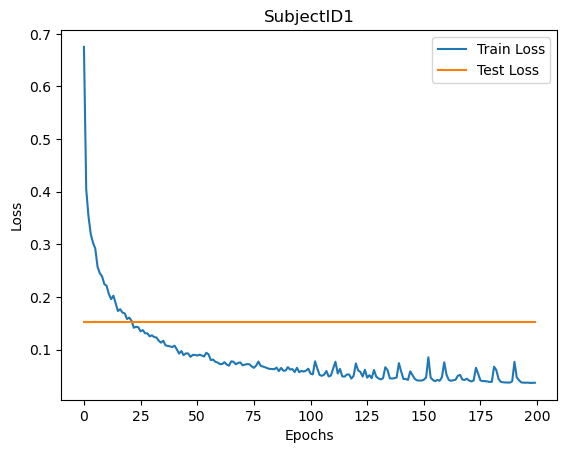

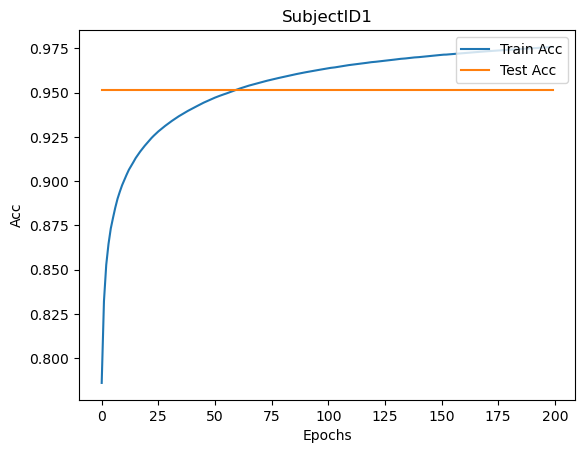


Subject 2
| epoch   0 | 0.1138 s/epoch | train loss 0.6389
| epoch   1 | 0.1144 s/epoch | train loss 0.4083
| epoch   2 | 0.1158 s/epoch | train loss 0.3664
| epoch   3 | 0.1152 s/epoch | train loss 0.3534
| epoch   4 | 0.1151 s/epoch | train loss 0.3225
| epoch   5 | 0.1208 s/epoch | train loss 0.3074
| epoch   6 | 0.1169 s/epoch | train loss 0.2832
| epoch   7 | 0.1172 s/epoch | train loss 0.2738
| epoch   8 | 0.1169 s/epoch | train loss 0.2524
| epoch   9 | 0.1151 s/epoch | train loss 0.2459
| epoch  10 | 0.1193 s/epoch | train loss 0.2344
| epoch  11 | 0.1170 s/epoch | train loss 0.2175
| epoch  12 | 0.1167 s/epoch | train loss 0.2062
| epoch  13 | 0.1225 s/epoch | train loss 0.2028
| epoch  14 | 0.1188 s/epoch | train loss 0.2023
| epoch  15 | 0.1192 s/epoch | train loss 0.1926
| epoch  16 | 0.1194 s/epoch | train loss 0.1824
| epoch  17 | 0.1173 s/epoch | train loss 0.1761
| epoch  18 | 0.1160 s/epoch | train loss 0.1728
| epoch  19 | 0.1188 s/epoch | train loss 0.1633
| epoch  

| epoch 167 | 0.1137 s/epoch | train loss 0.0409
| epoch 168 | 0.1120 s/epoch | train loss 0.0395
| epoch 169 | 0.1131 s/epoch | train loss 0.0384
| epoch 170 | 0.1240 s/epoch | train loss 0.0389
| epoch 171 | 0.1147 s/epoch | train loss 0.0382
| epoch 172 | 0.1146 s/epoch | train loss 0.0393
| epoch 173 | 0.1230 s/epoch | train loss 0.0518
| epoch 174 | 0.1145 s/epoch | train loss 0.0655
| epoch 175 | 0.1107 s/epoch | train loss 0.0427
| epoch 176 | 0.1236 s/epoch | train loss 0.0409
| epoch 177 | 0.1130 s/epoch | train loss 0.0386
| epoch 178 | 0.1132 s/epoch | train loss 0.0384
| epoch 179 | 0.1210 s/epoch | train loss 0.0451
| epoch 180 | 0.1142 s/epoch | train loss 0.0793
| epoch 181 | 0.1140 s/epoch | train loss 0.0493
| epoch 182 | 0.1207 s/epoch | train loss 0.0420
| epoch 183 | 0.1131 s/epoch | train loss 0.0388
| epoch 184 | 0.1235 s/epoch | train loss 0.0371
| epoch 185 | 0.1167 s/epoch | train loss 0.0372
| epoch 186 | 0.1140 s/epoch | train loss 0.0367
| epoch 187 | 0.1218

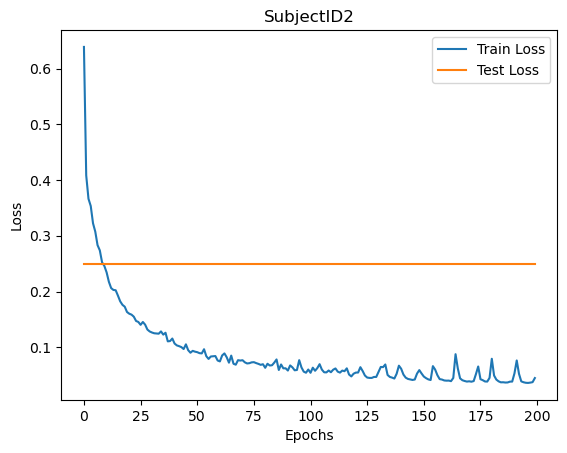

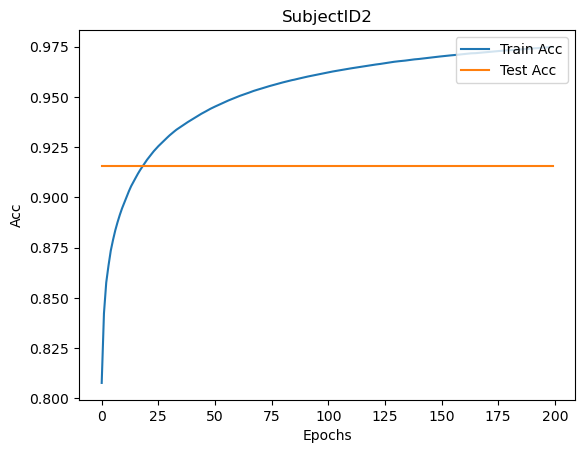


Subject 3
| epoch   0 | 0.1109 s/epoch | train loss 0.6580
| epoch   1 | 0.1124 s/epoch | train loss 0.4021
| epoch   2 | 0.1123 s/epoch | train loss 0.3584
| epoch   3 | 0.1228 s/epoch | train loss 0.3264
| epoch   4 | 0.1126 s/epoch | train loss 0.3192
| epoch   5 | 0.1134 s/epoch | train loss 0.3023
| epoch   6 | 0.1254 s/epoch | train loss 0.2908
| epoch   7 | 0.1227 s/epoch | train loss 0.2814
| epoch   8 | 0.1141 s/epoch | train loss 0.2638
| epoch   9 | 0.1124 s/epoch | train loss 0.2577
| epoch  10 | 0.1259 s/epoch | train loss 0.2541
| epoch  11 | 0.1135 s/epoch | train loss 0.2379
| epoch  12 | 0.1131 s/epoch | train loss 0.2324
| epoch  13 | 0.1238 s/epoch | train loss 0.2247
| epoch  14 | 0.1166 s/epoch | train loss 0.2215
| epoch  15 | 0.1137 s/epoch | train loss 0.2082
| epoch  16 | 0.1204 s/epoch | train loss 0.2026
| epoch  17 | 0.1124 s/epoch | train loss 0.1942
| epoch  18 | 0.1136 s/epoch | train loss 0.1907
| epoch  19 | 0.1186 s/epoch | train loss 0.1886
| epoch  

| epoch 167 | 0.1245 s/epoch | train loss 0.0487
| epoch 168 | 0.1123 s/epoch | train loss 0.0897
| epoch 169 | 0.1150 s/epoch | train loss 0.0548
| epoch 170 | 0.1227 s/epoch | train loss 0.0473
| epoch 171 | 0.1128 s/epoch | train loss 0.0406
| epoch 172 | 0.1132 s/epoch | train loss 0.0383
| epoch 173 | 0.1122 s/epoch | train loss 0.0383
| epoch 174 | 0.1221 s/epoch | train loss 0.0382
| epoch 175 | 0.1137 s/epoch | train loss 0.0378
| epoch 176 | 0.1136 s/epoch | train loss 0.0384
| epoch 177 | 0.1224 s/epoch | train loss 0.0391
| epoch 178 | 0.1138 s/epoch | train loss 0.0471
| epoch 179 | 0.1114 s/epoch | train loss 0.0761
| epoch 180 | 0.1254 s/epoch | train loss 0.0581
| epoch 181 | 0.1131 s/epoch | train loss 0.0421
| epoch 182 | 0.1126 s/epoch | train loss 0.0387
| epoch 183 | 0.1234 s/epoch | train loss 0.0394
| epoch 184 | 0.1138 s/epoch | train loss 0.0376
| epoch 185 | 0.1155 s/epoch | train loss 0.0374
| epoch 186 | 0.1217 s/epoch | train loss 0.0373
| epoch 187 | 0.1135

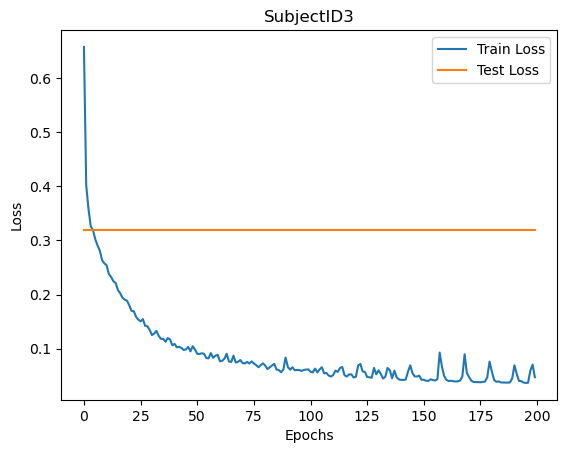

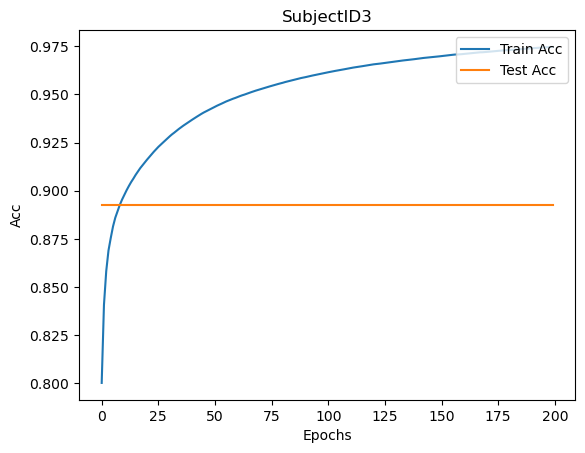


Subject 4
| epoch   0 | 0.1228 s/epoch | train loss 0.7023
| epoch   1 | 0.1141 s/epoch | train loss 0.4341
| epoch   2 | 0.1141 s/epoch | train loss 0.3780
| epoch   3 | 0.1246 s/epoch | train loss 0.3587
| epoch   4 | 0.1153 s/epoch | train loss 0.3315
| epoch   5 | 0.1130 s/epoch | train loss 0.3242
| epoch   6 | 0.1234 s/epoch | train loss 0.3056
| epoch   7 | 0.1180 s/epoch | train loss 0.2978
| epoch   8 | 0.1135 s/epoch | train loss 0.2763
| epoch   9 | 0.1226 s/epoch | train loss 0.2788
| epoch  10 | 0.1168 s/epoch | train loss 0.2656
| epoch  11 | 0.1109 s/epoch | train loss 0.2674
| epoch  12 | 0.1243 s/epoch | train loss 0.2552
| epoch  13 | 0.1122 s/epoch | train loss 0.2419
| epoch  14 | 0.1136 s/epoch | train loss 0.2355
| epoch  15 | 0.1248 s/epoch | train loss 0.2204
| epoch  16 | 0.1136 s/epoch | train loss 0.2243
| epoch  17 | 0.1136 s/epoch | train loss 0.2130
| epoch  18 | 0.1226 s/epoch | train loss 0.2075
| epoch  19 | 0.1146 s/epoch | train loss 0.2032
| epoch  

| epoch 167 | 0.1129 s/epoch | train loss 0.0386
| epoch 168 | 0.1157 s/epoch | train loss 0.0383
| epoch 169 | 0.1240 s/epoch | train loss 0.0380
| epoch 170 | 0.1135 s/epoch | train loss 0.0383
| epoch 171 | 0.1148 s/epoch | train loss 0.0384
| epoch 172 | 0.1250 s/epoch | train loss 0.0450
| epoch 173 | 0.1156 s/epoch | train loss 0.0682
| epoch 174 | 0.1251 s/epoch | train loss 0.0526
| epoch 175 | 0.1157 s/epoch | train loss 0.0420
| epoch 176 | 0.1151 s/epoch | train loss 0.0396
| epoch 177 | 0.1257 s/epoch | train loss 0.0391
| epoch 178 | 0.1115 s/epoch | train loss 0.0418
| epoch 179 | 0.1173 s/epoch | train loss 0.0523
| epoch 180 | 0.1222 s/epoch | train loss 0.0429
| epoch 181 | 0.1151 s/epoch | train loss 0.0400
| epoch 182 | 0.1135 s/epoch | train loss 0.0388
| epoch 183 | 0.1267 s/epoch | train loss 0.0386
| epoch 184 | 0.1156 s/epoch | train loss 0.0384
| epoch 185 | 0.1238 s/epoch | train loss 0.0387
| epoch 186 | 0.1135 s/epoch | train loss 0.0392
| epoch 187 | 0.1102

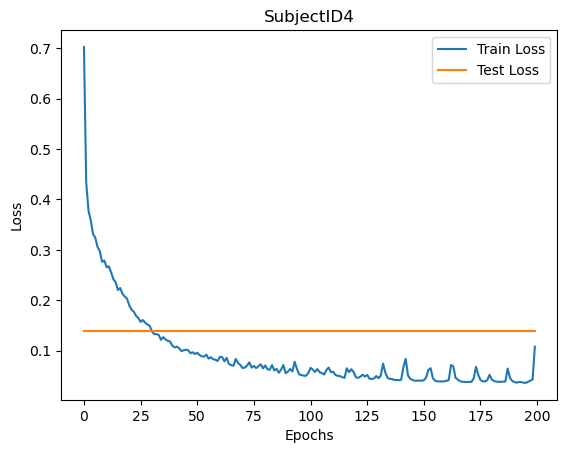

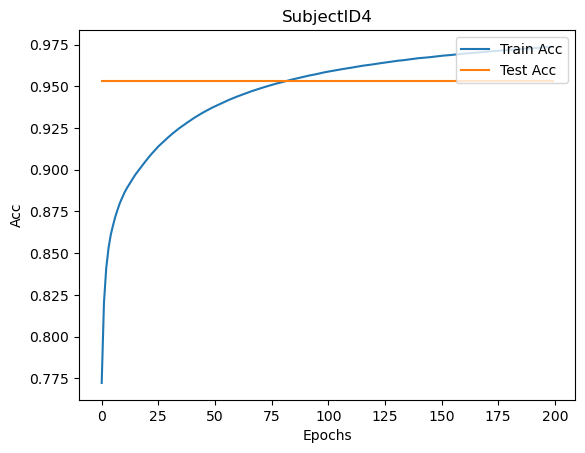


Subject 5
| epoch   0 | 0.1180 s/epoch | train loss 0.6810
| epoch   1 | 0.1115 s/epoch | train loss 0.4200
| epoch   2 | 0.1282 s/epoch | train loss 0.3725
| epoch   3 | 0.1127 s/epoch | train loss 0.3405
| epoch   4 | 0.1154 s/epoch | train loss 0.3332
| epoch   5 | 0.1240 s/epoch | train loss 0.3082
| epoch   6 | 0.1154 s/epoch | train loss 0.2905
| epoch   7 | 0.1157 s/epoch | train loss 0.2856
| epoch   8 | 0.1253 s/epoch | train loss 0.2688
| epoch   9 | 0.1173 s/epoch | train loss 0.2606
| epoch  10 | 0.1234 s/epoch | train loss 0.2472
| epoch  11 | 0.1161 s/epoch | train loss 0.2340
| epoch  12 | 0.1152 s/epoch | train loss 0.2345
| epoch  13 | 0.1217 s/epoch | train loss 0.2279
| epoch  14 | 0.1139 s/epoch | train loss 0.2122
| epoch  15 | 0.1145 s/epoch | train loss 0.2202
| epoch  16 | 0.1263 s/epoch | train loss 0.2037
| epoch  17 | 0.1160 s/epoch | train loss 0.1949
| epoch  18 | 0.1140 s/epoch | train loss 0.1843
| epoch  19 | 0.1240 s/epoch | train loss 0.1820
| epoch  

| epoch 167 | 0.1255 s/epoch | train loss 0.0563
| epoch 168 | 0.1156 s/epoch | train loss 0.0451
| epoch 169 | 0.1255 s/epoch | train loss 0.0471
| epoch 170 | 0.1169 s/epoch | train loss 0.0433
| epoch 171 | 0.1261 s/epoch | train loss 0.0444
| epoch 172 | 0.1147 s/epoch | train loss 0.0594
| epoch 173 | 0.1180 s/epoch | train loss 0.0461
| epoch 174 | 0.1285 s/epoch | train loss 0.0421
| epoch 175 | 0.1147 s/epoch | train loss 0.0391
| epoch 176 | 0.1287 s/epoch | train loss 0.0383
| epoch 177 | 0.1128 s/epoch | train loss 0.0376
| epoch 178 | 0.1152 s/epoch | train loss 0.0377
| epoch 179 | 0.1285 s/epoch | train loss 0.0423
| epoch 180 | 0.1138 s/epoch | train loss 0.0677
| epoch 181 | 0.1256 s/epoch | train loss 0.0446
| epoch 182 | 0.1145 s/epoch | train loss 0.0391
| epoch 183 | 0.1194 s/epoch | train loss 0.0376
| epoch 184 | 0.1259 s/epoch | train loss 0.0371
| epoch 185 | 0.1160 s/epoch | train loss 0.0378
| epoch 186 | 0.1140 s/epoch | train loss 0.0401
| epoch 187 | 0.1266

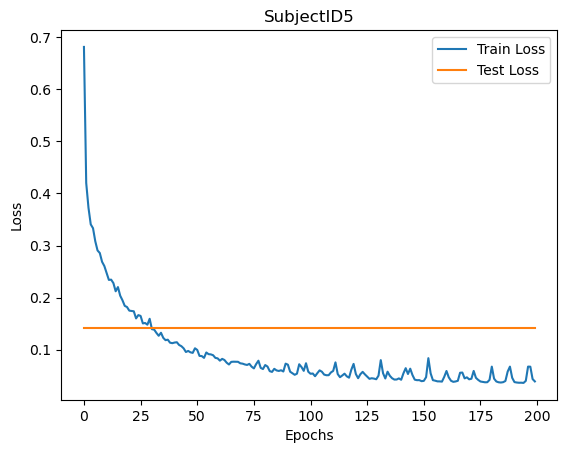

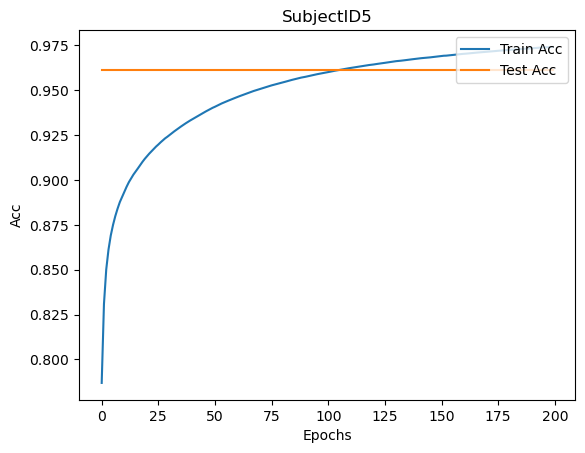


Subject 7
| epoch   0 | 0.1178 s/epoch | train loss 0.6733
| epoch   1 | 0.1154 s/epoch | train loss 0.4301
| epoch   2 | 0.1174 s/epoch | train loss 0.3807
| epoch   3 | 0.1134 s/epoch | train loss 0.3487
| epoch   4 | 0.1184 s/epoch | train loss 0.3341
| epoch   5 | 0.1115 s/epoch | train loss 0.3158
| epoch   6 | 0.1156 s/epoch | train loss 0.3006
| epoch   7 | 0.1163 s/epoch | train loss 0.2897
| epoch   8 | 0.1172 s/epoch | train loss 0.2754
| epoch   9 | 0.1159 s/epoch | train loss 0.2727
| epoch  10 | 0.1156 s/epoch | train loss 0.2555
| epoch  11 | 0.1129 s/epoch | train loss 0.2539
| epoch  12 | 0.1199 s/epoch | train loss 0.2397
| epoch  13 | 0.1172 s/epoch | train loss 0.2246
| epoch  14 | 0.1177 s/epoch | train loss 0.2196
| epoch  15 | 0.1170 s/epoch | train loss 0.2074
| epoch  16 | 0.1202 s/epoch | train loss 0.1946
| epoch  17 | 0.1197 s/epoch | train loss 0.1821
| epoch  18 | 0.1196 s/epoch | train loss 0.1780
| epoch  19 | 0.1150 s/epoch | train loss 0.1654
| epoch  

| epoch 167 | 0.1165 s/epoch | train loss 0.0710
| epoch 168 | 0.1220 s/epoch | train loss 0.0479
| epoch 169 | 0.1185 s/epoch | train loss 0.0406
| epoch 170 | 0.1233 s/epoch | train loss 0.0387
| epoch 171 | 0.1213 s/epoch | train loss 0.0380
| epoch 172 | 0.1170 s/epoch | train loss 0.0370
| epoch 173 | 0.1153 s/epoch | train loss 0.0375
| epoch 174 | 0.1183 s/epoch | train loss 0.0394
| epoch 175 | 0.1168 s/epoch | train loss 0.0598
| epoch 176 | 0.1149 s/epoch | train loss 0.0631
| epoch 177 | 0.1150 s/epoch | train loss 0.0421
| epoch 178 | 0.1170 s/epoch | train loss 0.0385
| epoch 179 | 0.1156 s/epoch | train loss 0.0370
| epoch 180 | 0.1131 s/epoch | train loss 0.0368
| epoch 181 | 0.1185 s/epoch | train loss 0.0369
| epoch 182 | 0.1171 s/epoch | train loss 0.0369
| epoch 183 | 0.1235 s/epoch | train loss 0.0364
| epoch 184 | 0.1216 s/epoch | train loss 0.0368
| epoch 185 | 0.1213 s/epoch | train loss 0.0379
| epoch 186 | 0.1183 s/epoch | train loss 0.0770
| epoch 187 | 0.1255

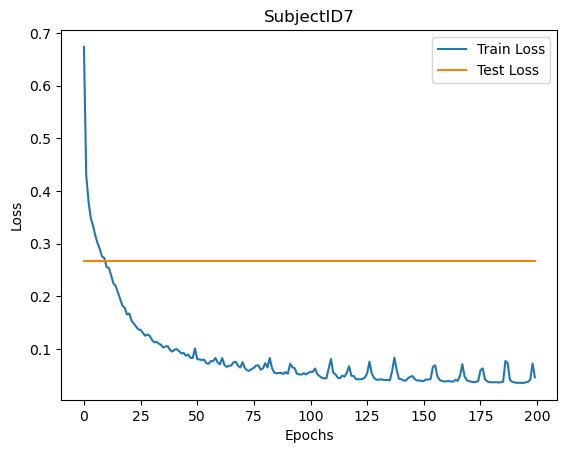

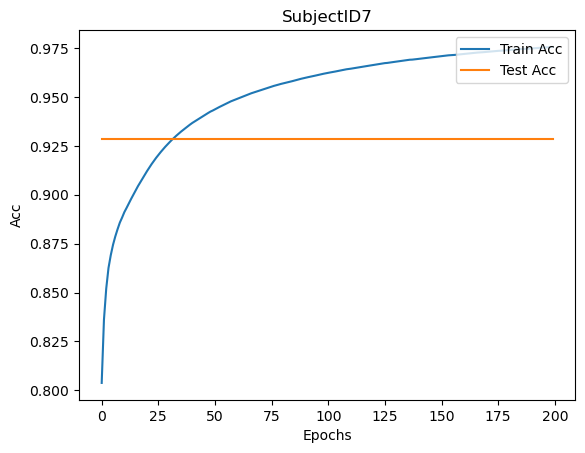


Subject 8
| epoch   0 | 0.1173 s/epoch | train loss 0.6429
| epoch   1 | 0.1176 s/epoch | train loss 0.4131
| epoch   2 | 0.1151 s/epoch | train loss 0.3625
| epoch   3 | 0.1171 s/epoch | train loss 0.3431
| epoch   4 | 0.1134 s/epoch | train loss 0.3295
| epoch   5 | 0.1171 s/epoch | train loss 0.3086
| epoch   6 | 0.1170 s/epoch | train loss 0.2874
| epoch   7 | 0.1197 s/epoch | train loss 0.2734
| epoch   8 | 0.1159 s/epoch | train loss 0.2637
| epoch   9 | 0.1177 s/epoch | train loss 0.2581
| epoch  10 | 0.1173 s/epoch | train loss 0.2420
| epoch  11 | 0.1163 s/epoch | train loss 0.2322
| epoch  12 | 0.1160 s/epoch | train loss 0.2193
| epoch  13 | 0.1180 s/epoch | train loss 0.2192
| epoch  14 | 0.1187 s/epoch | train loss 0.2121
| epoch  15 | 0.1172 s/epoch | train loss 0.1981
| epoch  16 | 0.1141 s/epoch | train loss 0.1840
| epoch  17 | 0.1156 s/epoch | train loss 0.1753
| epoch  18 | 0.1195 s/epoch | train loss 0.1732
| epoch  19 | 0.1205 s/epoch | train loss 0.1675
| epoch  

| epoch 167 | 0.1252 s/epoch | train loss 0.0399
| epoch 168 | 0.1173 s/epoch | train loss 0.0384
| epoch 169 | 0.1157 s/epoch | train loss 0.0380
| epoch 170 | 0.1166 s/epoch | train loss 0.0383
| epoch 171 | 0.1167 s/epoch | train loss 0.0376
| epoch 172 | 0.1165 s/epoch | train loss 0.0500
| epoch 173 | 0.1192 s/epoch | train loss 0.0827
| epoch 174 | 0.1209 s/epoch | train loss 0.0538
| epoch 175 | 0.1160 s/epoch | train loss 0.0409
| epoch 176 | 0.1166 s/epoch | train loss 0.0388
| epoch 177 | 0.1176 s/epoch | train loss 0.0377
| epoch 178 | 0.1169 s/epoch | train loss 0.0369
| epoch 179 | 0.1194 s/epoch | train loss 0.0406
| epoch 180 | 0.1187 s/epoch | train loss 0.0379
| epoch 181 | 0.1189 s/epoch | train loss 0.0370
| epoch 182 | 0.1181 s/epoch | train loss 0.0369
| epoch 183 | 0.1214 s/epoch | train loss 0.0361
| epoch 184 | 0.1170 s/epoch | train loss 0.0377
| epoch 185 | 0.1186 s/epoch | train loss 0.0363
| epoch 186 | 0.1154 s/epoch | train loss 0.0925
| epoch 187 | 0.1179

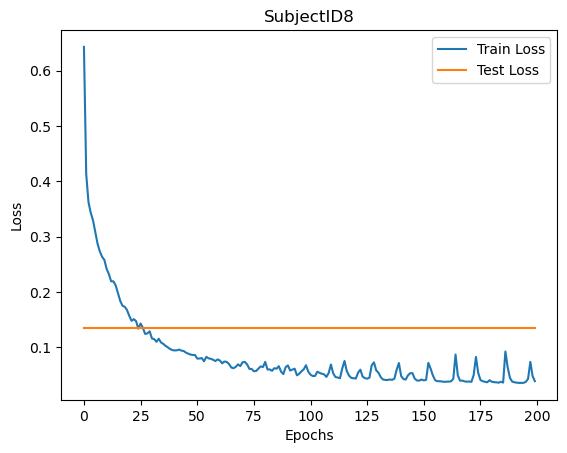

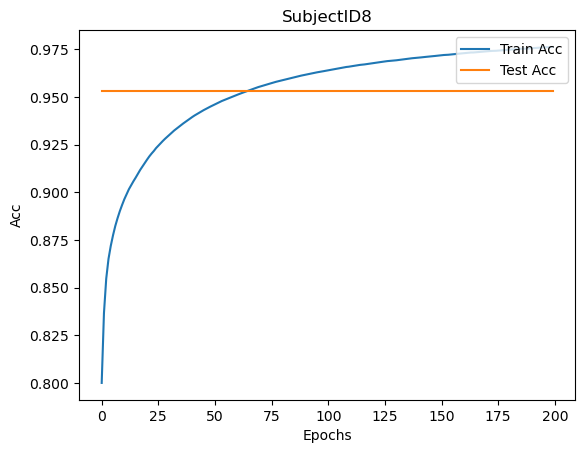


Subject 9
| epoch   0 | 0.1168 s/epoch | train loss 0.6837
| epoch   1 | 0.1173 s/epoch | train loss 0.4491
| epoch   2 | 0.1155 s/epoch | train loss 0.3728
| epoch   3 | 0.1205 s/epoch | train loss 0.3395
| epoch   4 | 0.1192 s/epoch | train loss 0.3411
| epoch   5 | 0.1191 s/epoch | train loss 0.3076
| epoch   6 | 0.1184 s/epoch | train loss 0.2924
| epoch   7 | 0.1176 s/epoch | train loss 0.2818
| epoch   8 | 0.1187 s/epoch | train loss 0.2661
| epoch   9 | 0.1191 s/epoch | train loss 0.2710
| epoch  10 | 0.1199 s/epoch | train loss 0.2630
| epoch  11 | 0.1177 s/epoch | train loss 0.2514
| epoch  12 | 0.1143 s/epoch | train loss 0.2438
| epoch  13 | 0.1181 s/epoch | train loss 0.2315
| epoch  14 | 0.1198 s/epoch | train loss 0.2286
| epoch  15 | 0.1169 s/epoch | train loss 0.2237
| epoch  16 | 0.1166 s/epoch | train loss 0.2161
| epoch  17 | 0.1153 s/epoch | train loss 0.2109
| epoch  18 | 0.1162 s/epoch | train loss 0.2040
| epoch  19 | 0.1162 s/epoch | train loss 0.1986
| epoch  

| epoch 167 | 0.1150 s/epoch | train loss 0.0400
| epoch 168 | 0.1145 s/epoch | train loss 0.0399
| epoch 169 | 0.1153 s/epoch | train loss 0.0412
| epoch 170 | 0.1164 s/epoch | train loss 0.0414
| epoch 171 | 0.1151 s/epoch | train loss 0.0728
| epoch 172 | 0.1142 s/epoch | train loss 0.0669
| epoch 173 | 0.1153 s/epoch | train loss 0.0420
| epoch 174 | 0.1154 s/epoch | train loss 0.0400
| epoch 175 | 0.1142 s/epoch | train loss 0.0388
| epoch 176 | 0.1162 s/epoch | train loss 0.0383
| epoch 177 | 0.1130 s/epoch | train loss 0.0379
| epoch 178 | 0.1162 s/epoch | train loss 0.0427
| epoch 179 | 0.1140 s/epoch | train loss 0.0685
| epoch 180 | 0.1186 s/epoch | train loss 0.0479
| epoch 181 | 0.1151 s/epoch | train loss 0.0399
| epoch 182 | 0.1158 s/epoch | train loss 0.0443
| epoch 183 | 0.1131 s/epoch | train loss 0.0390
| epoch 184 | 0.1159 s/epoch | train loss 0.0378
| epoch 185 | 0.1161 s/epoch | train loss 0.0403
| epoch 186 | 0.1173 s/epoch | train loss 0.0429
| epoch 187 | 0.1155

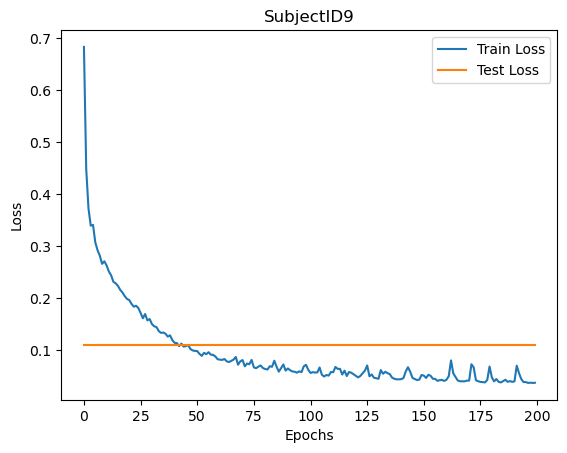

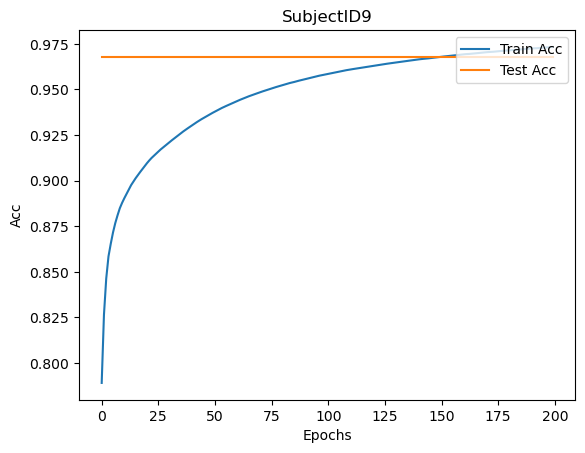


Subject 10
| epoch   0 | 0.1172 s/epoch | train loss 0.6357
| epoch   1 | 0.1160 s/epoch | train loss 0.3953
| epoch   2 | 0.1127 s/epoch | train loss 0.3637
| epoch   3 | 0.1159 s/epoch | train loss 0.3491
| epoch   4 | 0.1126 s/epoch | train loss 0.3272
| epoch   5 | 0.1125 s/epoch | train loss 0.3201
| epoch   6 | 0.1137 s/epoch | train loss 0.2949
| epoch   7 | 0.1113 s/epoch | train loss 0.2748
| epoch   8 | 0.1167 s/epoch | train loss 0.2756
| epoch   9 | 0.1140 s/epoch | train loss 0.2593
| epoch  10 | 0.1144 s/epoch | train loss 0.2438
| epoch  11 | 0.1139 s/epoch | train loss 0.2446
| epoch  12 | 0.1152 s/epoch | train loss 0.2409
| epoch  13 | 0.1095 s/epoch | train loss 0.2333
| epoch  14 | 0.1126 s/epoch | train loss 0.2303
| epoch  15 | 0.1159 s/epoch | train loss 0.2105
| epoch  16 | 0.1126 s/epoch | train loss 0.2040
| epoch  17 | 0.1146 s/epoch | train loss 0.2096
| epoch  18 | 0.1118 s/epoch | train loss 0.2005
| epoch  19 | 0.1113 s/epoch | train loss 0.1833
| epoch 

| epoch 167 | 0.1139 s/epoch | train loss 0.0394
| epoch 168 | 0.1110 s/epoch | train loss 0.0395
| epoch 169 | 0.1134 s/epoch | train loss 0.0398
| epoch 170 | 0.1178 s/epoch | train loss 0.0492
| epoch 171 | 0.1130 s/epoch | train loss 0.0611
| epoch 172 | 0.1144 s/epoch | train loss 0.0463
| epoch 173 | 0.1117 s/epoch | train loss 0.0407
| epoch 174 | 0.1155 s/epoch | train loss 0.0392
| epoch 175 | 0.1151 s/epoch | train loss 0.0393
| epoch 176 | 0.1175 s/epoch | train loss 0.0410
| epoch 177 | 0.1151 s/epoch | train loss 0.0412
| epoch 178 | 0.1156 s/epoch | train loss 0.0410
| epoch 179 | 0.1144 s/epoch | train loss 0.0640
| epoch 180 | 0.1145 s/epoch | train loss 0.0571
| epoch 181 | 0.1162 s/epoch | train loss 0.0415
| epoch 182 | 0.1149 s/epoch | train loss 0.0388
| epoch 183 | 0.1143 s/epoch | train loss 0.0388
| epoch 184 | 0.1131 s/epoch | train loss 0.0429
| epoch 185 | 0.1143 s/epoch | train loss 0.0382
| epoch 186 | 0.1176 s/epoch | train loss 0.0379
| epoch 187 | 0.1123

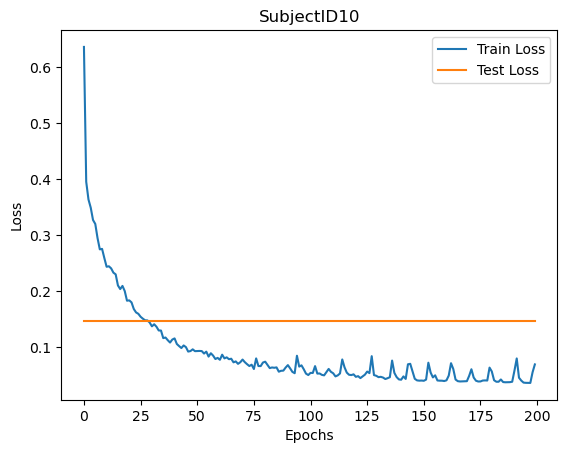

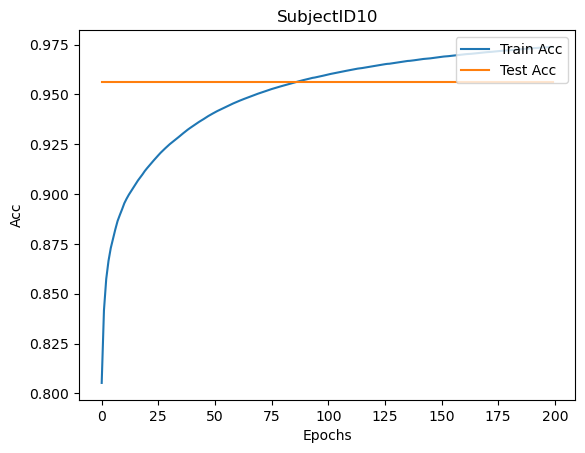


Subject 11
| epoch   0 | 0.1151 s/epoch | train loss 0.6733
| epoch   1 | 0.1121 s/epoch | train loss 0.3914
| epoch   2 | 0.1142 s/epoch | train loss 0.3390
| epoch   3 | 0.1147 s/epoch | train loss 0.3247
| epoch   4 | 0.1150 s/epoch | train loss 0.2905
| epoch   5 | 0.1140 s/epoch | train loss 0.2832
| epoch   6 | 0.1148 s/epoch | train loss 0.2600
| epoch   7 | 0.1147 s/epoch | train loss 0.2554
| epoch   8 | 0.1140 s/epoch | train loss 0.2467
| epoch   9 | 0.1152 s/epoch | train loss 0.2300
| epoch  10 | 0.1113 s/epoch | train loss 0.2254
| epoch  11 | 0.1172 s/epoch | train loss 0.2077
| epoch  12 | 0.1153 s/epoch | train loss 0.2123
| epoch  13 | 0.1139 s/epoch | train loss 0.1988
| epoch  14 | 0.1120 s/epoch | train loss 0.1915
| epoch  15 | 0.1143 s/epoch | train loss 0.1849
| epoch  16 | 0.1117 s/epoch | train loss 0.1800
| epoch  17 | 0.1141 s/epoch | train loss 0.1713
| epoch  18 | 0.1120 s/epoch | train loss 0.1585
| epoch  19 | 0.1156 s/epoch | train loss 0.1599
| epoch 

| epoch 167 | 0.1390 s/epoch | train loss 0.0390
| epoch 168 | 0.1406 s/epoch | train loss 0.0384
| epoch 169 | 0.1507 s/epoch | train loss 0.0382
| epoch 170 | 0.1435 s/epoch | train loss 0.0384
| epoch 171 | 0.1518 s/epoch | train loss 0.0382
| epoch 172 | 0.1430 s/epoch | train loss 0.0424
| epoch 173 | 0.1424 s/epoch | train loss 0.0746
| epoch 174 | 0.1514 s/epoch | train loss 0.0583
| epoch 175 | 0.1439 s/epoch | train loss 0.0450
| epoch 176 | 0.1546 s/epoch | train loss 0.0396
| epoch 177 | 0.1460 s/epoch | train loss 0.0377
| epoch 178 | 0.1549 s/epoch | train loss 0.0376
| epoch 179 | 0.1397 s/epoch | train loss 0.0381
| epoch 180 | 0.1395 s/epoch | train loss 0.0380
| epoch 181 | 0.1420 s/epoch | train loss 0.0380
| epoch 182 | 0.1511 s/epoch | train loss 0.0569
| epoch 183 | 0.1411 s/epoch | train loss 0.0709
| epoch 184 | 0.1532 s/epoch | train loss 0.0706
| epoch 185 | 0.1441 s/epoch | train loss 0.0432
| epoch 186 | 0.1515 s/epoch | train loss 0.0381
| epoch 187 | 0.1417

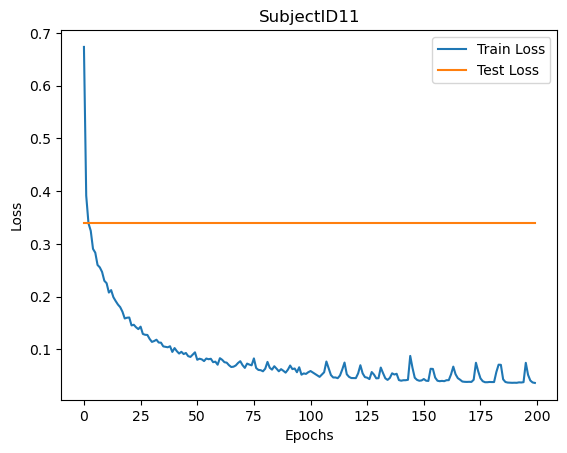

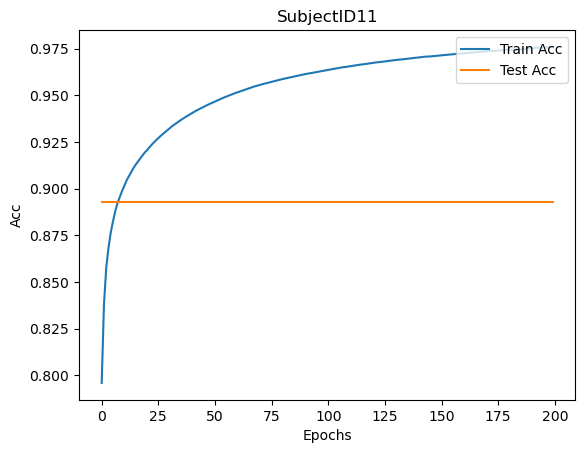


Subject 12
| epoch   0 | 0.1633 s/epoch | train loss 0.6778
| epoch   1 | 0.1482 s/epoch | train loss 0.4212
| epoch   2 | 0.1503 s/epoch | train loss 0.3776
| epoch   3 | 0.1532 s/epoch | train loss 0.3536
| epoch   4 | 0.1411 s/epoch | train loss 0.3307
| epoch   5 | 0.1421 s/epoch | train loss 0.3021
| epoch   6 | 0.1521 s/epoch | train loss 0.2913
| epoch   7 | 0.1370 s/epoch | train loss 0.2811
| epoch   8 | 0.1630 s/epoch | train loss 0.2690
| epoch   9 | 0.1599 s/epoch | train loss 0.2649
| epoch  10 | 0.1605 s/epoch | train loss 0.2672
| epoch  11 | 0.1600 s/epoch | train loss 0.2388
| epoch  12 | 0.1480 s/epoch | train loss 0.2367
| epoch  13 | 0.1547 s/epoch | train loss 0.2228
| epoch  14 | 0.1567 s/epoch | train loss 0.2181
| epoch  15 | 0.1436 s/epoch | train loss 0.2014
| epoch  16 | 0.1558 s/epoch | train loss 0.1990
| epoch  17 | 0.1567 s/epoch | train loss 0.1872
| epoch  18 | 0.1562 s/epoch | train loss 0.1871
| epoch  19 | 0.1461 s/epoch | train loss 0.1761
| epoch 

| epoch 167 | 0.1381 s/epoch | train loss 0.0411
| epoch 168 | 0.1220 s/epoch | train loss 0.0415
| epoch 169 | 0.1333 s/epoch | train loss 0.0432
| epoch 170 | 0.1355 s/epoch | train loss 0.0409
| epoch 171 | 0.1374 s/epoch | train loss 0.0392
| epoch 172 | 0.1414 s/epoch | train loss 0.0397
| epoch 173 | 0.1438 s/epoch | train loss 0.0409
| epoch 174 | 0.1530 s/epoch | train loss 0.0396
| epoch 175 | 0.1414 s/epoch | train loss 0.0399
| epoch 176 | 0.1539 s/epoch | train loss 0.0462
| epoch 177 | 0.1365 s/epoch | train loss 0.0823
| epoch 178 | 0.1391 s/epoch | train loss 0.0613
| epoch 179 | 0.1407 s/epoch | train loss 0.0462
| epoch 180 | 0.1498 s/epoch | train loss 0.0401
| epoch 181 | 0.1423 s/epoch | train loss 0.0393
| epoch 182 | 0.1415 s/epoch | train loss 0.0383
| epoch 183 | 0.1495 s/epoch | train loss 0.0379
| epoch 184 | 0.1394 s/epoch | train loss 0.0381
| epoch 185 | 0.1578 s/epoch | train loss 0.0387
| epoch 186 | 0.1416 s/epoch | train loss 0.0388
| epoch 187 | 0.1443

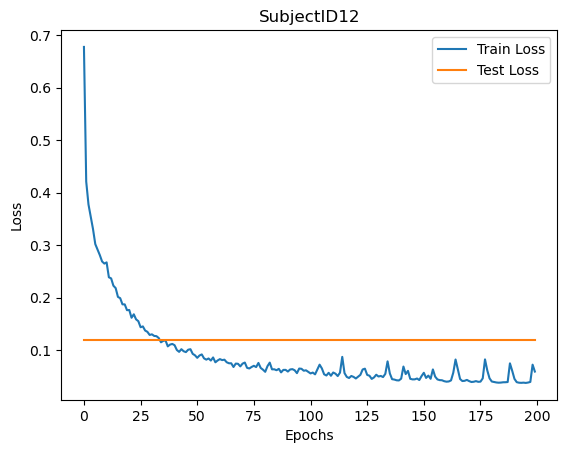

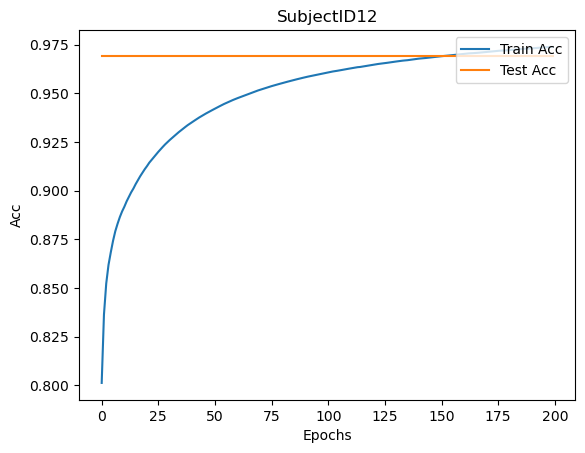


Subject 13
| epoch   0 | 0.1532 s/epoch | train loss 0.6783
| epoch   1 | 0.1427 s/epoch | train loss 0.4269
| epoch   2 | 0.1405 s/epoch | train loss 0.3906
| epoch   3 | 0.1465 s/epoch | train loss 0.3422
| epoch   4 | 0.1464 s/epoch | train loss 0.3262
| epoch   5 | 0.1494 s/epoch | train loss 0.3073
| epoch   6 | 0.1423 s/epoch | train loss 0.2979
| epoch   7 | 0.1525 s/epoch | train loss 0.2824
| epoch   8 | 0.1419 s/epoch | train loss 0.2669
| epoch   9 | 0.1517 s/epoch | train loss 0.2759
| epoch  10 | 0.1464 s/epoch | train loss 0.2559
| epoch  11 | 0.1524 s/epoch | train loss 0.2512
| epoch  12 | 0.1434 s/epoch | train loss 0.2447
| epoch  13 | 0.1411 s/epoch | train loss 0.2389
| epoch  14 | 0.1500 s/epoch | train loss 0.2225
| epoch  15 | 0.1438 s/epoch | train loss 0.2321
| epoch  16 | 0.1539 s/epoch | train loss 0.2241
| epoch  17 | 0.1389 s/epoch | train loss 0.1986
| epoch  18 | 0.1390 s/epoch | train loss 0.2034
| epoch  19 | 0.1508 s/epoch | train loss 0.1987
| epoch 

| epoch 167 | 0.1351 s/epoch | train loss 0.0829
| epoch 168 | 0.1330 s/epoch | train loss 0.0536
| epoch 169 | 0.1399 s/epoch | train loss 0.0425
| epoch 170 | 0.1494 s/epoch | train loss 0.0406
| epoch 171 | 0.1440 s/epoch | train loss 0.0396
| epoch 172 | 0.1394 s/epoch | train loss 0.0391
| epoch 173 | 0.1381 s/epoch | train loss 0.0398
| epoch 174 | 0.1495 s/epoch | train loss 0.0413
| epoch 175 | 0.1379 s/epoch | train loss 0.0407
| epoch 176 | 0.1399 s/epoch | train loss 0.0473
| epoch 177 | 0.1373 s/epoch | train loss 0.0657
| epoch 178 | 0.1393 s/epoch | train loss 0.0561
| epoch 179 | 0.1493 s/epoch | train loss 0.0411
| epoch 180 | 0.1381 s/epoch | train loss 0.0394
| epoch 181 | 0.1406 s/epoch | train loss 0.0385
| epoch 182 | 0.1537 s/epoch | train loss 0.0391
| epoch 183 | 0.1416 s/epoch | train loss 0.0397
| epoch 184 | 0.1415 s/epoch | train loss 0.0382
| epoch 185 | 0.1547 s/epoch | train loss 0.0380
| epoch 186 | 0.1395 s/epoch | train loss 0.0381
| epoch 187 | 0.1522

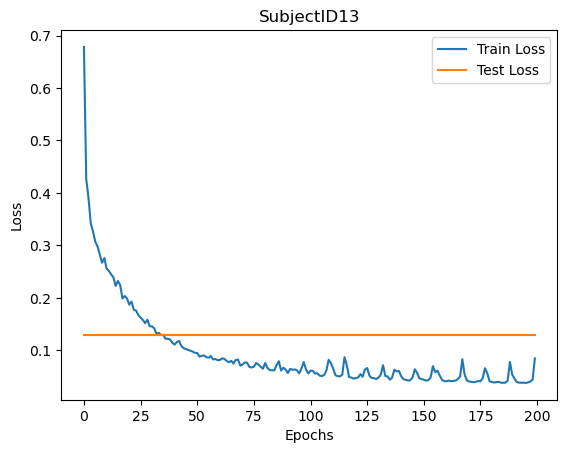

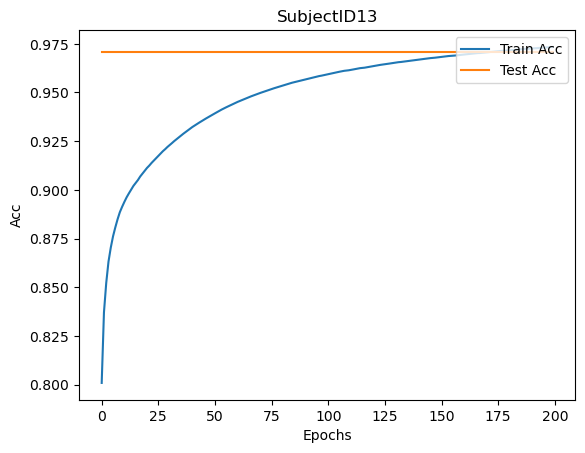


Subject 14
| epoch   0 | 0.1566 s/epoch | train loss 0.6526
| epoch   1 | 0.1546 s/epoch | train loss 0.4236
| epoch   2 | 0.1455 s/epoch | train loss 0.3610
| epoch   3 | 0.1545 s/epoch | train loss 0.3545
| epoch   4 | 0.1586 s/epoch | train loss 0.3240
| epoch   5 | 0.1591 s/epoch | train loss 0.3258
| epoch   6 | 0.1423 s/epoch | train loss 0.2995
| epoch   7 | 0.1530 s/epoch | train loss 0.2873
| epoch   8 | 0.1458 s/epoch | train loss 0.2623
| epoch   9 | 0.1576 s/epoch | train loss 0.2511
| epoch  10 | 0.1439 s/epoch | train loss 0.2457
| epoch  11 | 0.1535 s/epoch | train loss 0.2258
| epoch  12 | 0.1433 s/epoch | train loss 0.2206
| epoch  13 | 0.1525 s/epoch | train loss 0.2074
| epoch  14 | 0.1428 s/epoch | train loss 0.1984
| epoch  15 | 0.1558 s/epoch | train loss 0.1965
| epoch  16 | 0.1433 s/epoch | train loss 0.1783
| epoch  17 | 0.1455 s/epoch | train loss 0.1762
| epoch  18 | 0.1436 s/epoch | train loss 0.1699
| epoch  19 | 0.1521 s/epoch | train loss 0.1659
| epoch 

| epoch 167 | 0.1216 s/epoch | train loss 0.0828
| epoch 168 | 0.1345 s/epoch | train loss 0.0537
| epoch 169 | 0.1424 s/epoch | train loss 0.0408
| epoch 170 | 0.1339 s/epoch | train loss 0.0383
| epoch 171 | 0.1237 s/epoch | train loss 0.0373
| epoch 172 | 0.1343 s/epoch | train loss 0.0368
| epoch 173 | 0.1348 s/epoch | train loss 0.0368
| epoch 174 | 0.1357 s/epoch | train loss 0.0371
| epoch 175 | 0.1379 s/epoch | train loss 0.0367
| epoch 176 | 0.1388 s/epoch | train loss 0.0362
| epoch 177 | 0.1280 s/epoch | train loss 0.0367
| epoch 178 | 0.1340 s/epoch | train loss 0.0381
| epoch 179 | 0.1326 s/epoch | train loss 0.0705
| epoch 180 | 0.1350 s/epoch | train loss 0.0660
| epoch 181 | 0.1340 s/epoch | train loss 0.0406
| epoch 182 | 0.1323 s/epoch | train loss 0.0376
| epoch 183 | 0.1354 s/epoch | train loss 0.0370
| epoch 184 | 0.1250 s/epoch | train loss 0.0364
| epoch 185 | 0.1338 s/epoch | train loss 0.0369
| epoch 186 | 0.1334 s/epoch | train loss 0.0374
| epoch 187 | 0.1365

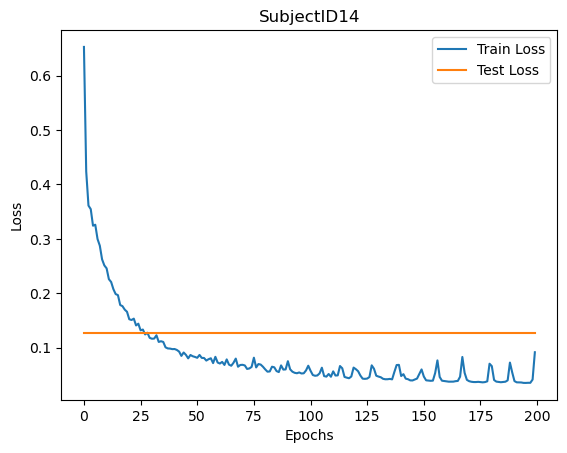

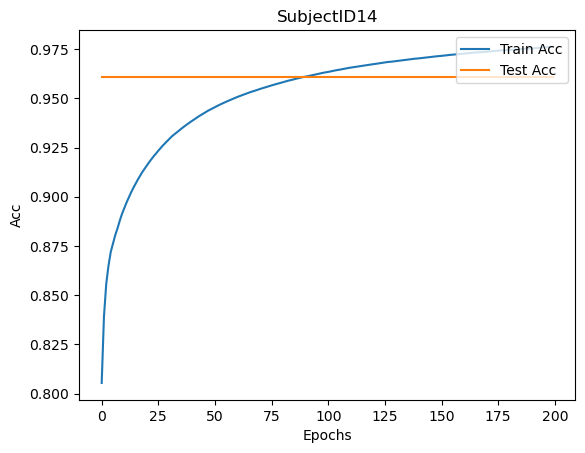


Subject 15
| epoch   0 | 0.1317 s/epoch | train loss 0.6379
| epoch   1 | 0.1252 s/epoch | train loss 0.4170
| epoch   2 | 0.1175 s/epoch | train loss 0.3688
| epoch   3 | 0.1256 s/epoch | train loss 0.3555
| epoch   4 | 0.1199 s/epoch | train loss 0.3332
| epoch   5 | 0.1293 s/epoch | train loss 0.3128
| epoch   6 | 0.1174 s/epoch | train loss 0.3085
| epoch   7 | 0.1255 s/epoch | train loss 0.2905
| epoch   8 | 0.1270 s/epoch | train loss 0.2811
| epoch   9 | 0.1185 s/epoch | train loss 0.2669
| epoch  10 | 0.1287 s/epoch | train loss 0.2580
| epoch  11 | 0.1201 s/epoch | train loss 0.2511
| epoch  12 | 0.1235 s/epoch | train loss 0.2437
| epoch  13 | 0.1171 s/epoch | train loss 0.2270
| epoch  14 | 0.1300 s/epoch | train loss 0.2179
| epoch  15 | 0.1253 s/epoch | train loss 0.2172
| epoch  16 | 0.1175 s/epoch | train loss 0.2099
| epoch  17 | 0.1183 s/epoch | train loss 0.2011
| epoch  18 | 0.1265 s/epoch | train loss 0.1927
| epoch  19 | 0.1118 s/epoch | train loss 0.1910
| epoch 

| epoch 167 | 0.1696 s/epoch | train loss 0.0545
| epoch 168 | 0.1342 s/epoch | train loss 0.0426
| epoch 169 | 0.1086 s/epoch | train loss 0.0412
| epoch 170 | 0.1117 s/epoch | train loss 0.0398
| epoch 171 | 0.1105 s/epoch | train loss 0.0394
| epoch 172 | 0.1140 s/epoch | train loss 0.0386
| epoch 173 | 0.1110 s/epoch | train loss 0.0387
| epoch 174 | 0.1103 s/epoch | train loss 0.0397
| epoch 175 | 0.1141 s/epoch | train loss 0.0422
| epoch 176 | 0.1198 s/epoch | train loss 0.0562
| epoch 177 | 0.2157 s/epoch | train loss 0.0744
| epoch 178 | 0.1261 s/epoch | train loss 0.0490
| epoch 179 | 0.1106 s/epoch | train loss 0.0412
| epoch 180 | 0.1152 s/epoch | train loss 0.0398
| epoch 181 | 0.1135 s/epoch | train loss 0.0391
| epoch 182 | 0.1158 s/epoch | train loss 0.0389
| epoch 183 | 0.1138 s/epoch | train loss 0.0382
| epoch 184 | 0.1107 s/epoch | train loss 0.0378
| epoch 185 | 0.1156 s/epoch | train loss 0.0479
| epoch 186 | 0.1150 s/epoch | train loss 0.0676
| epoch 187 | 0.1135

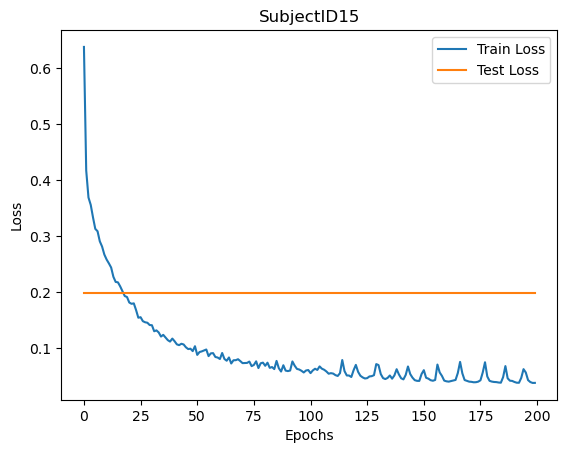

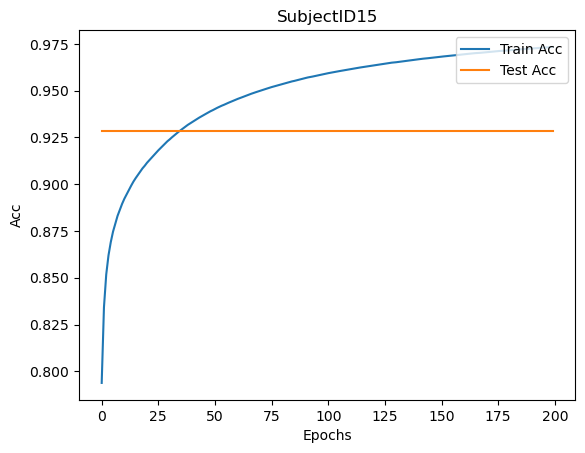


Subject 16
| epoch   0 | 0.1177 s/epoch | train loss 0.6924
| epoch   1 | 0.1122 s/epoch | train loss 0.4370
| epoch   2 | 0.1137 s/epoch | train loss 0.3860
| epoch   3 | 0.1147 s/epoch | train loss 0.3514
| epoch   4 | 0.1114 s/epoch | train loss 0.3230
| epoch   5 | 0.1117 s/epoch | train loss 0.3212
| epoch   6 | 0.1125 s/epoch | train loss 0.2981
| epoch   7 | 0.1128 s/epoch | train loss 0.2884
| epoch   8 | 0.1133 s/epoch | train loss 0.2754
| epoch   9 | 0.1162 s/epoch | train loss 0.2703
| epoch  10 | 0.1096 s/epoch | train loss 0.2645
| epoch  11 | 0.1117 s/epoch | train loss 0.2505
| epoch  12 | 0.1109 s/epoch | train loss 0.2368
| epoch  13 | 0.1106 s/epoch | train loss 0.2242
| epoch  14 | 0.1119 s/epoch | train loss 0.2211
| epoch  15 | 0.1096 s/epoch | train loss 0.2185
| epoch  16 | 0.1130 s/epoch | train loss 0.2013
| epoch  17 | 0.1167 s/epoch | train loss 0.1985
| epoch  18 | 0.1098 s/epoch | train loss 0.1991
| epoch  19 | 0.1128 s/epoch | train loss 0.1865
| epoch 

| epoch 167 | 0.1233 s/epoch | train loss 0.0381
| epoch 168 | 0.1146 s/epoch | train loss 0.0388
| epoch 169 | 0.1230 s/epoch | train loss 0.0425
| epoch 170 | 0.1168 s/epoch | train loss 0.0788
| epoch 171 | 0.1174 s/epoch | train loss 0.0526
| epoch 172 | 0.1166 s/epoch | train loss 0.0421
| epoch 173 | 0.1188 s/epoch | train loss 0.0395
| epoch 174 | 0.1159 s/epoch | train loss 0.0388
| epoch 175 | 0.1177 s/epoch | train loss 0.0393
| epoch 176 | 0.1193 s/epoch | train loss 0.0380
| epoch 177 | 0.1186 s/epoch | train loss 0.0381
| epoch 178 | 0.1120 s/epoch | train loss 0.0383
| epoch 179 | 0.1135 s/epoch | train loss 0.0402
| epoch 180 | 0.1136 s/epoch | train loss 0.0641
| epoch 181 | 0.1122 s/epoch | train loss 0.0664
| epoch 182 | 0.1108 s/epoch | train loss 0.0443
| epoch 183 | 0.1073 s/epoch | train loss 0.0394
| epoch 184 | 0.1219 s/epoch | train loss 0.0396
| epoch 185 | 0.1382 s/epoch | train loss 0.0388
| epoch 186 | 0.1278 s/epoch | train loss 0.0374
| epoch 187 | 0.1258

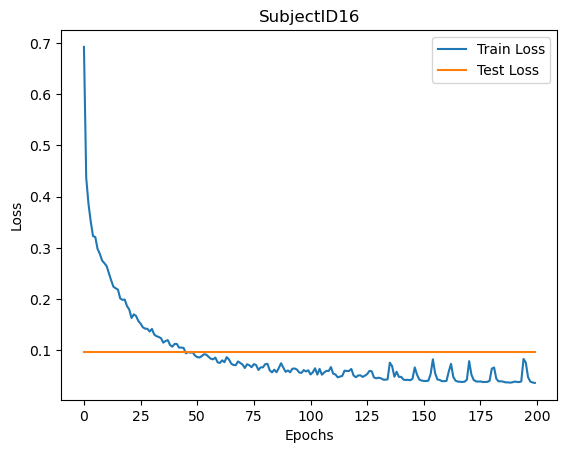

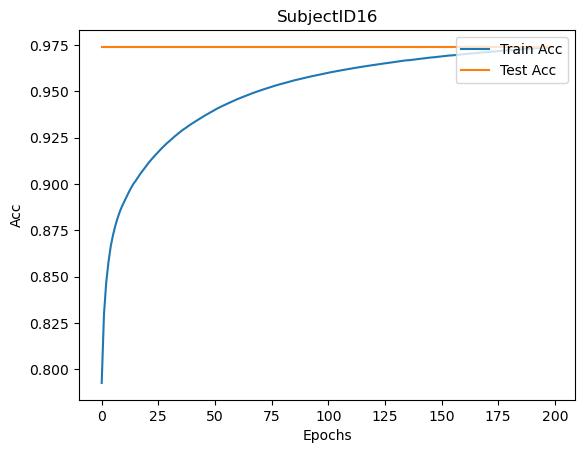


Subject 18
| epoch   0 | 0.1210 s/epoch | train loss 0.6592
| epoch   1 | 0.1506 s/epoch | train loss 0.4049
| epoch   2 | 0.1092 s/epoch | train loss 0.3585
| epoch   3 | 0.1156 s/epoch | train loss 0.3433
| epoch   4 | 0.1508 s/epoch | train loss 0.3206
| epoch   5 | 0.1118 s/epoch | train loss 0.3037
| epoch   6 | 0.1443 s/epoch | train loss 0.2925
| epoch   7 | 0.1146 s/epoch | train loss 0.2812
| epoch   8 | 0.1158 s/epoch | train loss 0.2668
| epoch   9 | 0.1089 s/epoch | train loss 0.2532
| epoch  10 | 0.1096 s/epoch | train loss 0.2617
| epoch  11 | 0.1084 s/epoch | train loss 0.2382
| epoch  12 | 0.1110 s/epoch | train loss 0.2294
| epoch  13 | 0.1099 s/epoch | train loss 0.2189
| epoch  14 | 0.1125 s/epoch | train loss 0.2161
| epoch  15 | 0.1215 s/epoch | train loss 0.1989
| epoch  16 | 0.1356 s/epoch | train loss 0.1932
| epoch  17 | 0.1323 s/epoch | train loss 0.1856
| epoch  18 | 0.1130 s/epoch | train loss 0.1794
| epoch  19 | 0.1110 s/epoch | train loss 0.1720
| epoch 

| epoch 167 | 0.1141 s/epoch | train loss 0.0384
| epoch 168 | 0.1139 s/epoch | train loss 0.0376
| epoch 169 | 0.1135 s/epoch | train loss 0.0715
| epoch 170 | 0.1158 s/epoch | train loss 0.0607
| epoch 171 | 0.1147 s/epoch | train loss 0.0469
| epoch 172 | 0.1142 s/epoch | train loss 0.0397
| epoch 173 | 0.1124 s/epoch | train loss 0.0385
| epoch 174 | 0.1134 s/epoch | train loss 0.0385
| epoch 175 | 0.1120 s/epoch | train loss 0.0392
| epoch 176 | 0.1092 s/epoch | train loss 0.0374
| epoch 177 | 0.1150 s/epoch | train loss 0.0381
| epoch 178 | 0.1184 s/epoch | train loss 0.0432
| epoch 179 | 0.1161 s/epoch | train loss 0.0851
| epoch 180 | 0.1135 s/epoch | train loss 0.0511
| epoch 181 | 0.1135 s/epoch | train loss 0.0419
| epoch 182 | 0.1151 s/epoch | train loss 0.0383
| epoch 183 | 0.1183 s/epoch | train loss 0.0368
| epoch 184 | 0.1121 s/epoch | train loss 0.0365
| epoch 185 | 0.1149 s/epoch | train loss 0.0363
| epoch 186 | 0.1169 s/epoch | train loss 0.0363
| epoch 187 | 0.1126

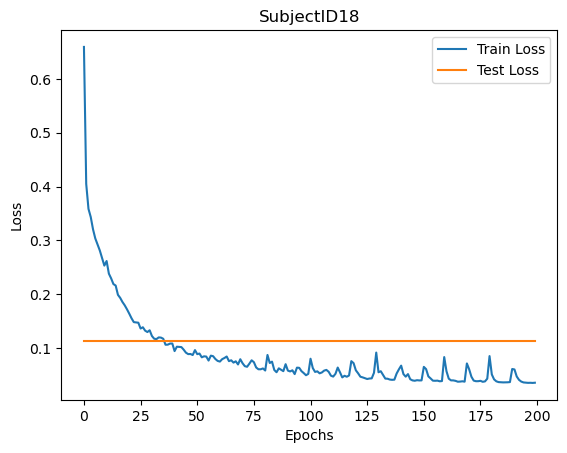

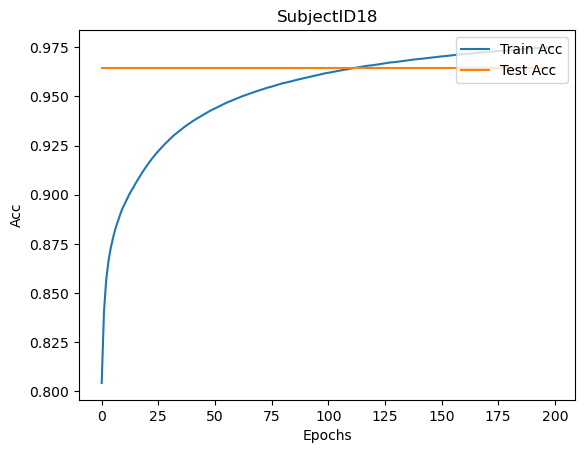


Subject 19
| epoch   0 | 0.1157 s/epoch | train loss 0.6970
| epoch   1 | 0.1160 s/epoch | train loss 0.4358
| epoch   2 | 0.1214 s/epoch | train loss 0.3924
| epoch   3 | 0.1143 s/epoch | train loss 0.3577
| epoch   4 | 0.1192 s/epoch | train loss 0.3535
| epoch   5 | 0.1188 s/epoch | train loss 0.3470
| epoch   6 | 0.1121 s/epoch | train loss 0.3256
| epoch   7 | 0.1121 s/epoch | train loss 0.3050
| epoch   8 | 0.1140 s/epoch | train loss 0.2863
| epoch   9 | 0.1146 s/epoch | train loss 0.2837
| epoch  10 | 0.1157 s/epoch | train loss 0.2765
| epoch  11 | 0.1160 s/epoch | train loss 0.2697
| epoch  12 | 0.1155 s/epoch | train loss 0.2603
| epoch  13 | 0.1136 s/epoch | train loss 0.2556
| epoch  14 | 0.1152 s/epoch | train loss 0.2534
| epoch  15 | 0.1198 s/epoch | train loss 0.2389
| epoch  16 | 0.1182 s/epoch | train loss 0.2244
| epoch  17 | 0.1145 s/epoch | train loss 0.2260
| epoch  18 | 0.1160 s/epoch | train loss 0.2099
| epoch  19 | 0.1200 s/epoch | train loss 0.2169
| epoch 

| epoch 167 | 0.1288 s/epoch | train loss 0.0397
| epoch 168 | 0.1322 s/epoch | train loss 0.0625
| epoch 169 | 0.1289 s/epoch | train loss 0.0752
| epoch 170 | 0.1494 s/epoch | train loss 0.0555
| epoch 171 | 0.1228 s/epoch | train loss 0.0482
| epoch 172 | 0.1168 s/epoch | train loss 0.0438
| epoch 173 | 0.1337 s/epoch | train loss 0.0391
| epoch 174 | 0.1489 s/epoch | train loss 0.0388
| epoch 175 | 0.1182 s/epoch | train loss 0.0388
| epoch 176 | 0.1236 s/epoch | train loss 0.0394
| epoch 177 | 0.1223 s/epoch | train loss 0.0395
| epoch 178 | 0.1180 s/epoch | train loss 0.0387
| epoch 179 | 0.1176 s/epoch | train loss 0.0391
| epoch 180 | 0.1220 s/epoch | train loss 0.0402
| epoch 181 | 0.1223 s/epoch | train loss 0.0426
| epoch 182 | 0.1208 s/epoch | train loss 0.0952
| epoch 183 | 0.1153 s/epoch | train loss 0.0570
| epoch 184 | 0.1193 s/epoch | train loss 0.0411
| epoch 185 | 0.1285 s/epoch | train loss 0.0381
| epoch 186 | 0.1260 s/epoch | train loss 0.0375
| epoch 187 | 0.1282

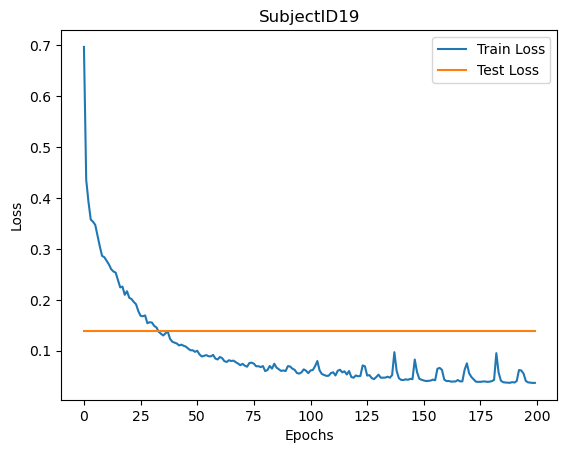

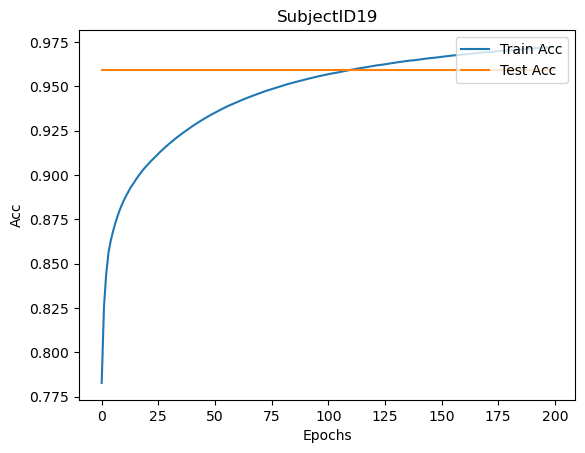


Subject 21
| epoch   0 | 0.1306 s/epoch | train loss 0.6131
| epoch   1 | 0.1228 s/epoch | train loss 0.4079
| epoch   2 | 0.1206 s/epoch | train loss 0.3707
| epoch   3 | 0.1198 s/epoch | train loss 0.3443
| epoch   4 | 0.1243 s/epoch | train loss 0.3338
| epoch   5 | 0.1196 s/epoch | train loss 0.3237
| epoch   6 | 0.1274 s/epoch | train loss 0.3060
| epoch   7 | 0.1194 s/epoch | train loss 0.2932
| epoch   8 | 0.1191 s/epoch | train loss 0.2799
| epoch   9 | 0.1193 s/epoch | train loss 0.2684
| epoch  10 | 0.1178 s/epoch | train loss 0.2631
| epoch  11 | 0.1190 s/epoch | train loss 0.2507
| epoch  12 | 0.1204 s/epoch | train loss 0.2358
| epoch  13 | 0.1208 s/epoch | train loss 0.2279
| epoch  14 | 0.1522 s/epoch | train loss 0.2274
| epoch  15 | 0.2274 s/epoch | train loss 0.2174
| epoch  16 | 0.2229 s/epoch | train loss 0.2099
| epoch  17 | 0.2280 s/epoch | train loss 0.2056
| epoch  18 | 0.2253 s/epoch | train loss 0.1945
| epoch  19 | 0.2328 s/epoch | train loss 0.1920
| epoch 

| epoch 167 | 0.1206 s/epoch | train loss 0.0638
| epoch 168 | 0.1230 s/epoch | train loss 0.0531
| epoch 169 | 0.1268 s/epoch | train loss 0.0521
| epoch 170 | 0.1321 s/epoch | train loss 0.0479
| epoch 171 | 0.1299 s/epoch | train loss 0.0421
| epoch 172 | 0.1331 s/epoch | train loss 0.0419
| epoch 173 | 0.1348 s/epoch | train loss 0.0411
| epoch 174 | 0.1314 s/epoch | train loss 0.0400
| epoch 175 | 0.1332 s/epoch | train loss 0.0406
| epoch 176 | 0.1339 s/epoch | train loss 0.0390
| epoch 177 | 0.1352 s/epoch | train loss 0.0431
| epoch 178 | 0.1325 s/epoch | train loss 0.0613
| epoch 179 | 0.1328 s/epoch | train loss 0.0538
| epoch 180 | 0.1321 s/epoch | train loss 0.0524
| epoch 181 | 0.1337 s/epoch | train loss 0.0435
| epoch 182 | 0.1428 s/epoch | train loss 0.0396
| epoch 183 | 0.1350 s/epoch | train loss 0.0418
| epoch 184 | 0.1367 s/epoch | train loss 0.0384
| epoch 185 | 0.1395 s/epoch | train loss 0.0381
| epoch 186 | 0.1406 s/epoch | train loss 0.0376
| epoch 187 | 0.1341

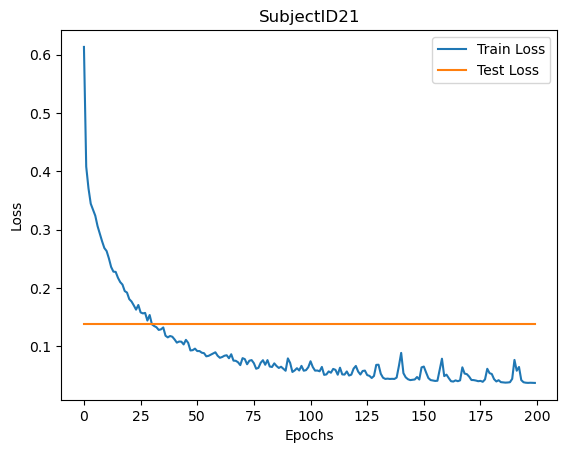

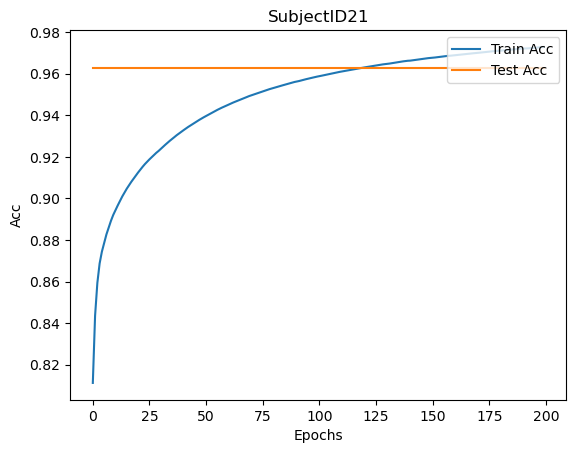


Subject 22
| epoch   0 | 0.1363 s/epoch | train loss 0.6670
| epoch   1 | 0.1378 s/epoch | train loss 0.4224
| epoch   2 | 0.1374 s/epoch | train loss 0.3618
| epoch   3 | 0.1399 s/epoch | train loss 0.3369
| epoch   4 | 0.1353 s/epoch | train loss 0.3136
| epoch   5 | 0.1320 s/epoch | train loss 0.2986
| epoch   6 | 0.1414 s/epoch | train loss 0.2886
| epoch   7 | 0.1376 s/epoch | train loss 0.2724
| epoch   8 | 0.1411 s/epoch | train loss 0.2656
| epoch   9 | 0.1388 s/epoch | train loss 0.2525
| epoch  10 | 0.1422 s/epoch | train loss 0.2472
| epoch  11 | 0.1358 s/epoch | train loss 0.2303
| epoch  12 | 0.1376 s/epoch | train loss 0.2210
| epoch  13 | 0.1417 s/epoch | train loss 0.2117
| epoch  14 | 0.1425 s/epoch | train loss 0.2016
| epoch  15 | 0.1263 s/epoch | train loss 0.1908
| epoch  16 | 0.1235 s/epoch | train loss 0.1846
| epoch  17 | 0.1153 s/epoch | train loss 0.1881
| epoch  18 | 0.1143 s/epoch | train loss 0.1769
| epoch  19 | 0.1179 s/epoch | train loss 0.1643
| epoch 

| epoch 167 | 0.1141 s/epoch | train loss 0.0396
| epoch 168 | 0.1162 s/epoch | train loss 0.0395
| epoch 169 | 0.1154 s/epoch | train loss 0.0396
| epoch 170 | 0.1193 s/epoch | train loss 0.0433
| epoch 171 | 0.1168 s/epoch | train loss 0.0428
| epoch 172 | 0.1237 s/epoch | train loss 0.0403
| epoch 173 | 0.1239 s/epoch | train loss 0.0390
| epoch 174 | 0.1251 s/epoch | train loss 0.0481
| epoch 175 | 0.1179 s/epoch | train loss 0.0764
| epoch 176 | 0.1217 s/epoch | train loss 0.0519
| epoch 177 | 0.1203 s/epoch | train loss 0.0404
| epoch 178 | 0.1173 s/epoch | train loss 0.0385
| epoch 179 | 0.1201 s/epoch | train loss 0.0382
| epoch 180 | 0.1201 s/epoch | train loss 0.0379
| epoch 181 | 0.1123 s/epoch | train loss 0.0377
| epoch 182 | 0.1058 s/epoch | train loss 0.0495
| epoch 183 | 0.1040 s/epoch | train loss 0.0708
| epoch 184 | 0.1032 s/epoch | train loss 0.0563
| epoch 185 | 0.1061 s/epoch | train loss 0.0416
| epoch 186 | 0.1126 s/epoch | train loss 0.0390
| epoch 187 | 0.1051

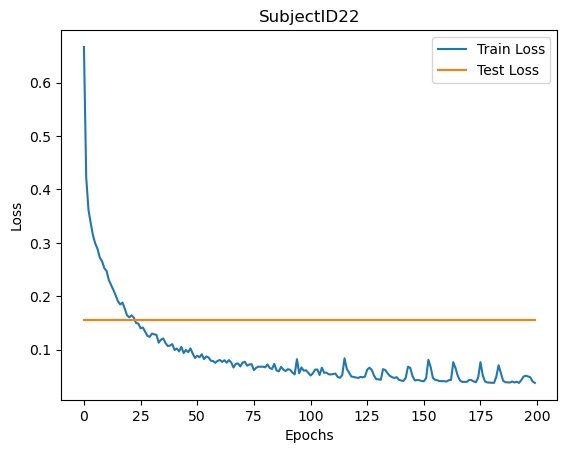

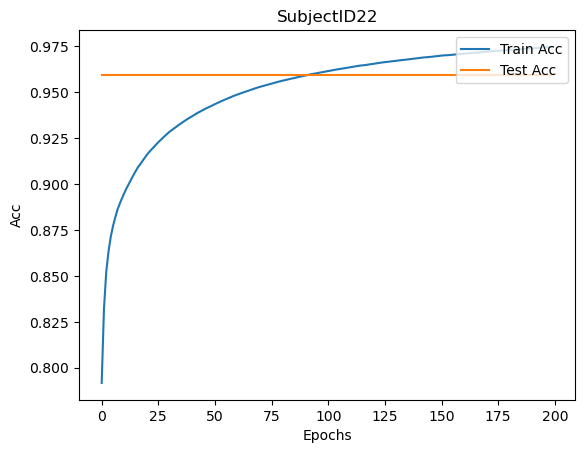


Subject 23
| epoch   0 | 0.1089 s/epoch | train loss 0.6087
| epoch   1 | 0.1085 s/epoch | train loss 0.3952
| epoch   2 | 0.1049 s/epoch | train loss 0.3640
| epoch   3 | 0.1076 s/epoch | train loss 0.3296
| epoch   4 | 0.1086 s/epoch | train loss 0.3124
| epoch   5 | 0.1092 s/epoch | train loss 0.2878
| epoch   6 | 0.1082 s/epoch | train loss 0.2772
| epoch   7 | 0.1120 s/epoch | train loss 0.2536
| epoch   8 | 0.1026 s/epoch | train loss 0.2458
| epoch   9 | 0.1060 s/epoch | train loss 0.2555
| epoch  10 | 0.1042 s/epoch | train loss 0.2275
| epoch  11 | 0.1149 s/epoch | train loss 0.2168
| epoch  12 | 0.1194 s/epoch | train loss 0.2199
| epoch  13 | 0.1211 s/epoch | train loss 0.2085
| epoch  14 | 0.1142 s/epoch | train loss 0.2033
| epoch  15 | 0.1179 s/epoch | train loss 0.1982
| epoch  16 | 0.1122 s/epoch | train loss 0.1887
| epoch  17 | 0.1191 s/epoch | train loss 0.1774
| epoch  18 | 0.1204 s/epoch | train loss 0.1776
| epoch  19 | 0.1183 s/epoch | train loss 0.1737
| epoch 

| epoch 167 | 0.1152 s/epoch | train loss 0.0363
| epoch 168 | 0.1108 s/epoch | train loss 0.0403
| epoch 169 | 0.1149 s/epoch | train loss 0.0854
| epoch 170 | 0.1108 s/epoch | train loss 0.0626
| epoch 171 | 0.1151 s/epoch | train loss 0.0498
| epoch 172 | 0.1167 s/epoch | train loss 0.0511
| epoch 173 | 0.1167 s/epoch | train loss 0.0401
| epoch 174 | 0.1184 s/epoch | train loss 0.0362
| epoch 175 | 0.1162 s/epoch | train loss 0.0352
| epoch 176 | 0.1137 s/epoch | train loss 0.0345
| epoch 177 | 0.1162 s/epoch | train loss 0.0341
| epoch 178 | 0.1145 s/epoch | train loss 0.0341
| epoch 179 | 0.1144 s/epoch | train loss 0.0338
| epoch 180 | 0.1178 s/epoch | train loss 0.0337
| epoch 181 | 0.1153 s/epoch | train loss 0.0342
| epoch 182 | 0.1147 s/epoch | train loss 0.0362
| epoch 183 | 0.1136 s/epoch | train loss 0.0350
| epoch 184 | 0.1139 s/epoch | train loss 0.0559
| epoch 185 | 0.1158 s/epoch | train loss 0.0804
| epoch 186 | 0.1162 s/epoch | train loss 0.0497
| epoch 187 | 0.1146

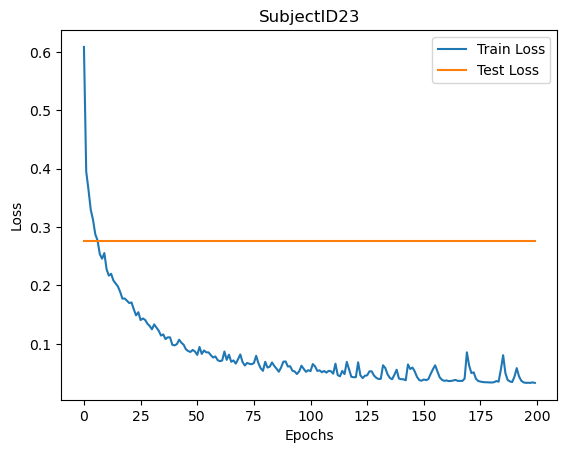

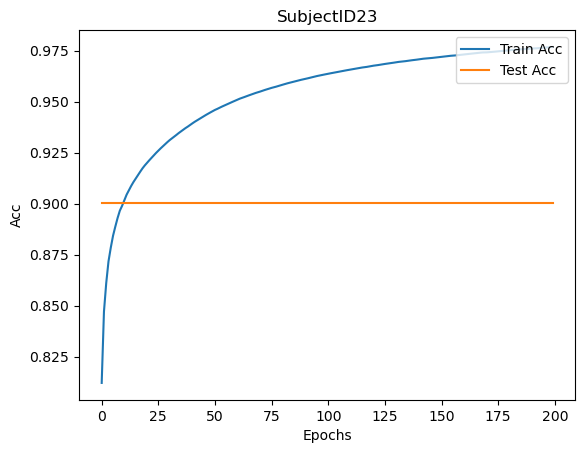

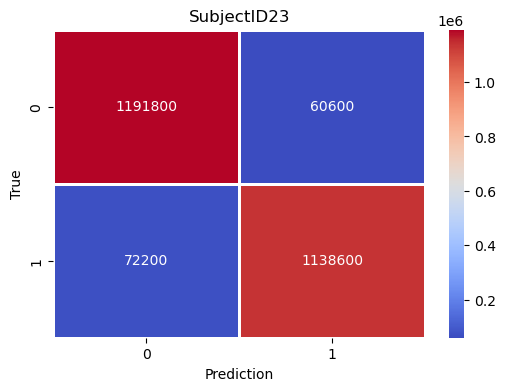

Distillation_student(CNNSmall)_Acc: 0.9460863916856123
Distillation_student(CNNSmall)_Rec: 0.9403700033036009
Distillation_student(CNNSmall)_Pre: 0.949466310873916
Distillation_student(CNNSmall)_F1: 0.944896265560166


<Figure size 640x480 with 0 Axes>

In [19]:
#Layer 2 Training Student
# Distillation_teacher_model = None
Distillation_teacher_model = load_checkpoint(model_teacher_student, PATH)

Distillation_student_train_preds = []
Distillation_student_train_gt = []

for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float32'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float32'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float32')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float32')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    #model_Distillation_student = MobileNetV3_Small_KD().to(device)
    model_Distillation_student = Net_Teacher_Student(config).to(device) 
    model_Distillation_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_distillation_student = torch.optim.Adam(model_Distillation_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = True
    training_distillation_student(trainloader,optimizer_distillation_student,criterion,Distillation_teacher_model,model_Distillation_student,alpha,testloader,Layer,sub)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)

show_CM_teacher_student(Distillation_student_train_preds, Distillation_student_train_gt)
teacher_Student_eval_table = evaluation(Distillation_student_train_preds, Distillation_student_train_gt)    

print("Distillation_student(CNNSmall)_Acc:",teacher_Student_eval_table[0])
print("Distillation_student(CNNSmall)_Rec:",teacher_Student_eval_table[1])
print("Distillation_student(CNNSmall)_Pre:",teacher_Student_eval_table[2])
print("Distillation_student(CNNSmall)_F1:",teacher_Student_eval_table[3])


In [20]:
# print("Teacher(RestNet50)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(RestNet50)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(RestNet50)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(RestNet50)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(CNN)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(CNN)_Rec:",sum(Recall_student)/11)
# print("Original_Student(CNN)_Pre:",sum(Precision_student)/11)
# print("Original_Student(CNN)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(CNN)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(CNN)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(CNN)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(CNN)_F1:",sum(F1score_teacher_student)/11)



dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_student, params_student = profile(model_student,(dummy_input,))
print('flops:',flops_student, 'params', params_student)
print('\nflops_student: %.3f K, params_student: %.3f K' % (flops_student / 1000.0, params_student / 1000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('flops:',flops_teacher_student, 'params', params_teacher_student)
print('\nflops_teacher_student: %.3f K, params_teacher_student: %.3f K' % (flops_teacher_student / 1000.0, params_teacher_student / 1000.0))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


flops_teacher: 2305.343 M, params_teachar: 23.503 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
flops: 10412032.0 params 120066.0

flops_student: 10412.032 K, params_student: 120.066 K
[INFO] Register count_convNd() for <class 'torch.nn.modul